In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

# Import the data

In [2]:
player_df = pd.read_csv('./data/nhl-player-data.csv')
team_df = pd.read_csv('./data/nhl-teams.csv')

## Rename columns based on provided README to make them more approachable

In [3]:
player_df = player_df.rename({
    'Rk': 'rank',
    'Age': 'age',
    'Player': 'player',
    'Pos': 'position',
    'Tm': 'team',
    'GP': 'games_played',
    'G': 'goals',
    'A': 'assists',
    'PTS': 'points',
    'plusminus': 'plus_minus',
    'PIM': 'penalty_minutes',
    'PS': 'team_points_ratio',
    'EV': 'num_goals_5on5',
    'PP': 'num_goals_powerplay',
    'SH': 'num_goals_shorthanded',
    'GW': 'num_goals_gamewinning',
    'EV.1': 'num_assists_5on5',
    'PP.1': 'num_assists_powerplay',
    'SH.1': 'num_assists_shorthanded',
    'GW.1': 'num_assists_gamewinning',
    'S': 'shoots_on_goal',
    'S_percent': 'shoot_success_rate',
    'TOI': 'time_on_ice',
    'ATOI': 'average_time_on_ice',
    'BLK': 'num_blocked_shots',
    'HIT': 'num_hits',
    'FOW': 'faceoff_wins',
    'FOL': 'faceoff_losses',
    'FO_percent': 'faceoff_success_rate',
    'HART': 'num_HT_wins',
    'Votes': 'num_HT_votes',
    'Season': 'season'
}, axis=1)

## Drop evidently useless columns

In [4]:
player_df.drop('Nick', axis=1, inplace=True, errors='ignore')

# 1. Data cleaning

## Have a look at columns now and their basic statistics

In [5]:
player_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12328 entries, 0 to 12327
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   rank                     12328 non-null  int64  
 1   player                   12328 non-null  object 
 2   age                      12328 non-null  int64  
 3   position                 12328 non-null  object 
 4   team                     12328 non-null  object 
 5   games_played             12328 non-null  int64  
 6   goals                    12328 non-null  int64  
 7   assists                  12328 non-null  int64  
 8   points                   12328 non-null  int64  
 9   plus_minus               12328 non-null  int64  
 10  penalty_minutes          12328 non-null  int64  
 11  team_points_ratio        12328 non-null  float64
 12  num_goals_5on5           12328 non-null  int64  
 13  num_goals_powerplay      12328 non-null  int64  
 14  num_goals_shorthanded 

Let's first deal with NaN values. Let's see how many there are per column.

In [6]:
nan_sums = player_df.isna().sum()
nan_sums[nan_sums > 0]

shoot_success_rate      124
num_blocked_shots         1
faceoff_wins              1
faceoff_losses            1
faceoff_success_rate    311
dtype: int64

Now we see that there is only 1 missing value in columns **num_blocked_shots**, **faceoff_wins**, **faceoff_losses**. Let's have a look at those.

In [7]:
cols = ['num_blocked_shots', 'faceoff_wins', 'faceoff_losses']

for col in cols:
    print('#'*40)
    print(col)
    print(player_df[player_df[col].isna()])

########################################
num_blocked_shots
       rank         player  age position team  games_played  goals  assists  points  plus_minus  penalty_minutes  team_points_ratio  num_goals_5on5  num_goals_powerplay  num_goals_shorthanded  num_goals_gamewinning  num_assists_5on5  num_assists_powerplay  num_assists_shorthanded  shoots_on_goal  shoot_success_rate  time_on_ice  average_time_on_ice  num_blocked_shots  num_hits  faceoff_wins  faceoff_losses  faceoff_success_rate  num_HT_wins  num_HT_votes  season
12291   854  Brian Lashoff   27        D  DET             1      0        0       0           0                0                0.0               0                    0                      0                      0                 0                      0                        0               0                 NaN            4                  4.0                NaN         0           NaN             NaN                   NaN            0             0    2018
#######

We see it is the same row/record. It is also fairly uninterresting, since they got 0 votes for the Hart Trohpy. Let's therefore drop this record, as it seems it has no value and can potentially be corrupt.

In [8]:
player_df.drop(12291, inplace=True)

Now let's deal with **shoot_success_rate**. I would expect that this value should be a NaN iff the player had no shots on goal in the season. Let's explore this idea.

In [9]:
missing_success_rate = player_df.shoot_success_rate.isna()
player_df[missing_success_rate]['shoots_on_goal'].describe()

count    123.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: shoots_on_goal, dtype: float64

Ok, we see that the NaN ones are the ones with 0 shots on goal. Now let's see if there are any records that have 0 shots but the success rate not set to NaN.

In [10]:
zero_shots = player_df.shoots_on_goal == 0
player_df[zero_shots & ~missing_success_rate].shape[0]

273

We see there is 273 of them. Let's therefore set their success rate to NaN, as it is technically not defined.

In [11]:
player_df.loc[zero_shots, 'shoot_success_rate'] = np.nan

Now let's have a look at faceoff success rate. We should expect that the NaN values are the players that did not participate in any faceoff. This means they had:
- 0 faceoff_wins
- 0 faceoff_losses

In [12]:
success_rate_undef = player_df.faceoff_success_rate.isna()
player_df[success_rate_undef][['faceoff_wins', 'faceoff_losses']].describe()

faceoff_wins  faceoff_losses
count         310.0           310.0
mean            0.0             0.0
std             0.0             0.0
min             0.0             0.0
25%             0.0             0.0
50%             0.0             0.0
75%             0.0             0.0
max             0.0             0.0

We see that the condition that only the players that did not participate in a faceoff have a NaN value in the success rate column. Now let's see if there are any more that did not participate in any faceoff but do not have a NaN value in the success rate.

In [13]:
no_faceoffs = (player_df.faceoff_wins == 0) & (player_df.faceoff_losses == 0)
player_df[no_faceoffs & ~success_rate_undef]['faceoff_success_rate'].describe()

count    5865.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: faceoff_success_rate, dtype: float64

Ok, there really is plenty of them. Let's therefore fix this and set the value to a NaN.

In [14]:
player_df.loc[no_faceoffs, 'faceoff_success_rate'] = np.nan

Now let's see if there are some logical conditions on the data disturbed.

In [15]:
player_df.describe()

rank           age  games_played         goals       assists        points    plus_minus  penalty_minutes  team_points_ratio  num_goals_5on5  num_goals_powerplay  num_goals_shorthanded  num_goals_gamewinning  num_assists_5on5  num_assists_powerplay  num_assists_shorthanded  shoots_on_goal  shoot_success_rate   time_on_ice  average_time_on_ice  num_blocked_shots      num_hits  faceoff_wins  faceoff_losses  faceoff_success_rate   num_HT_wins  num_HT_votes        season
count  12327.000000  12327.000000  12327.000000  12327.000000  12327.000000  12327.000000  12327.000000     12327.000000       12327.000000    12327.000000         12327.000000           12327.000000           12327.000000      12327.000000           12327.000000             12327.000000    12327.000000        11931.000000  12327.000000         12327.000000       12327.000000  12327.000000  12327.000000    12327.000000           6152.000000  12327.000000  12327.000000  12327.000000
mean     629.923420     26.640707     48.906628      7.484871     12.788756     20.273627     -0.351829        31.973716           2.480271        5.387604             1.859333               0.237933               1.191612          9.004705               3.531354                 0.252697       81.281739            7.699606    804.884643            14.252622          29.443823     47.274357     62.307536       62.306563             42.256518      0.001136      3.317352   2011.438063
std      553.889804      4.582962     28.663999      8.847038     13.129523     20.778516      9.415030        32.314676           2.813333        6.127320             3.182354               0.663062               1.760147          8.382506               5.718146                 0.610621       71.190374            7.556340    576.785797             4.979352          38.987010     54.327598    160.312502      152.299919             21.427258      0.033683     53.897601      4.170612
min        1.000000      0.000000      1.000000      0.000000      0.000000      0.000000    -46.000000         0.000000          -1.900000        0.000000             0.000000               0.000000               0.000000          0.000000               0.000000                 0.000000        0.000000            0.000000      1.000000             0.000000           0.000000      0.000000      0.000000        0.000000              0.000000      0.000000      0.000000   2004.000000
25%      257.000000     23.000000     21.000000      1.000000      2.000000      3.000000     -5.000000         8.000000           0.200000        1.000000             0.000000               0.000000               0.000000          2.000000               0.000000                 0.000000       19.000000            2.900000    235.500000            10.966667           0.000000      1.000000      0.000000        0.000000             33.300000      0.000000      0.000000   2008.000000
50%      514.000000     26.000000     57.000000      4.000000      9.000000     14.000000     -1.000000        24.000000           1.600000        3.000000             0.000000               0.000000               0.000000          7.000000               1.000000                 0.000000       67.000000            7.100000    812.000000            14.616667          15.000000     30.000000      0.000000        0.000000             45.900000      0.000000      0.000000   2012.000000
75%      771.000000     30.000000     76.000000     11.000000     20.000000     32.000000      4.000000        45.000000           4.100000        8.000000             3.000000               0.000000               2.000000         14.000000               5.000000                 0.000000      126.000000           11.100000   1283.000000            18.000000          41.000000     75.000000     14.000000       19.000000             51.700000      0.000000      0.000000   2015.000000
max     2644.000000     48.000000     84.000000     65.000000     96.000000    125.000000     50.000000       324.00000

We immediatelly see that there is someone with age of 0. Let's look at every player that is under 18, which should legally not be allowed to play in the NHL.

In [16]:
player_df[player_df.age < 18]

rank          player  age position team  games_played  goals  assists  points  plus_minus  penalty_minutes  team_points_ratio  num_goals_5on5  num_goals_powerplay  num_goals_shorthanded  num_goals_gamewinning  num_assists_5on5  num_assists_powerplay  num_assists_shorthanded  shoots_on_goal  shoot_success_rate  time_on_ice  average_time_on_ice  num_blocked_shots  num_hits  faceoff_wins  faceoff_losses  faceoff_success_rate  num_HT_wins  num_HT_votes  season
871   872  Dillon Simpson    0        D  EDM             3      0        0       0           0                2                0.0               0                    0                      0                      0                 0                      0                        0               2                 0.0           33            10.883333                2.0         3           0.0             0.0                   NaN            0             0    2017

Ok, there is only 1 person like this with the age of 0. Let's remove this record as we don't know what might be good or bad with this record.

In [17]:
player_df.drop(871, inplace=True)

Now let's have a look at those who have 0 in **average_time_on_ice**. This is suspicious, since the *min* value of total **time_on_ice** is 1. 

In [18]:
player_df[player_df.average_time_on_ice == 0]

rank          player  age position team  games_played  goals  assists  points  plus_minus  penalty_minutes  team_points_ratio  num_goals_5on5  num_goals_powerplay  num_goals_shorthanded  num_goals_gamewinning  num_assists_5on5  num_assists_powerplay  num_assists_shorthanded  shoots_on_goal  shoot_success_rate  time_on_ice  average_time_on_ice  num_blocked_shots  num_hits  faceoff_wins  faceoff_losses  faceoff_success_rate  num_HT_wins  num_HT_votes  season
3680   127  Sergei Gonchar   38        D  OTT            45      3       24      27           4               26                5.3               1                    2                      0                      3                14                     10                        0              85                 3.5         1080                  0.0               65.0        25           0.0             0.0                   NaN            0             0    2013
3825   272    Justin Faulk   20        D  CAR            38      5       10      15           1               15                2.8               3                    1                      1                      0                 8                      2                        0              76                 6.6          912                  0.0               47.0        63           0.0             0.0                   NaN            0             0    2013

As those records seem valid (apart from this value), let's fill it in by what it should be.

In [19]:
player_df['average_time_on_ice'] = player_df['time_on_ice'] / player_df['games_played']

Now let's check other constains, such as values being higher than possible values (more goals than shots on goal, more points not equal to goals+assits, etc).

In [20]:
# Any goals+assits != points?
(~(player_df.goals + player_df.assists) == player_df.points).any()

False

In [21]:
# any num_goals_{5on5/powerplay/shorthanded/gamewinning} > total goals?
for col in ['num_goals_5on5', 'num_goals_powerplay', 'num_goals_shorthanded', 'num_goals_gamewinning']:
    print(f'{col}: {(player_df.goals < player_df[col]).any()}')

num_goals_5on5: False
num_goals_powerplay: False
num_goals_shorthanded: False
num_goals_gamewinning: False


In [22]:
# same with assits
for col in ['num_assists_5on5', 'num_assists_powerplay', 'num_assists_shorthanded']:
    print(f'{col}: {(player_df.assists < player_df[col]).any()}')

num_assists_5on5: False
num_assists_powerplay: False
num_assists_shorthanded: False


In [23]:
# shoot success rate not matching the ratio it should be from shots_on_goal / goals?
any_goals = player_df[player_df.goals > 0]
(((any_goals.goals / any_goals.shoots_on_goal * 100) - any_goals.shoot_success_rate).abs() > 1).any()

False

In [24]:
# Same with faceoffs
# shoot success rate not matching the ratio it should be from shots_on_goal / goals?
any_faceoff = player_df[~player_df.faceoff_success_rate.isna()]
(((any_faceoff.faceoff_wins / (any_faceoff.faceoff_wins + any_faceoff.faceoff_losses) * 100) - any_faceoff.faceoff_success_rate).abs() > 1).any()

False

# 2. Data distribution

Now let's have a look of data distribution, first by taking only a signle variable at a time.

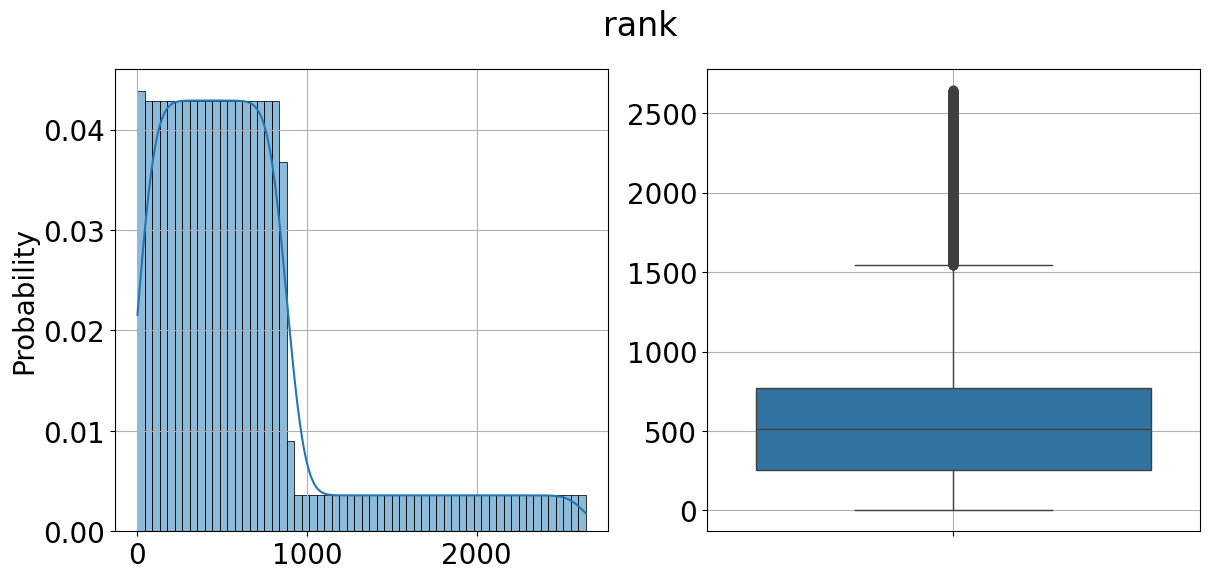

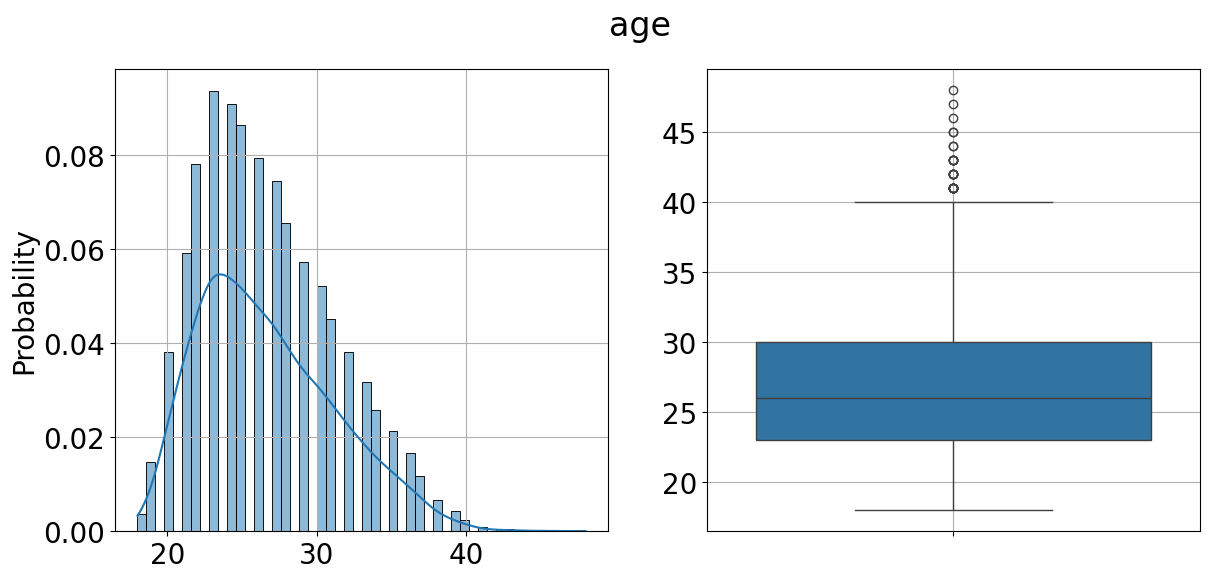

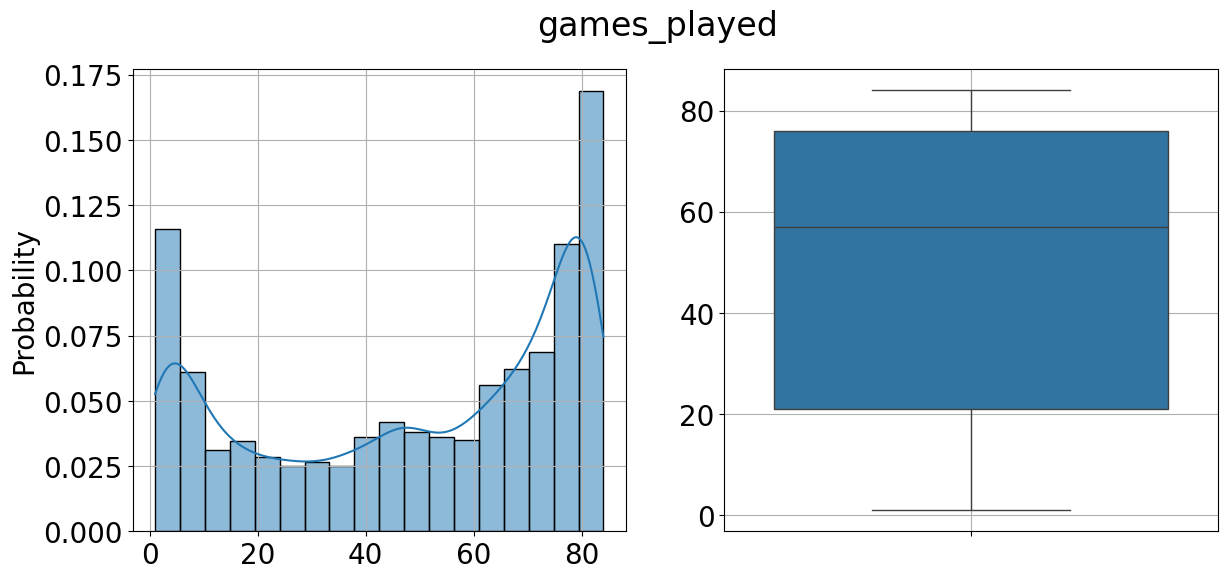

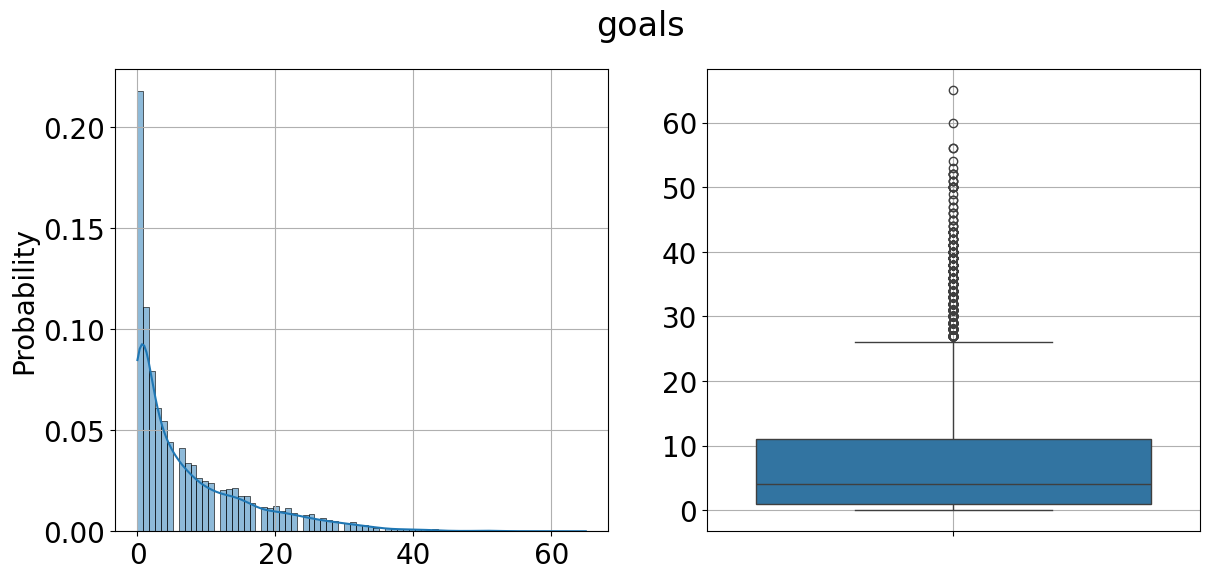

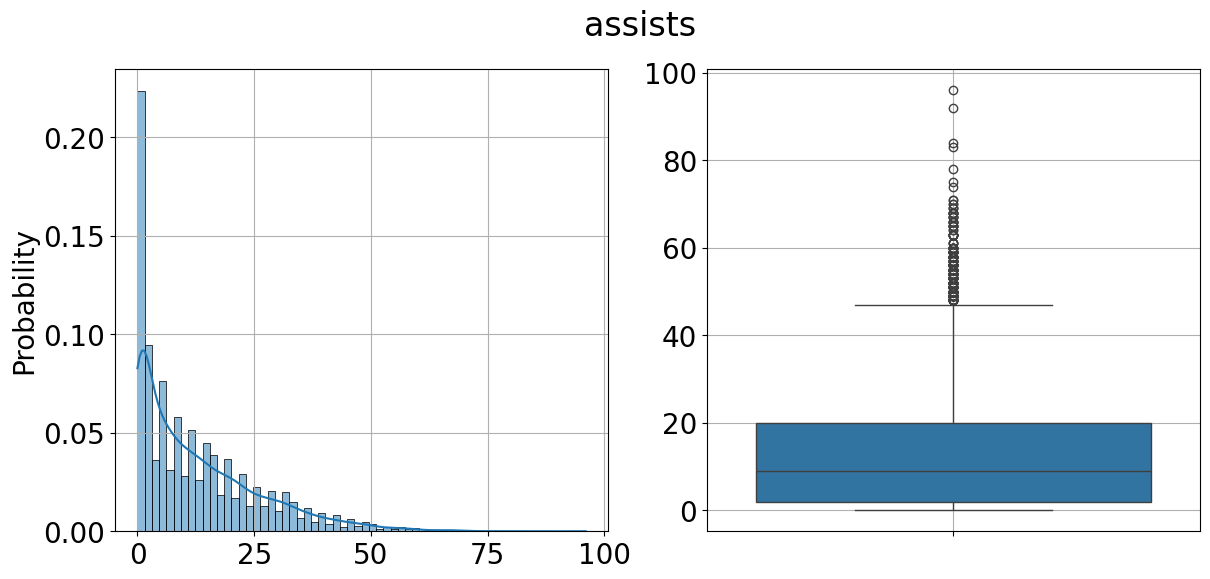

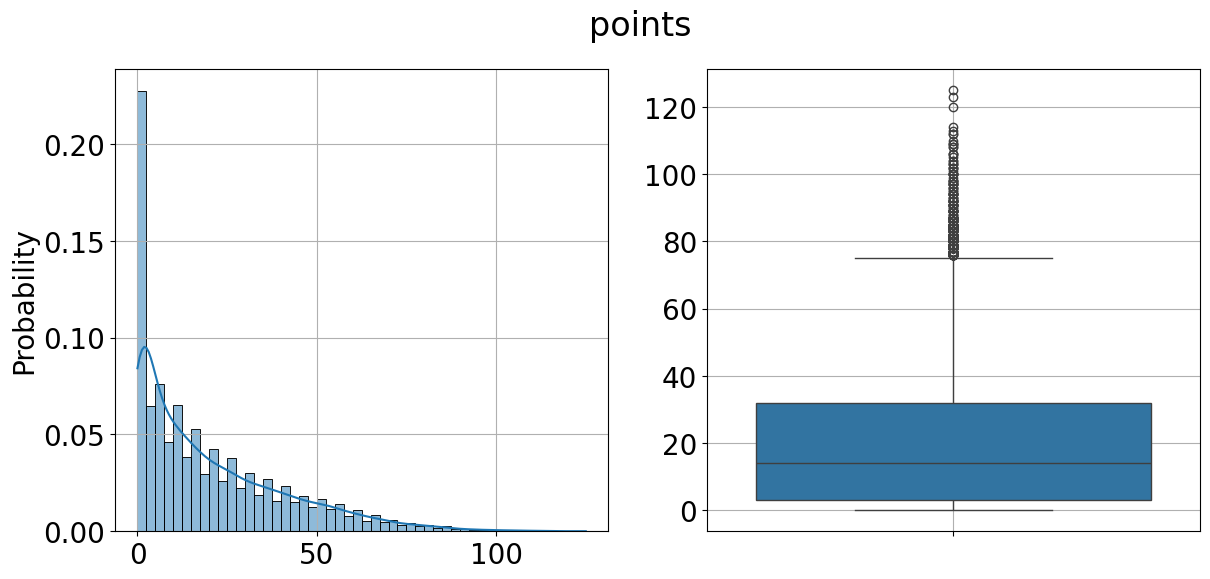

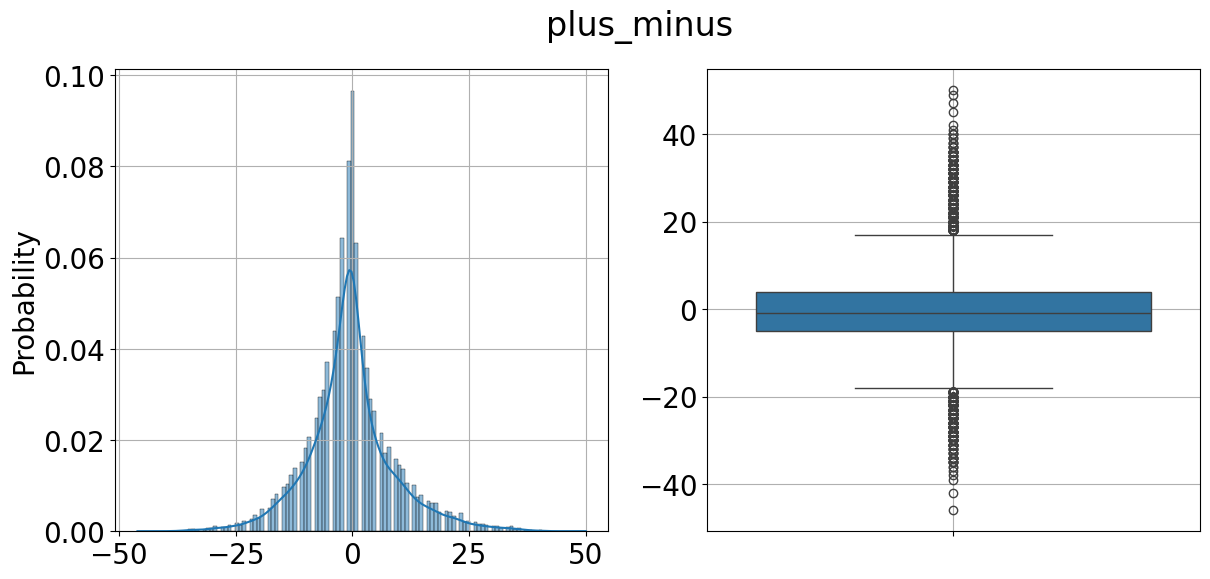

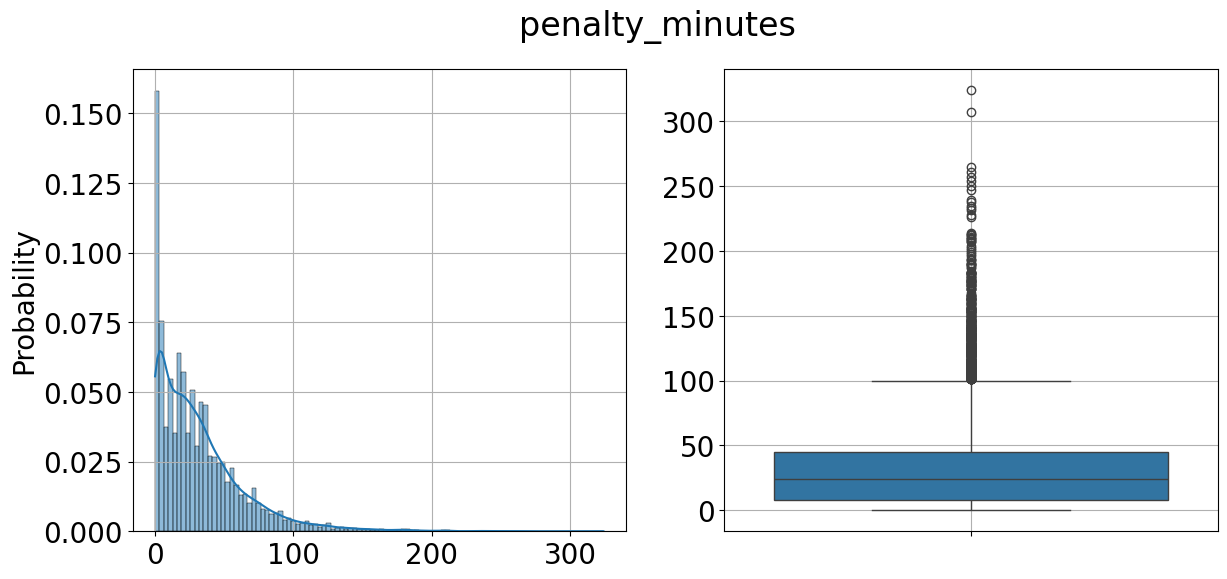

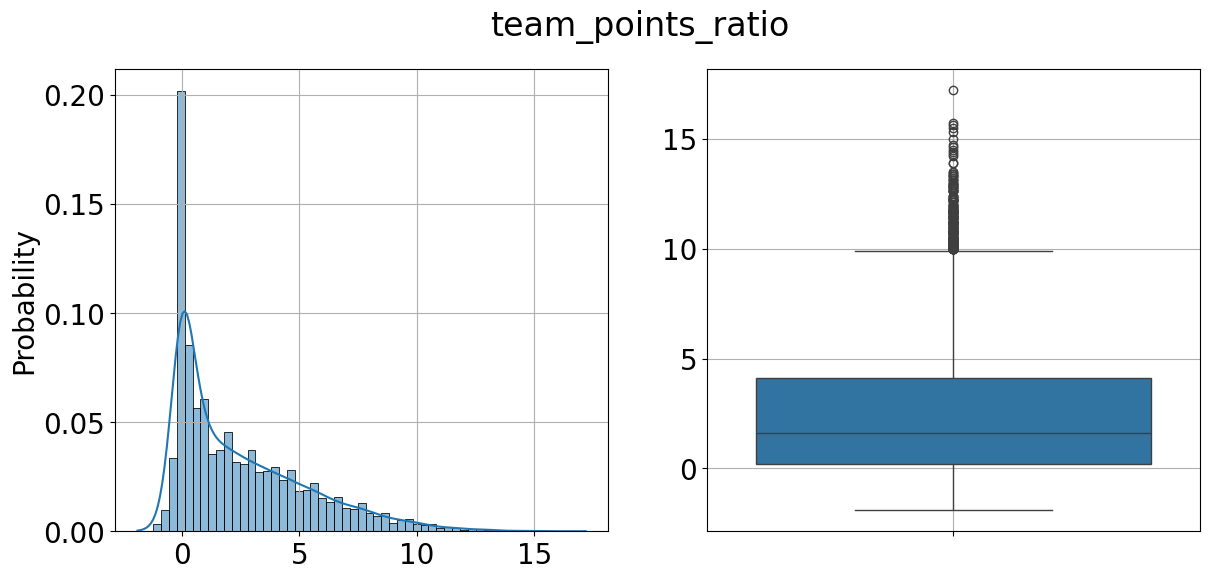

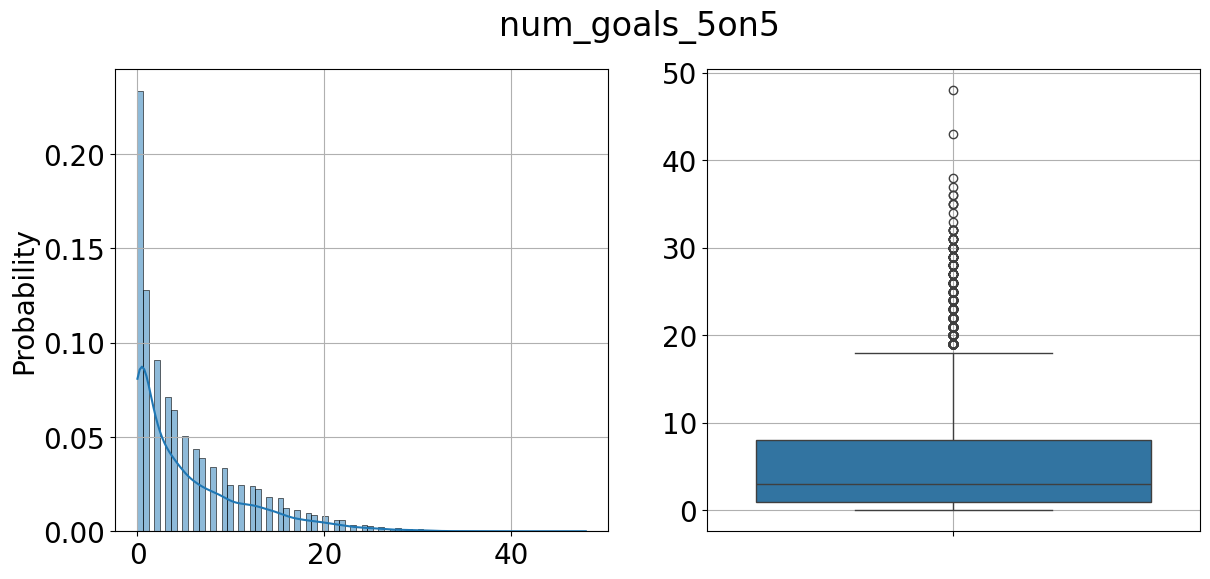

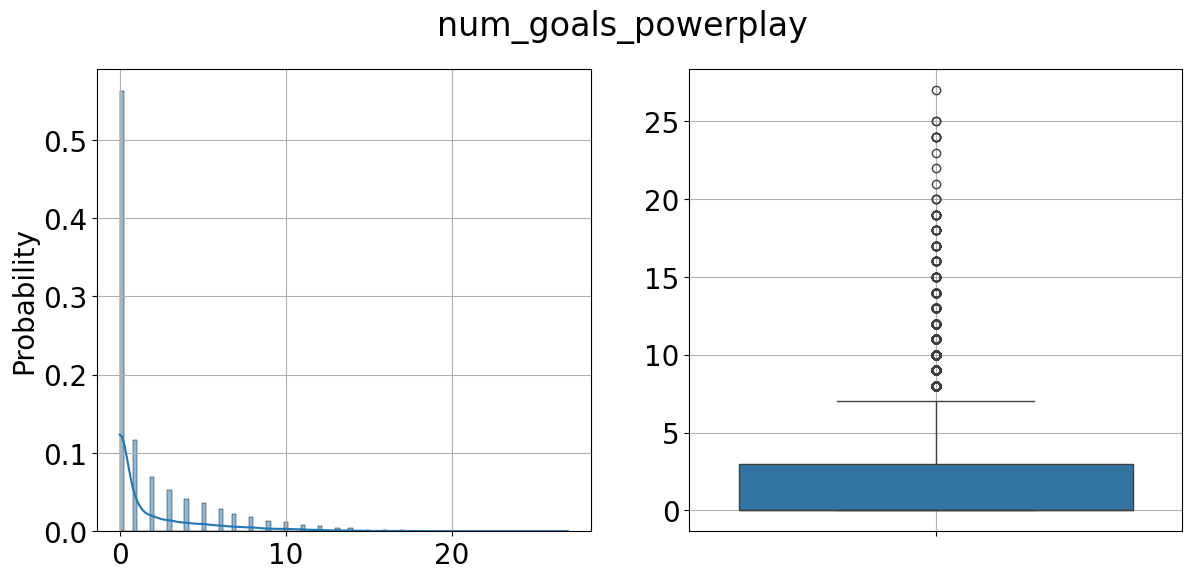

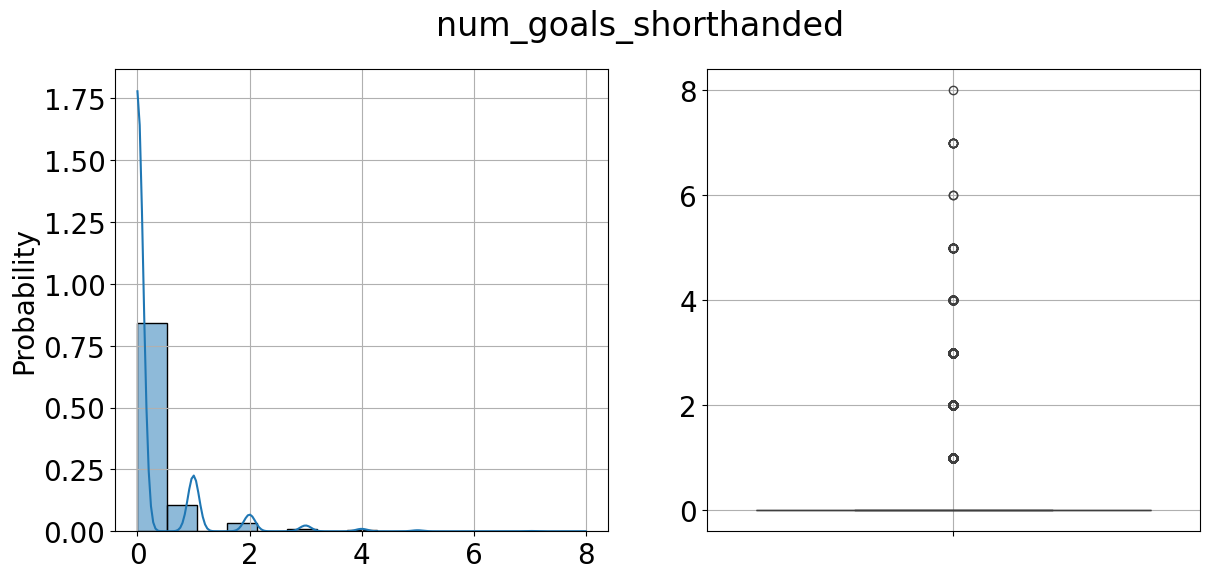

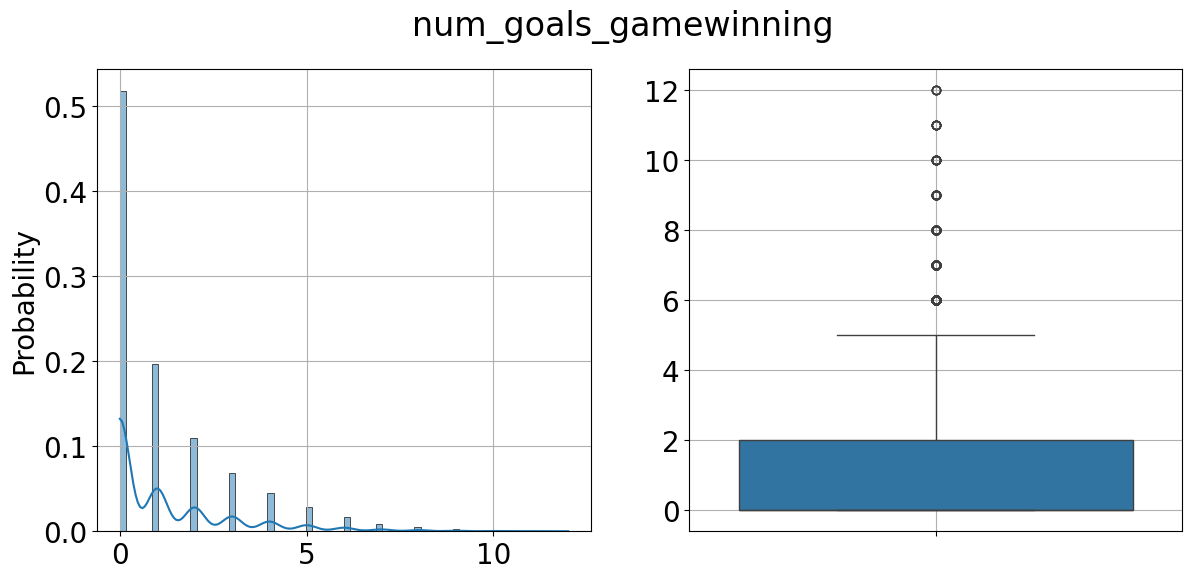

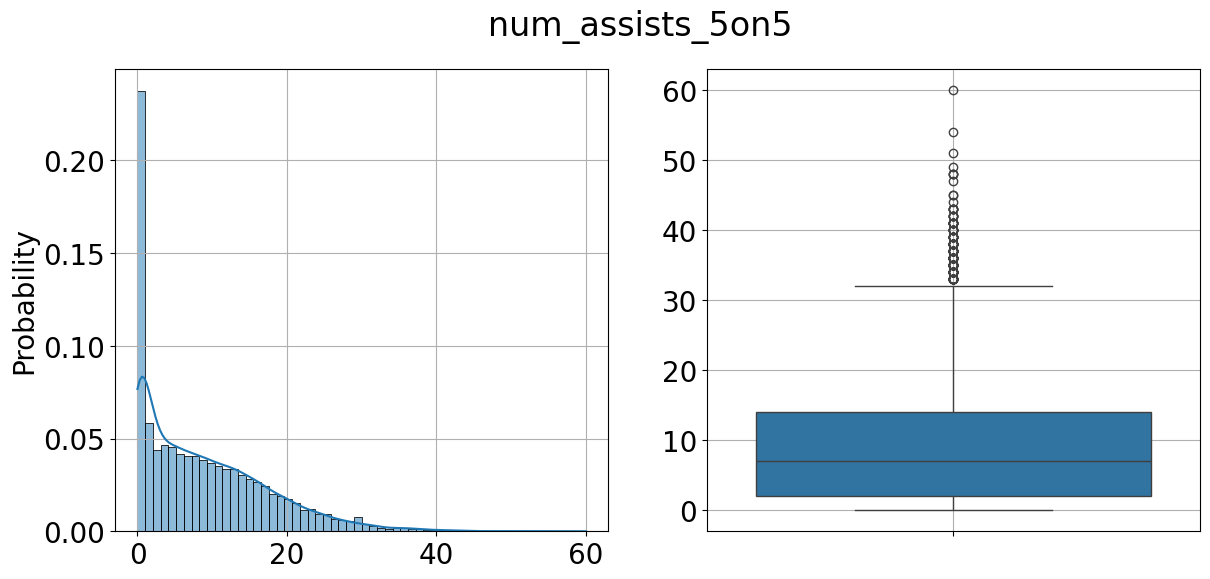

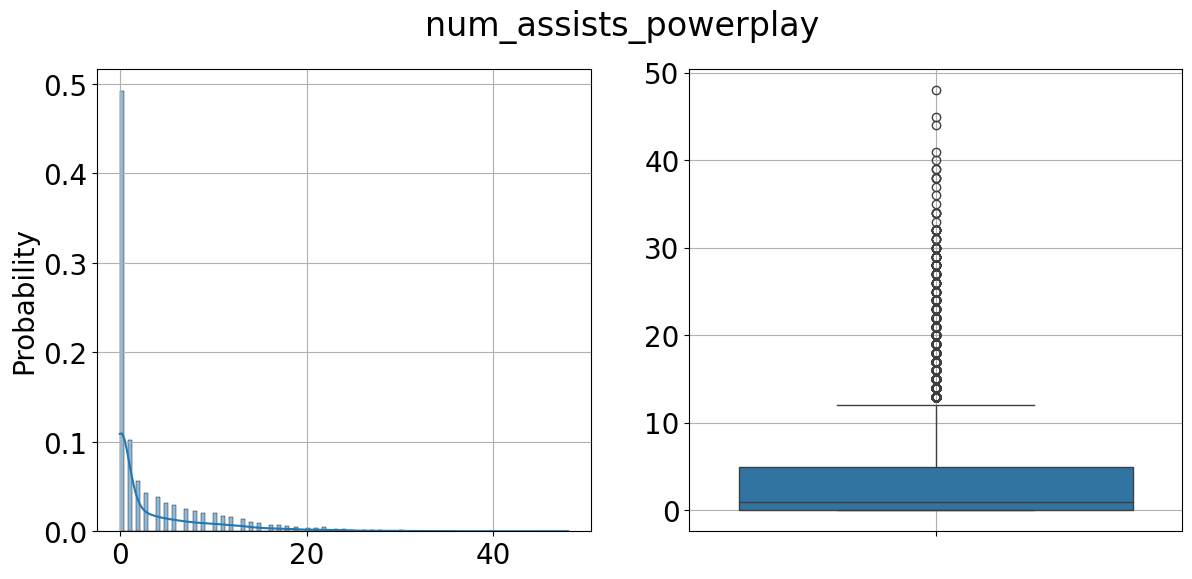

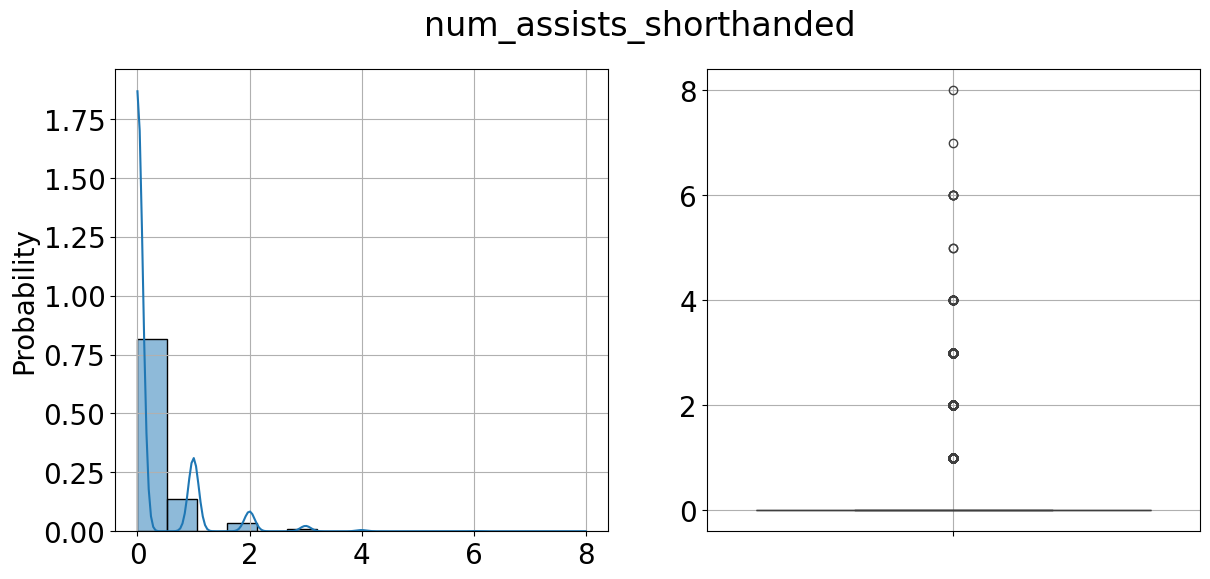

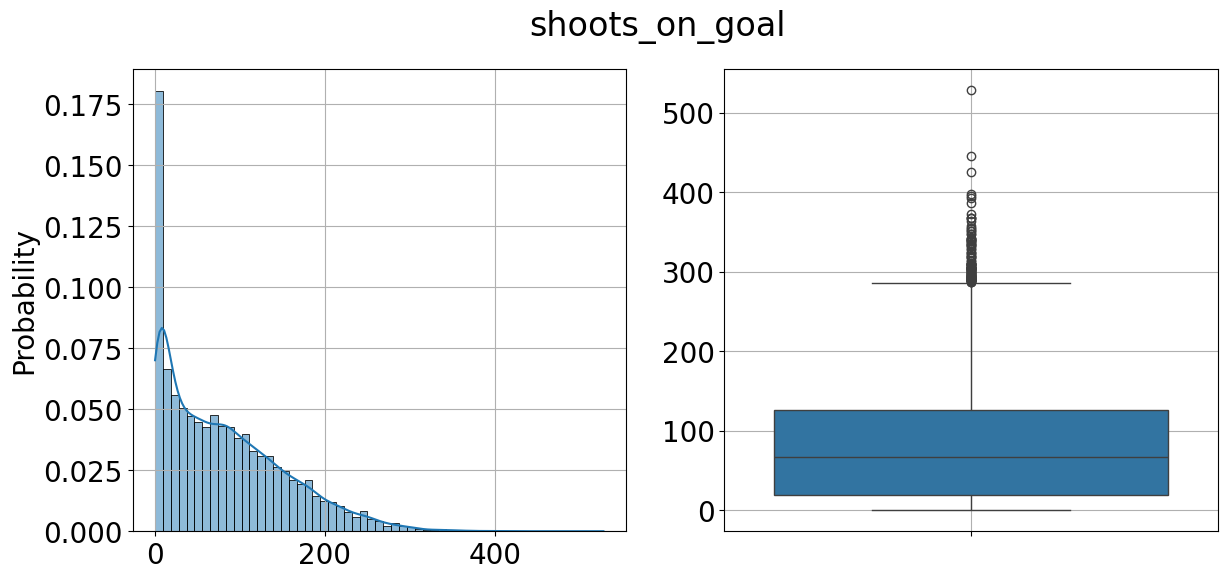

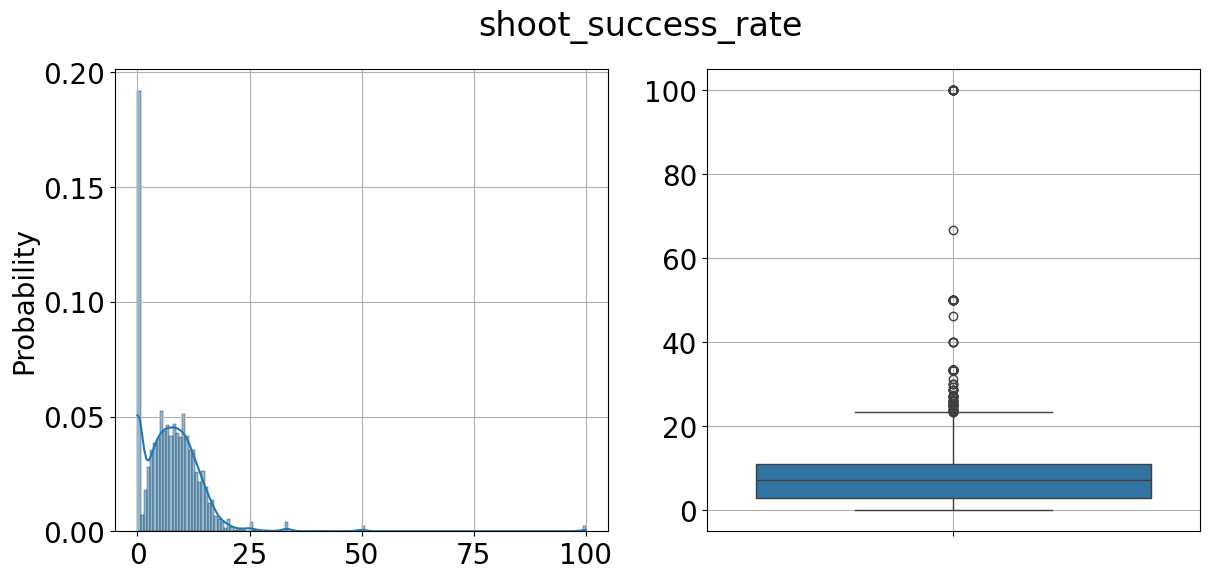

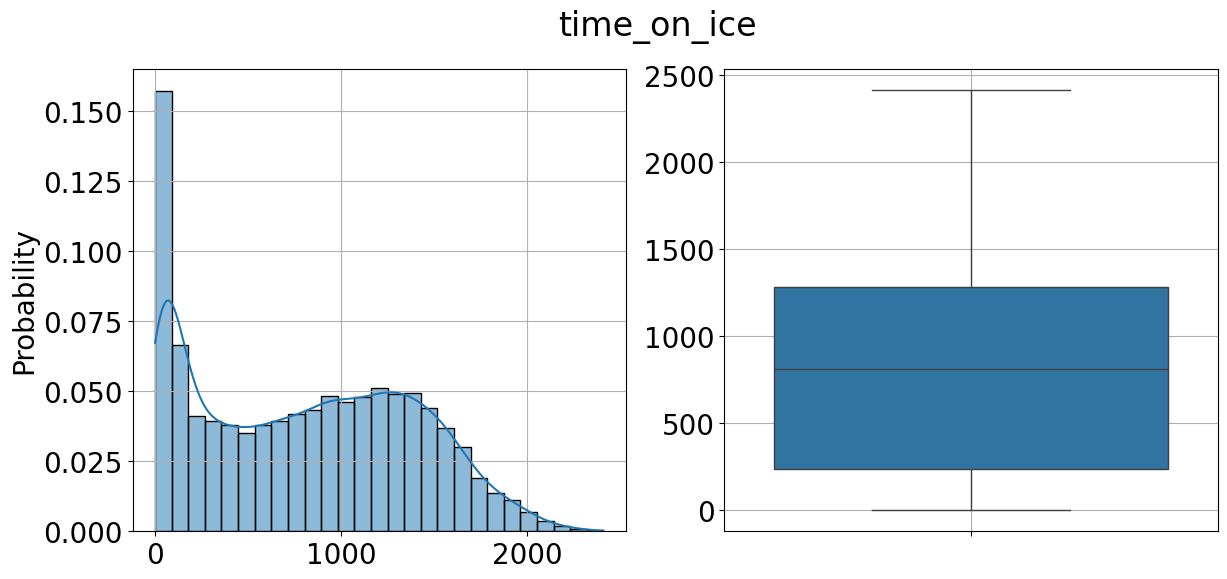

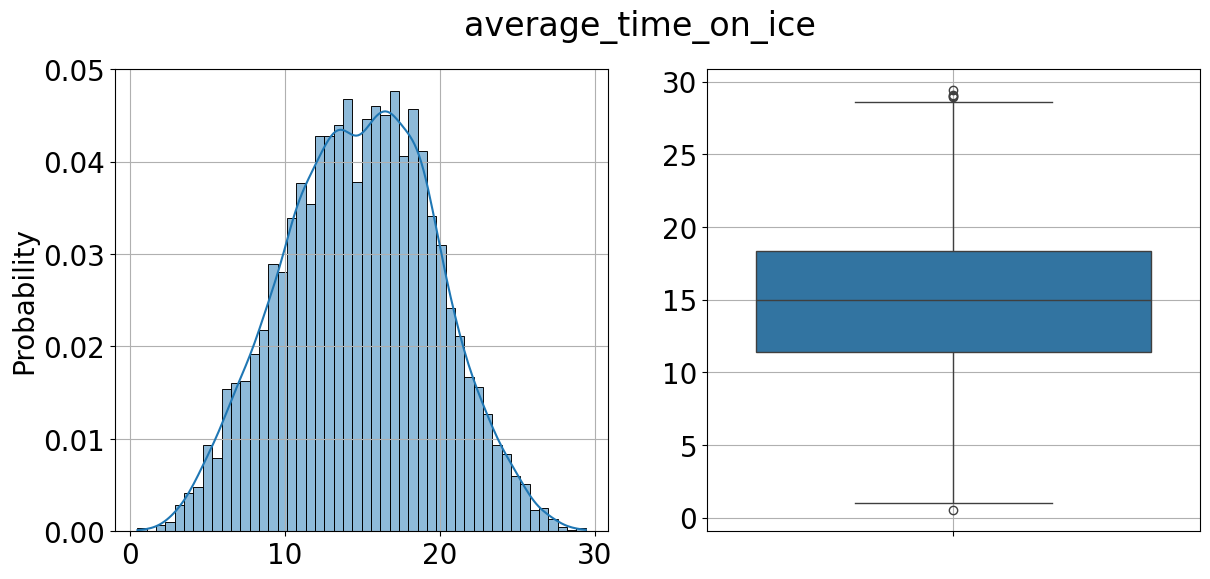

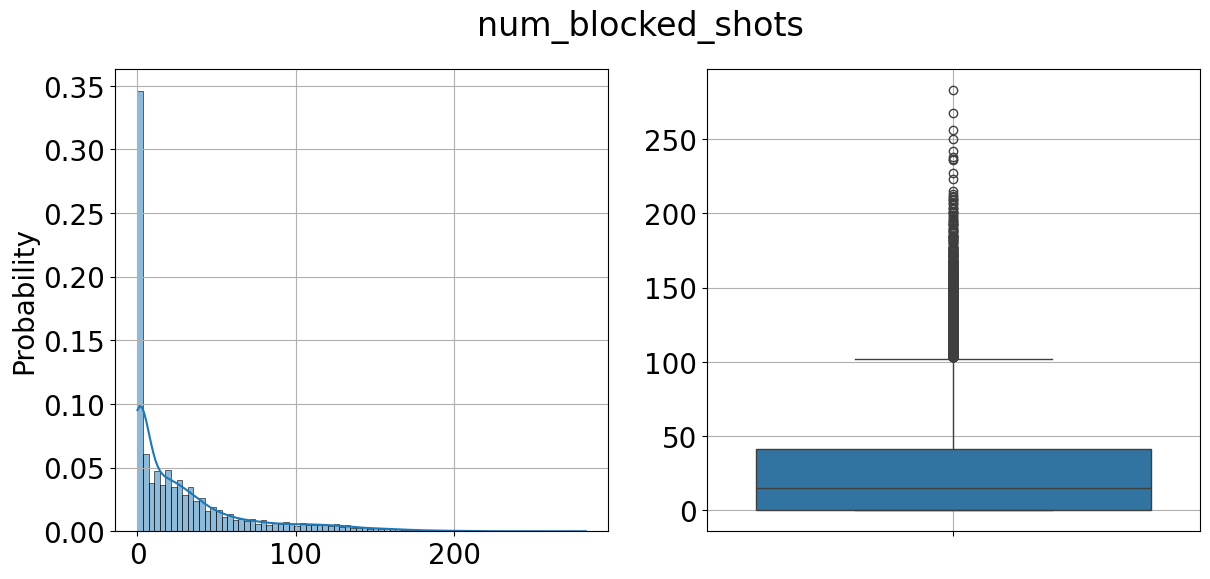

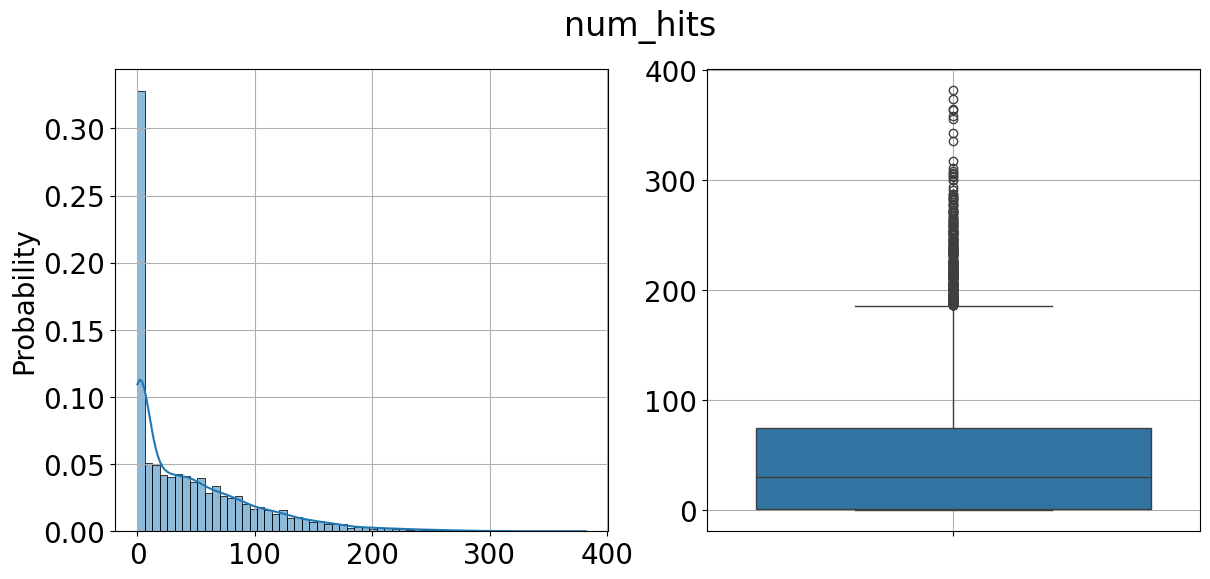

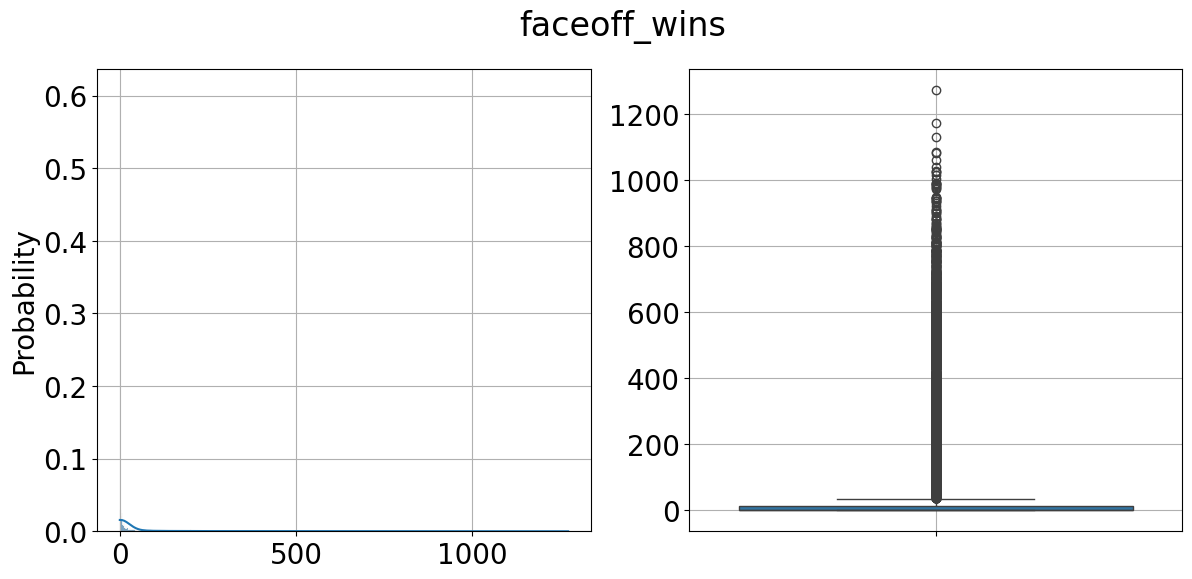

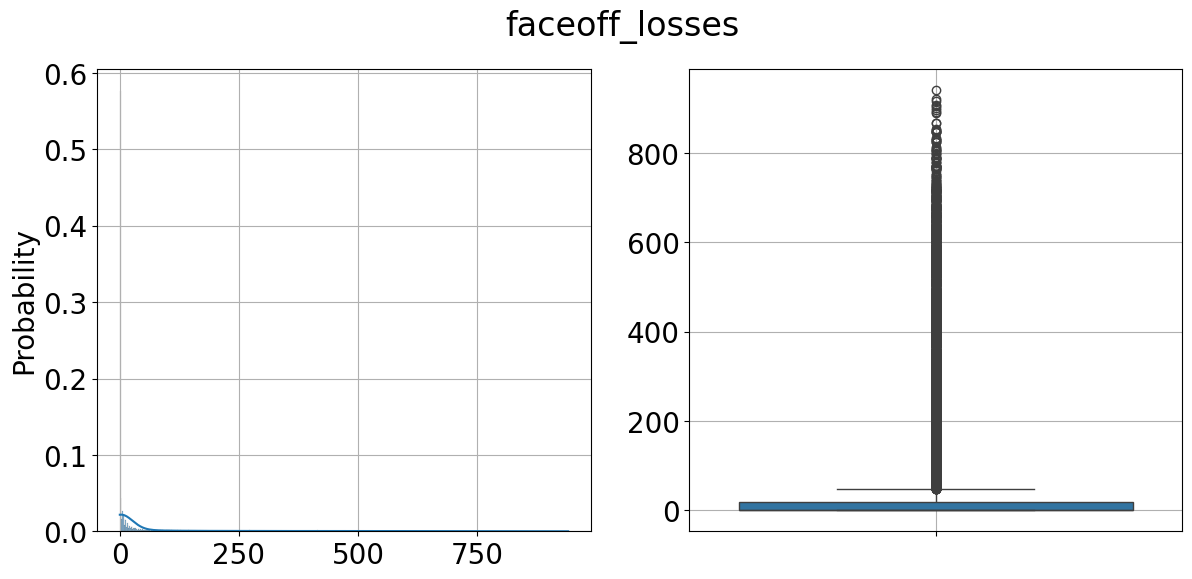

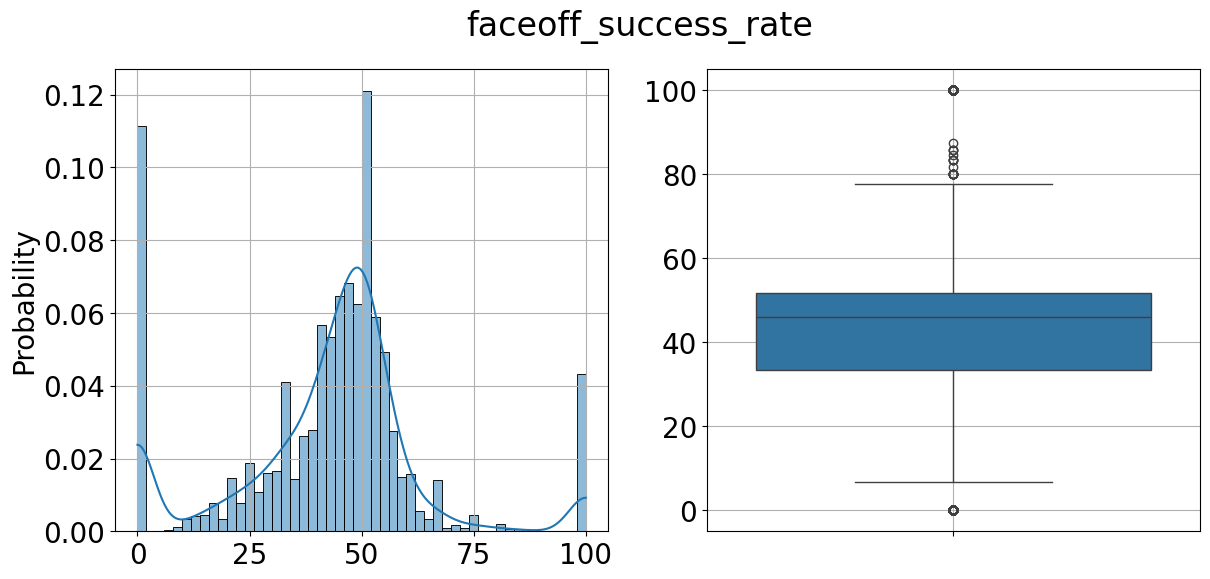

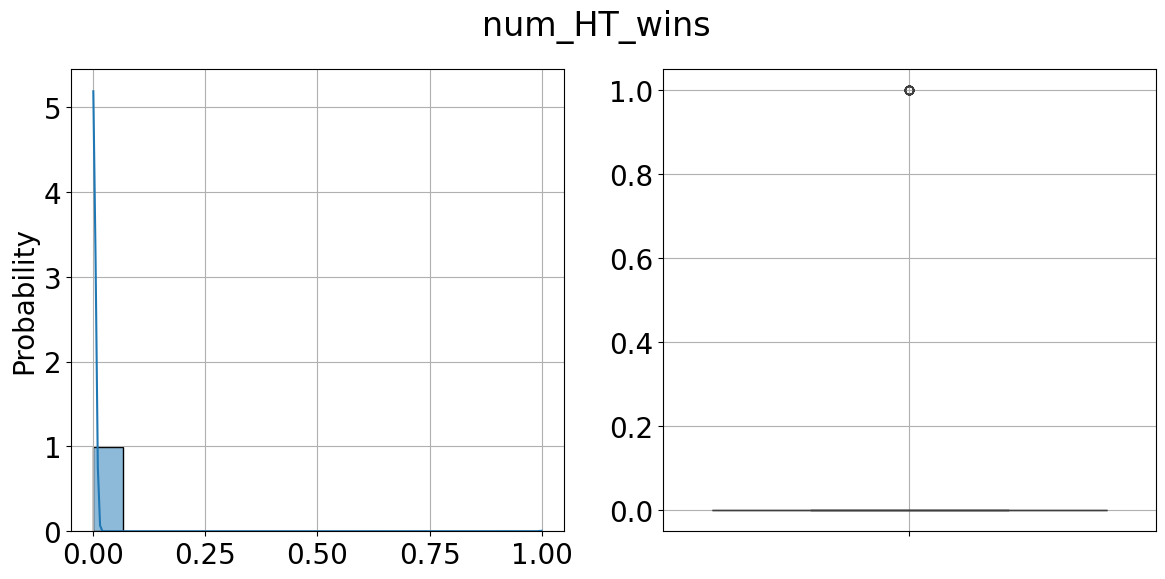

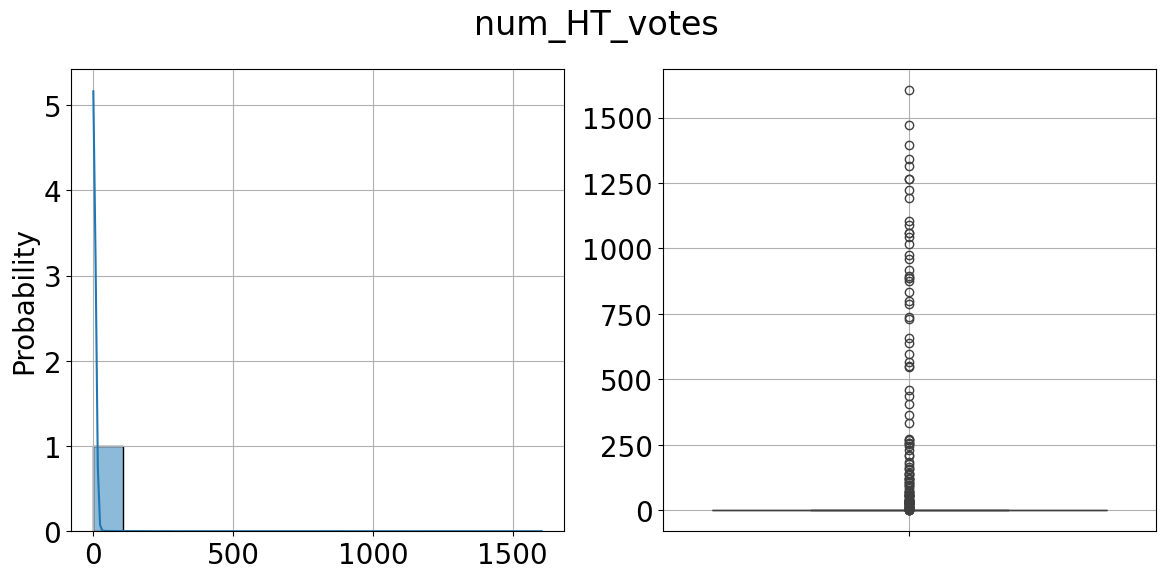

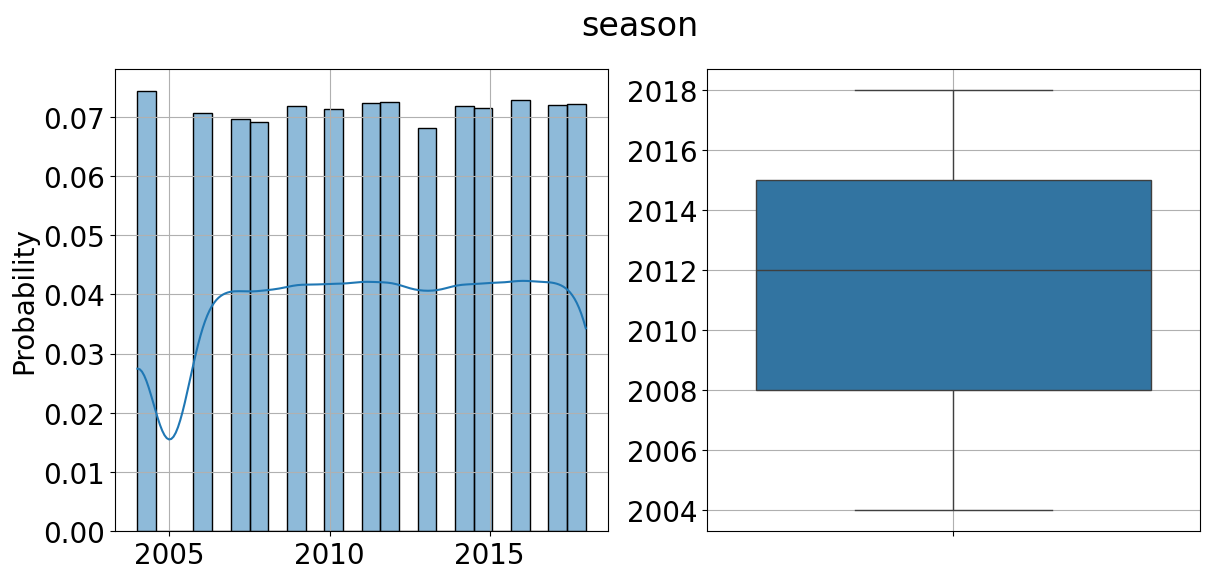

In [75]:
plt.rcParams['font.size'] = 20

for col in player_df.select_dtypes([np.float64, np.int64]):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    sns.histplot(player_df[col], ax=ax[0], stat='probability', kde=True)
    sns.boxplot(player_df[~player_df[col].isna()][col], ax=ax[1])
    ax[0].set_xlabel('')
    ax[1].set_ylabel('')

    for _ax in ax:
        _ax.grid()

    fig.suptitle(col)
    plt.show(fig)
    plt.close(fig)


''

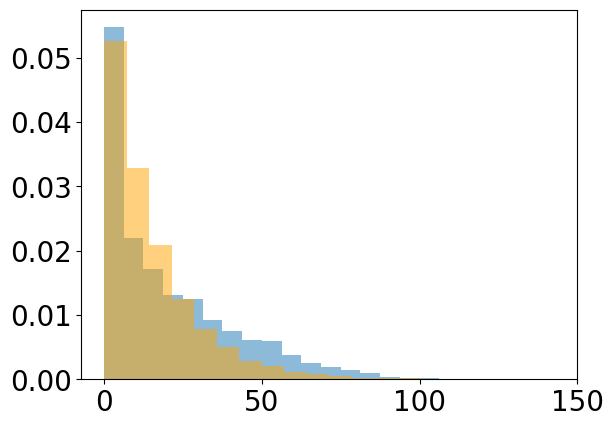

In [64]:
fig, ax = plt.subplots()

sample = np.random.exponential(scale=15, size=10_000)
bin = np.arange(0,150,0.1)
ax.hist(player_df['points'], bins=20, density=True, alpha=0.5)
ax.hist(sample, bins=20, density=True, color='orange', alpha=0.5)
;

We see that some attributes seem more like a log-distribution. Let's therefore plot those as such.

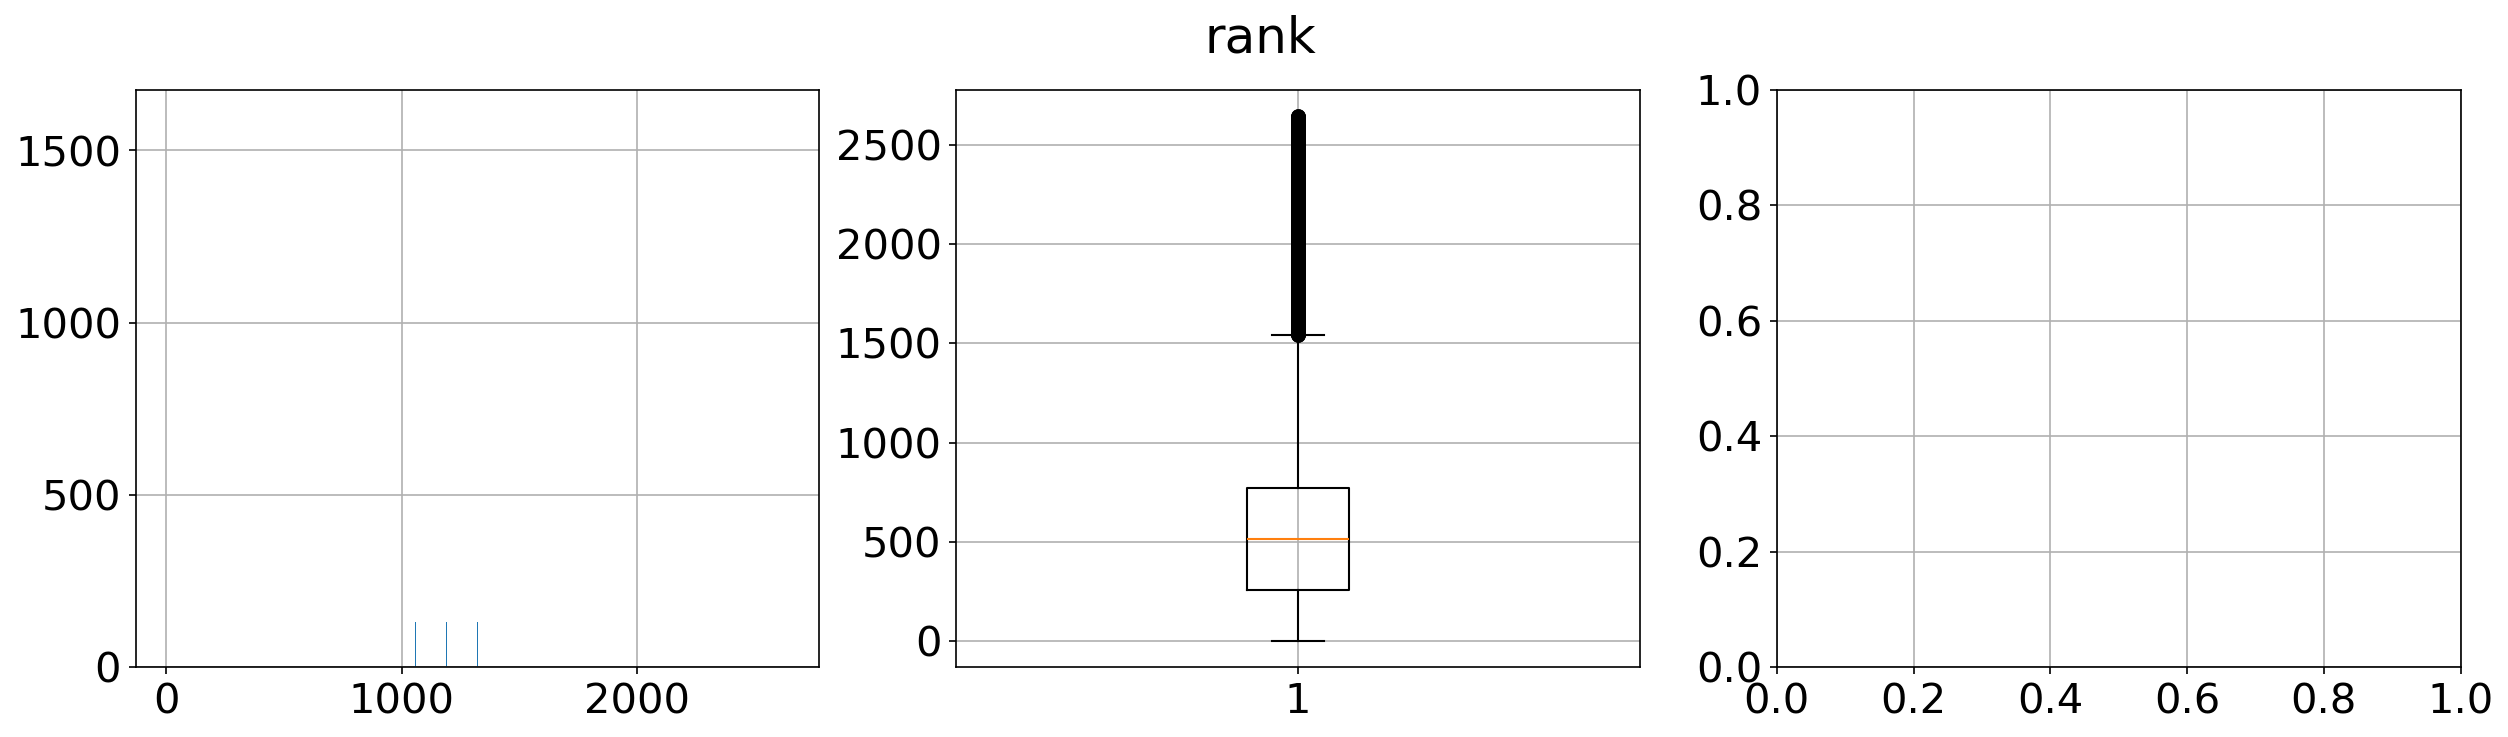

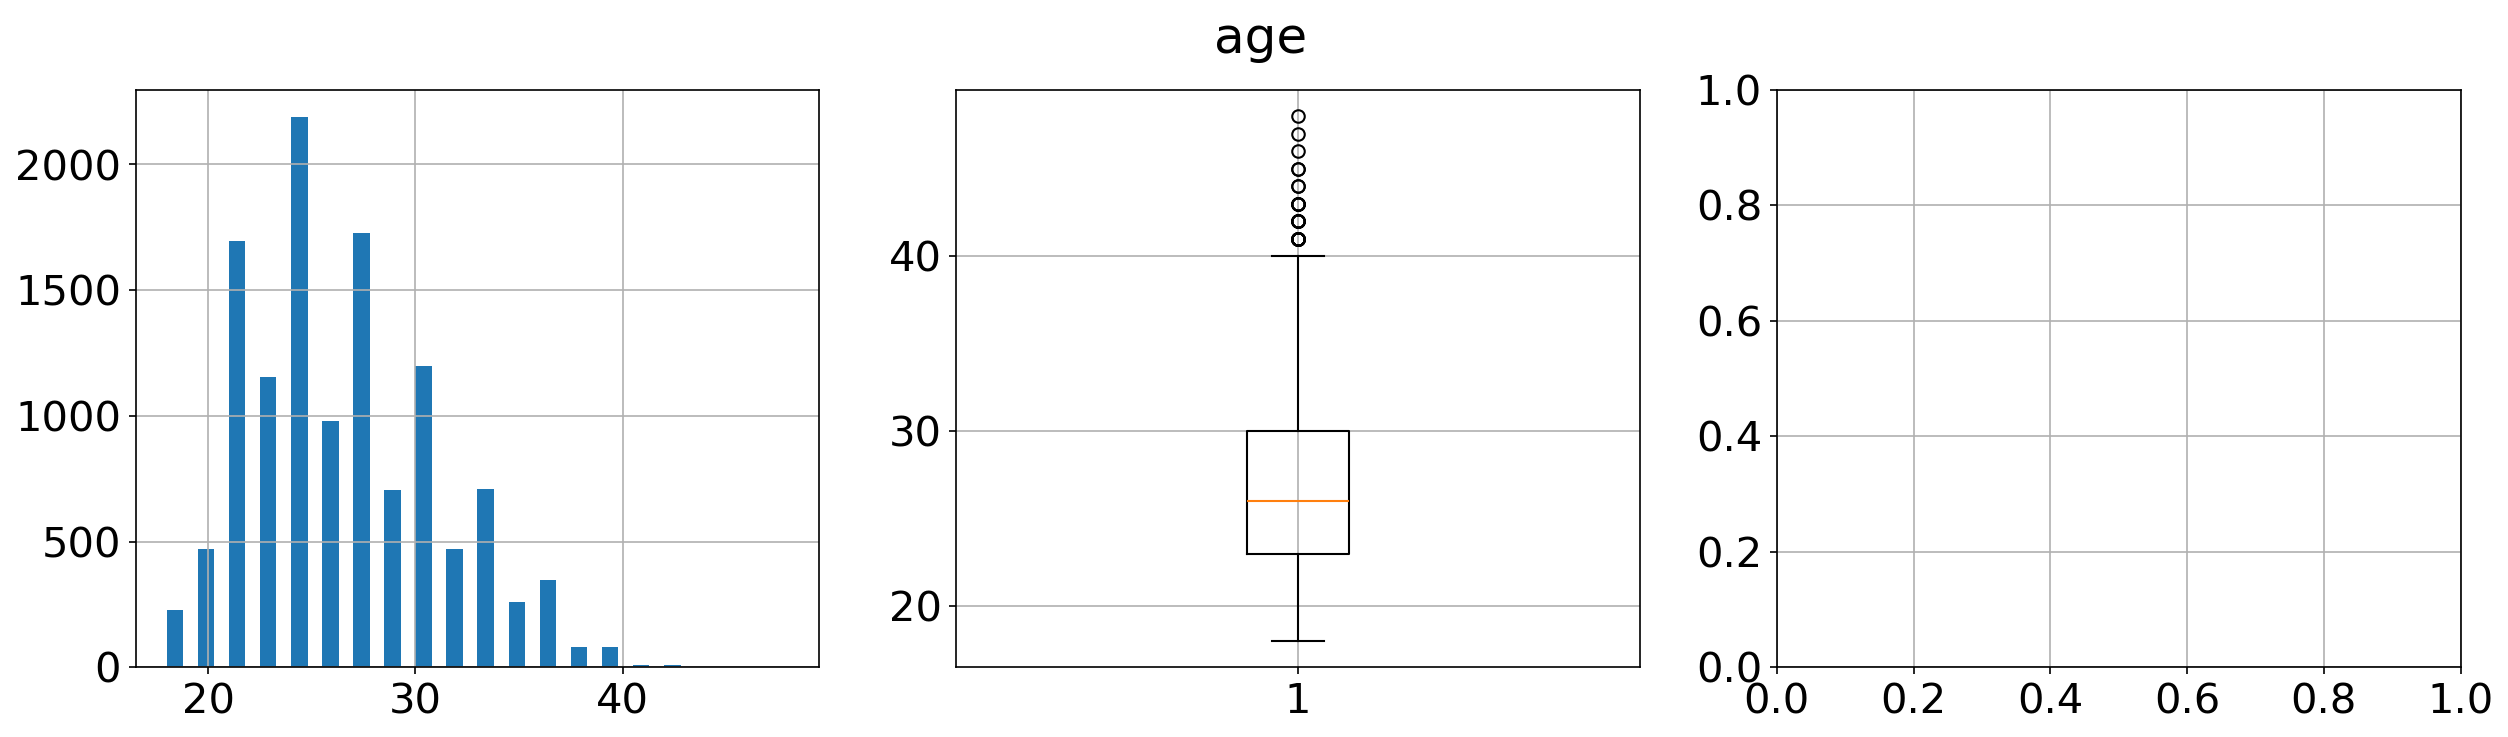

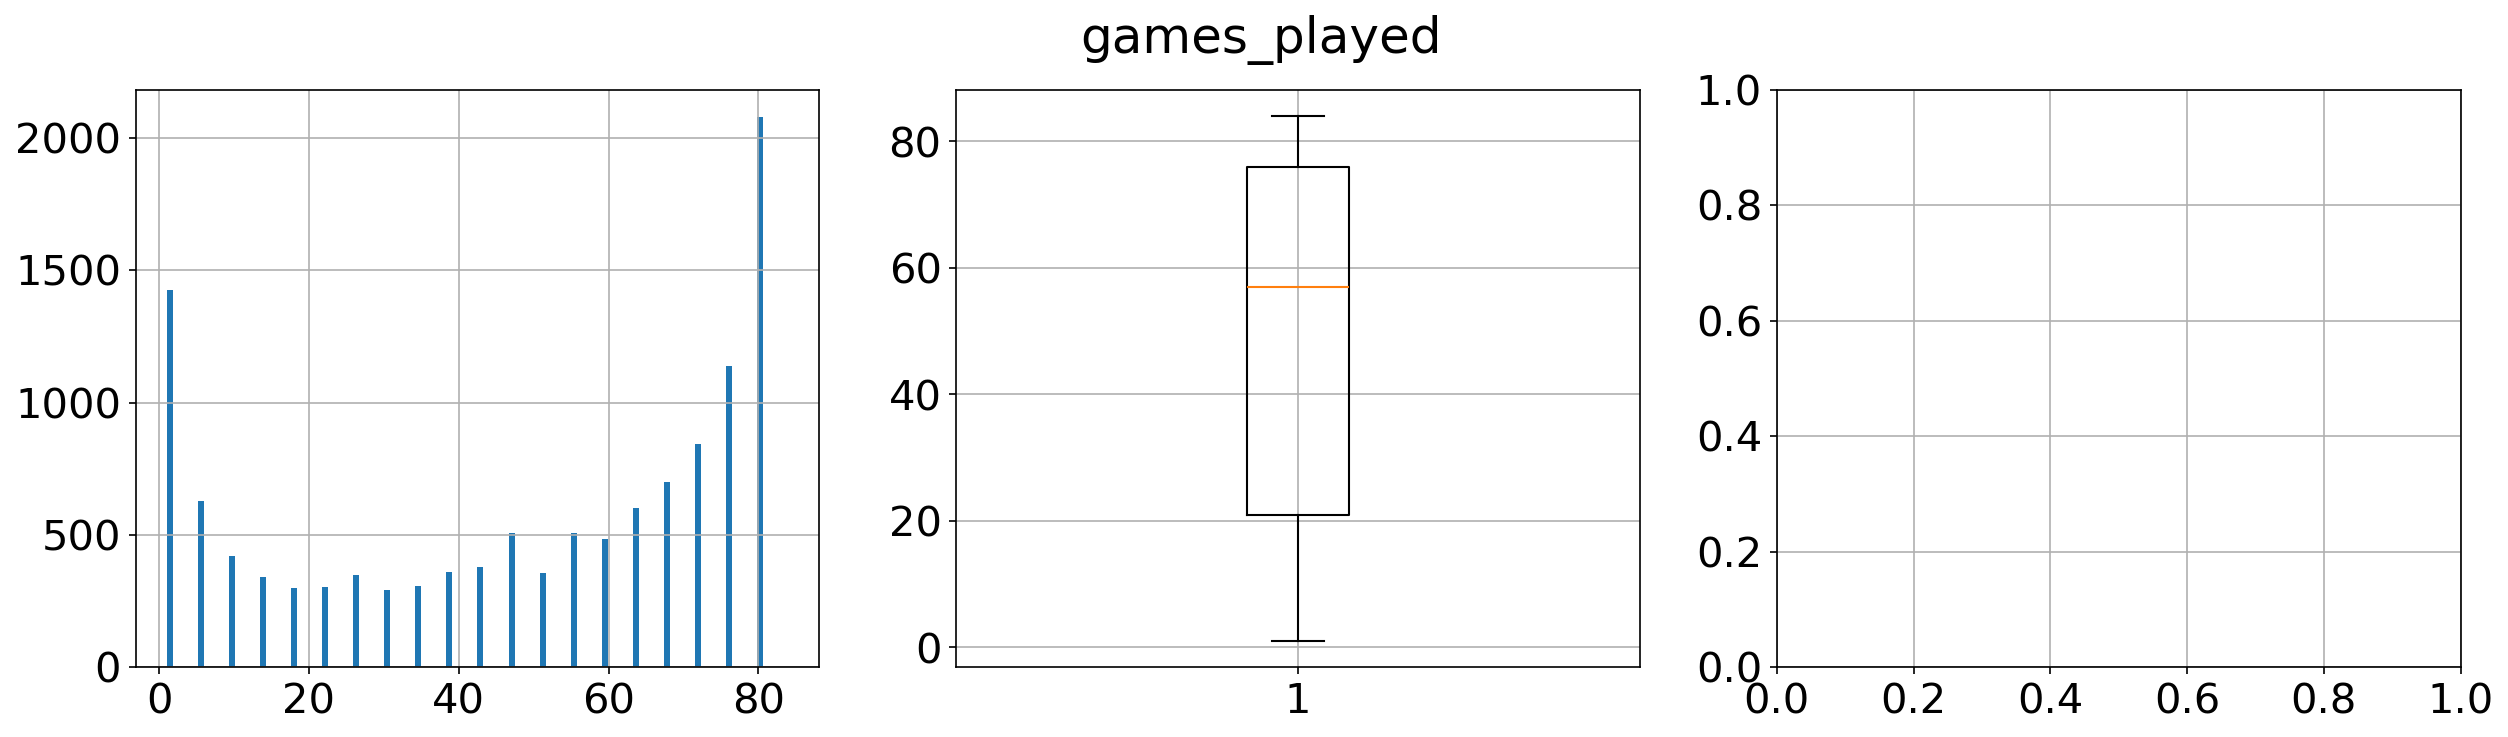

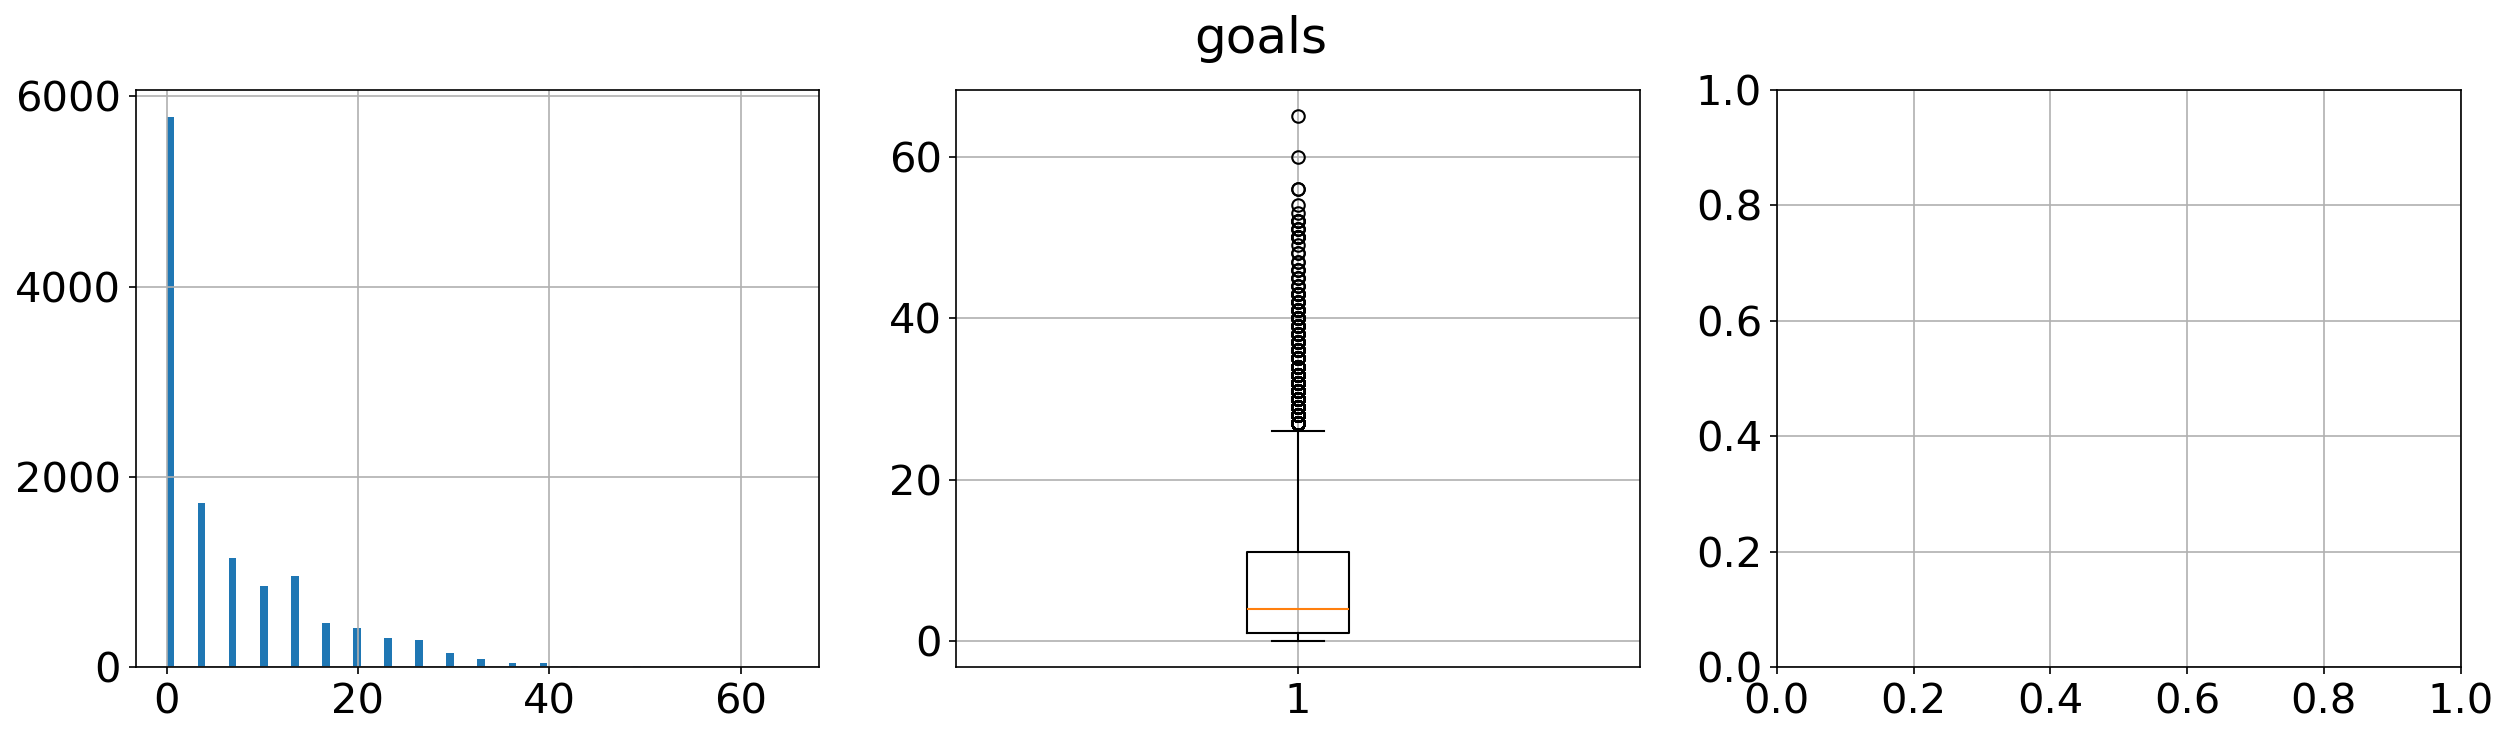

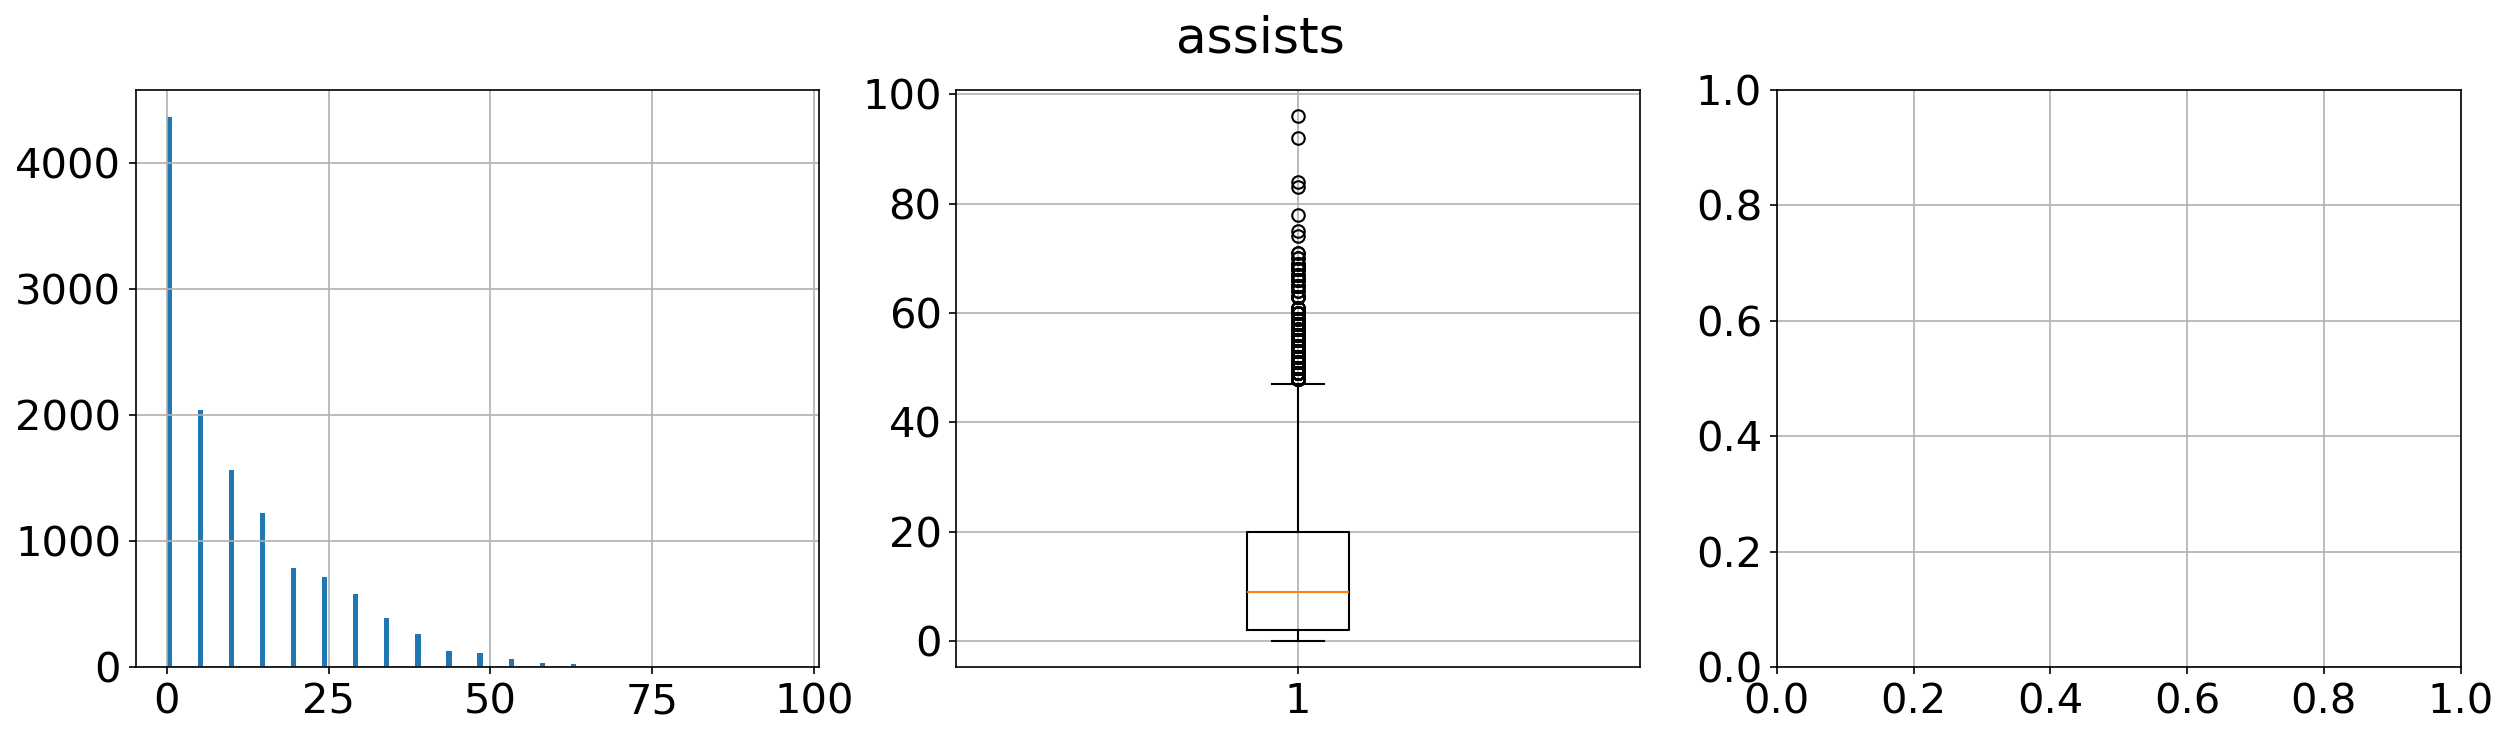

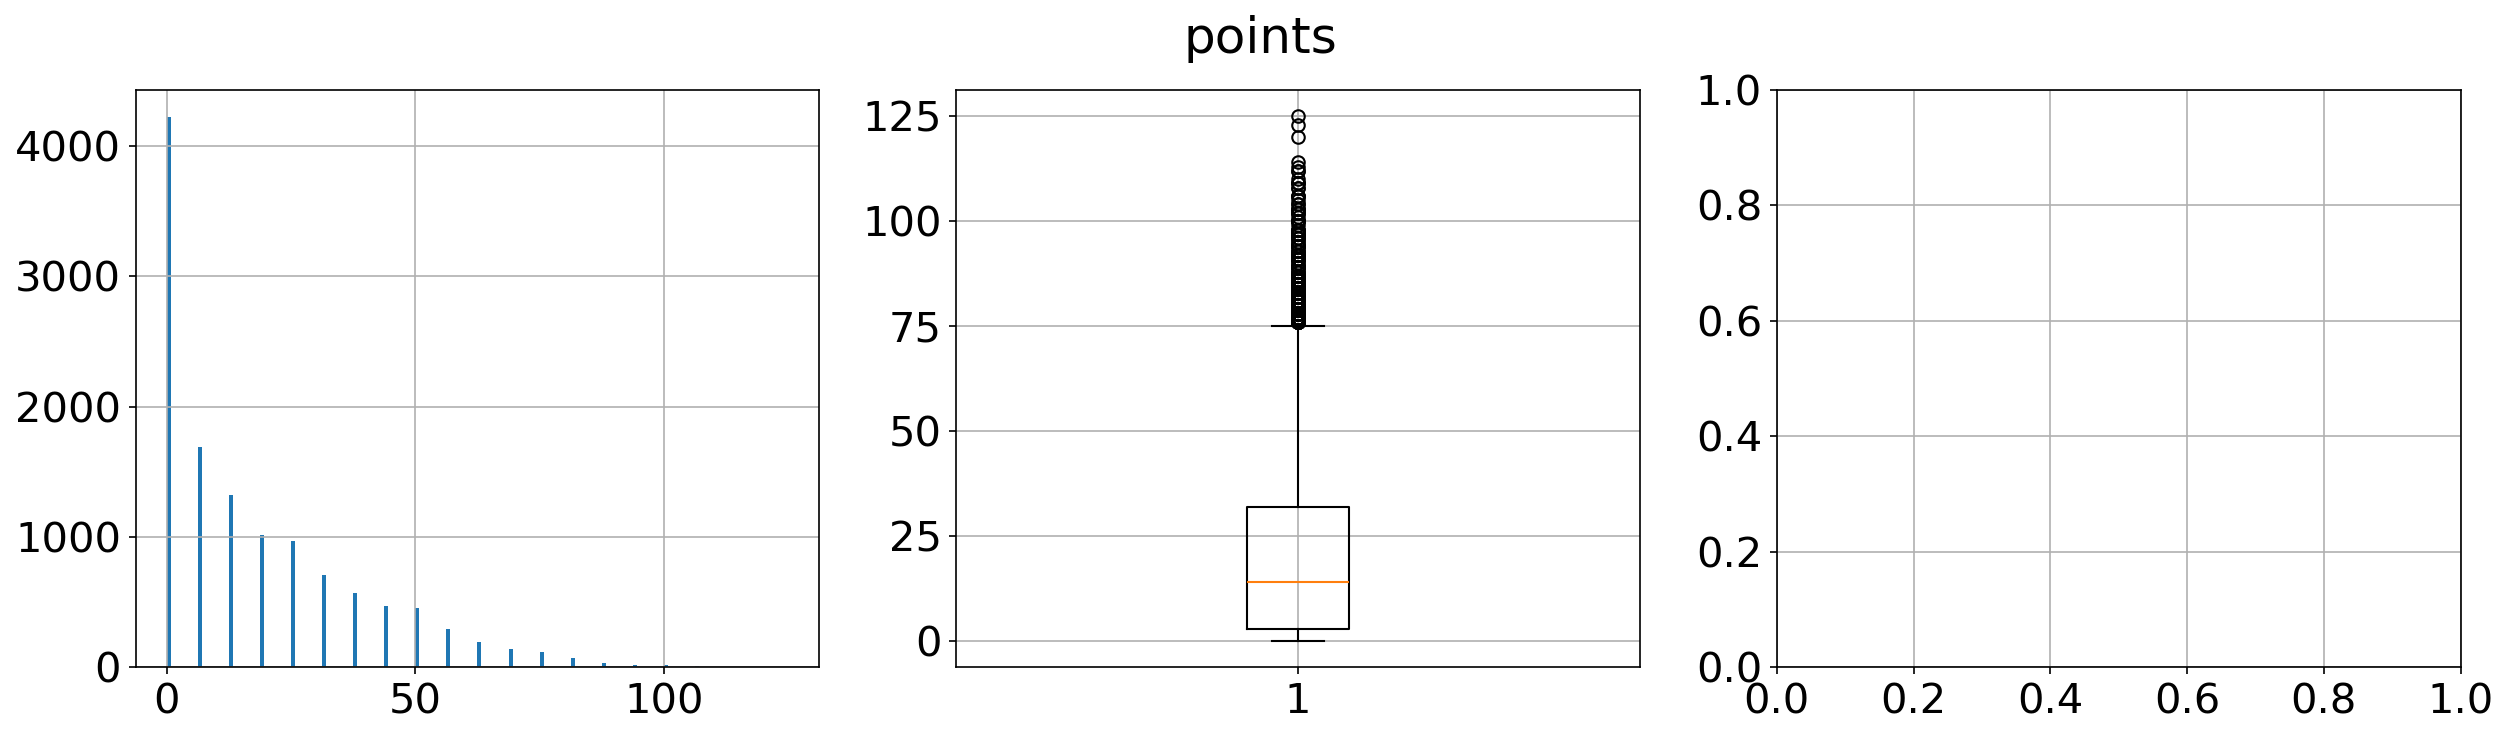

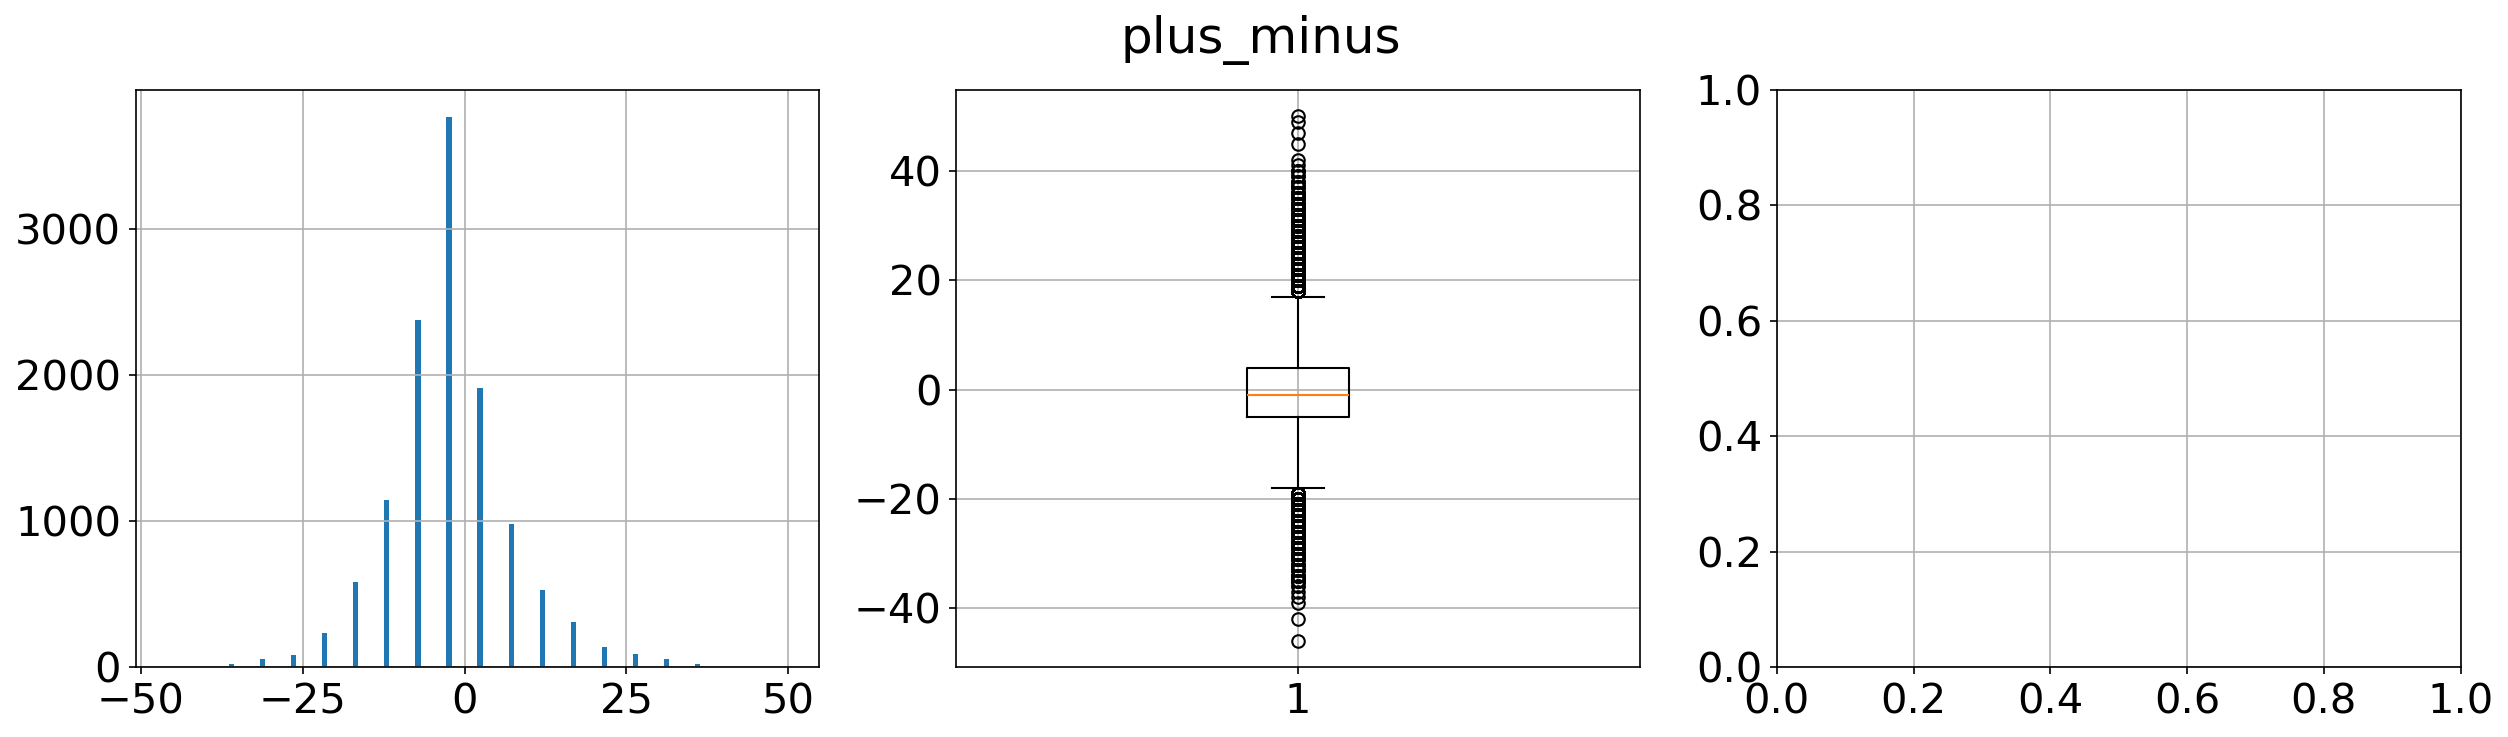

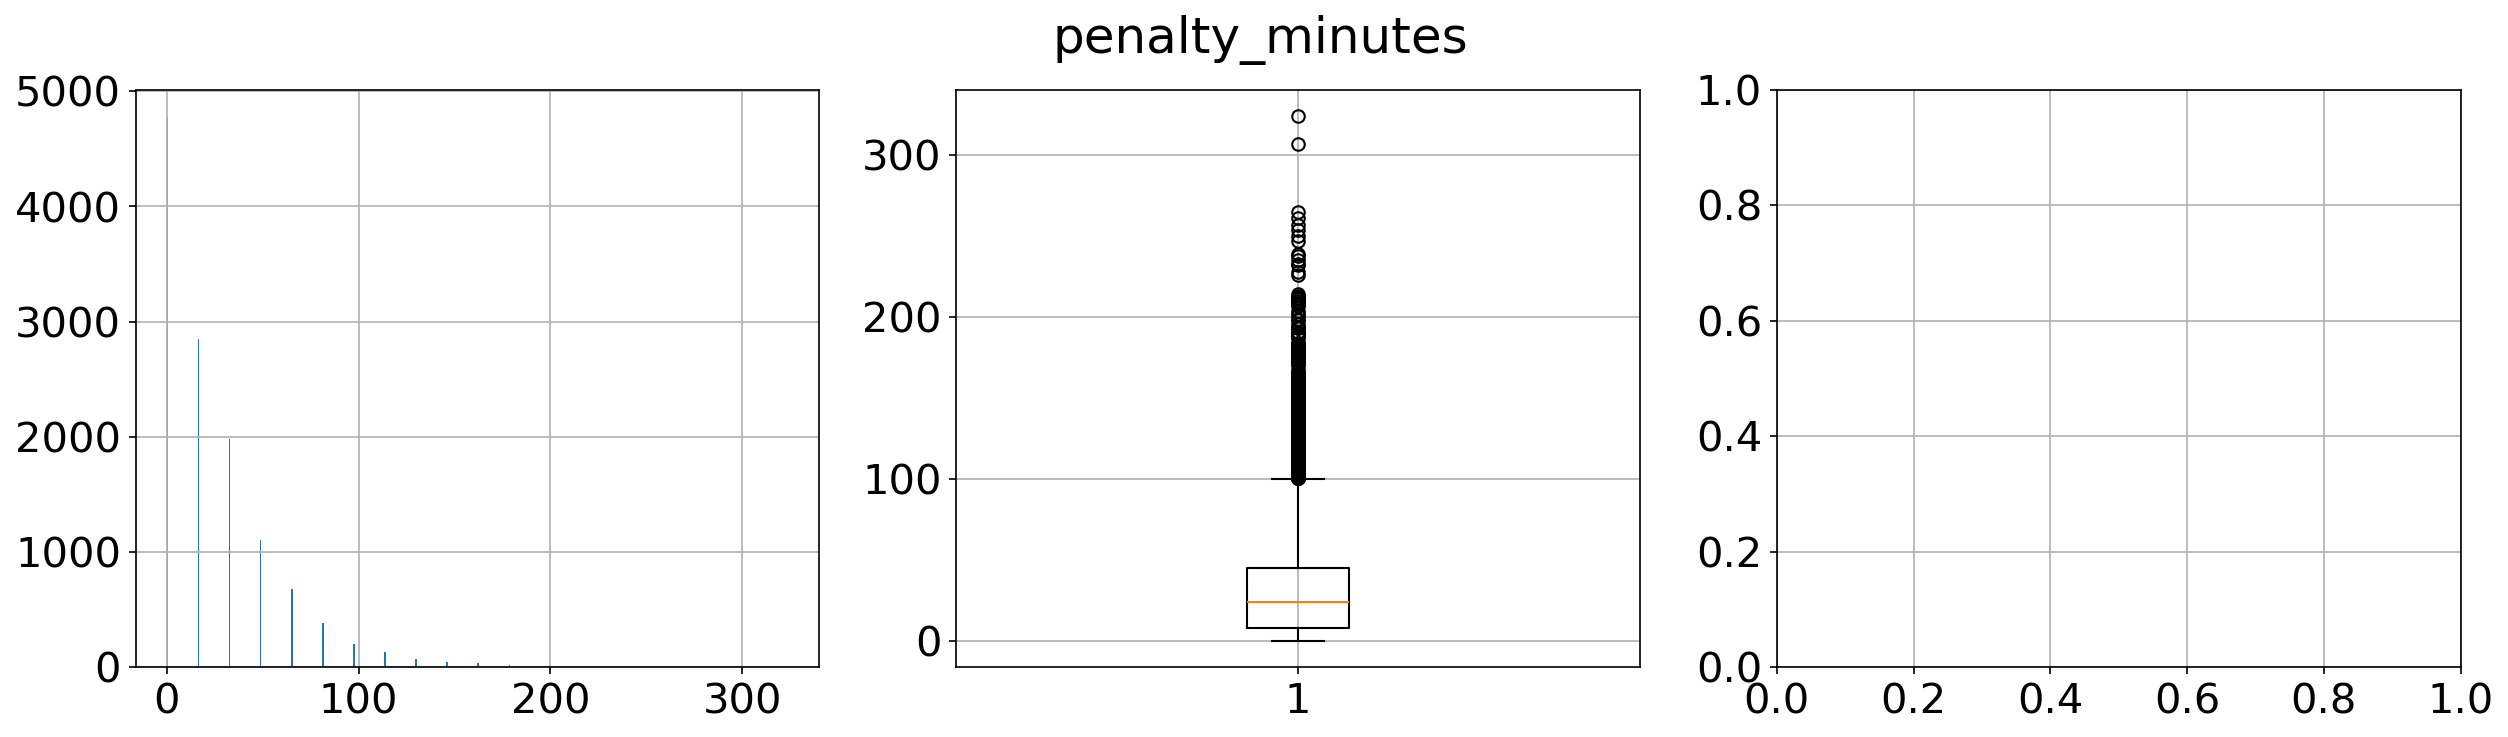

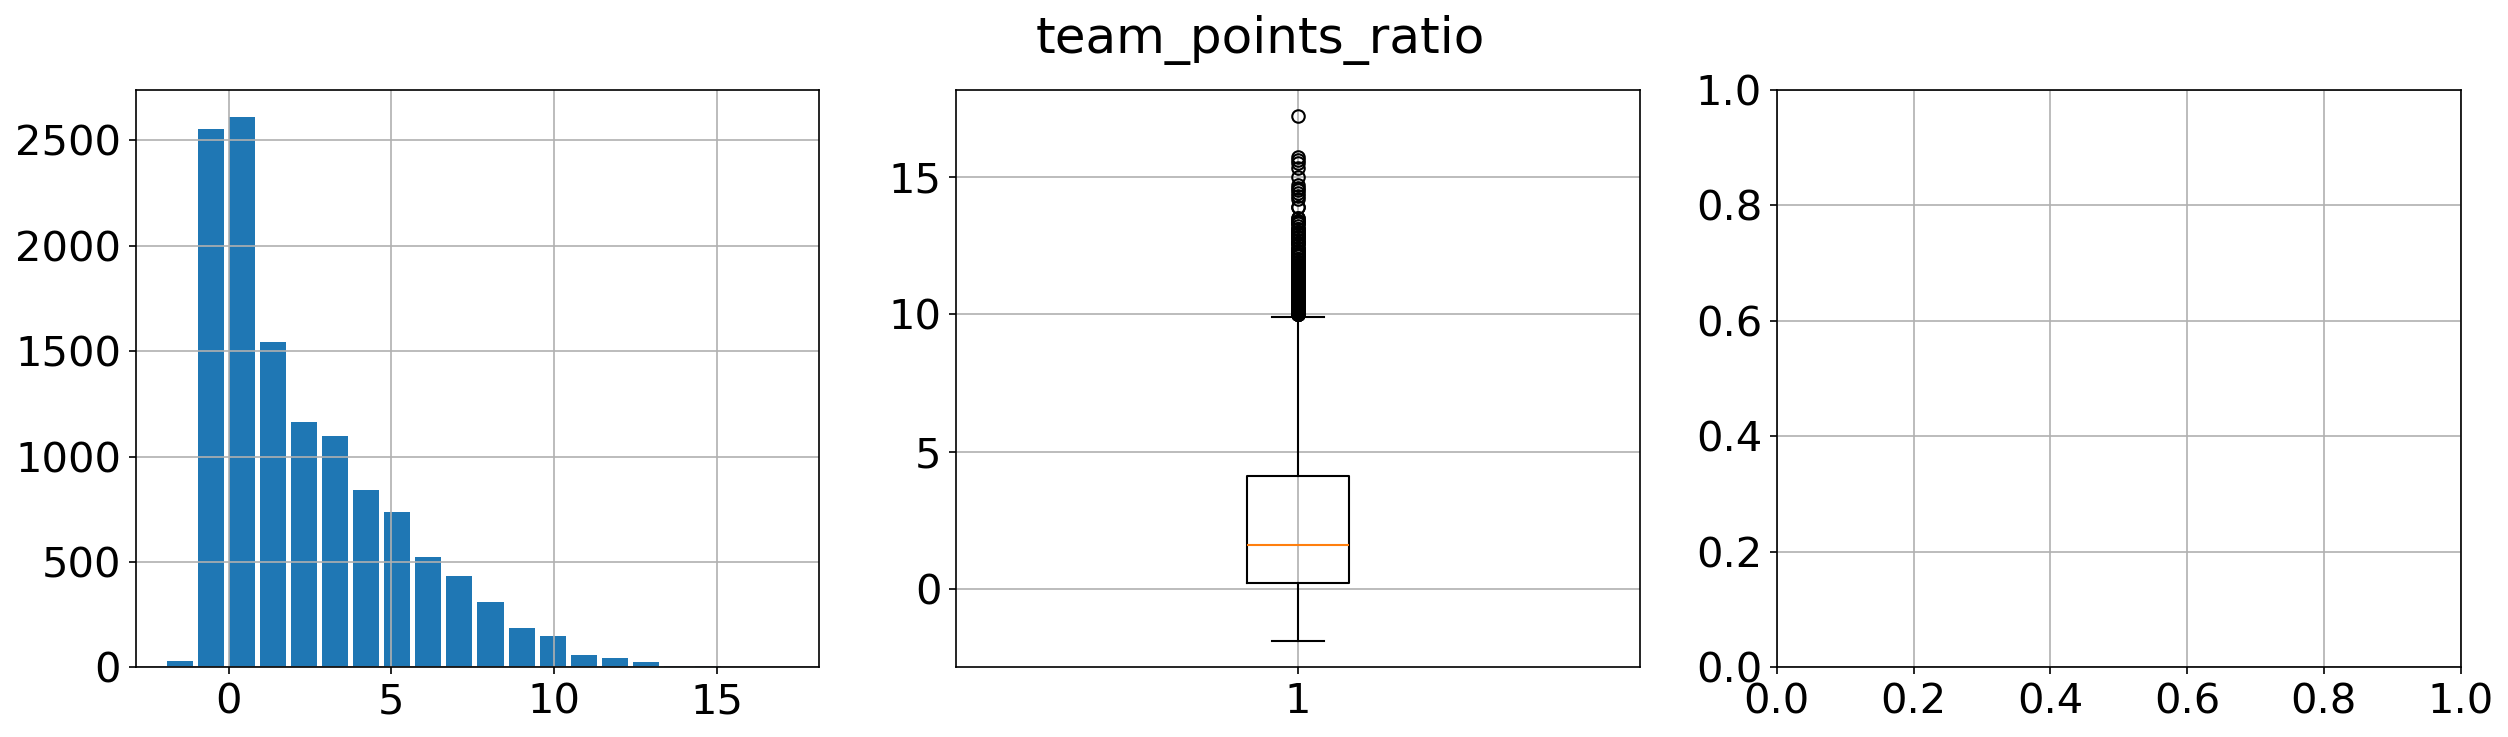

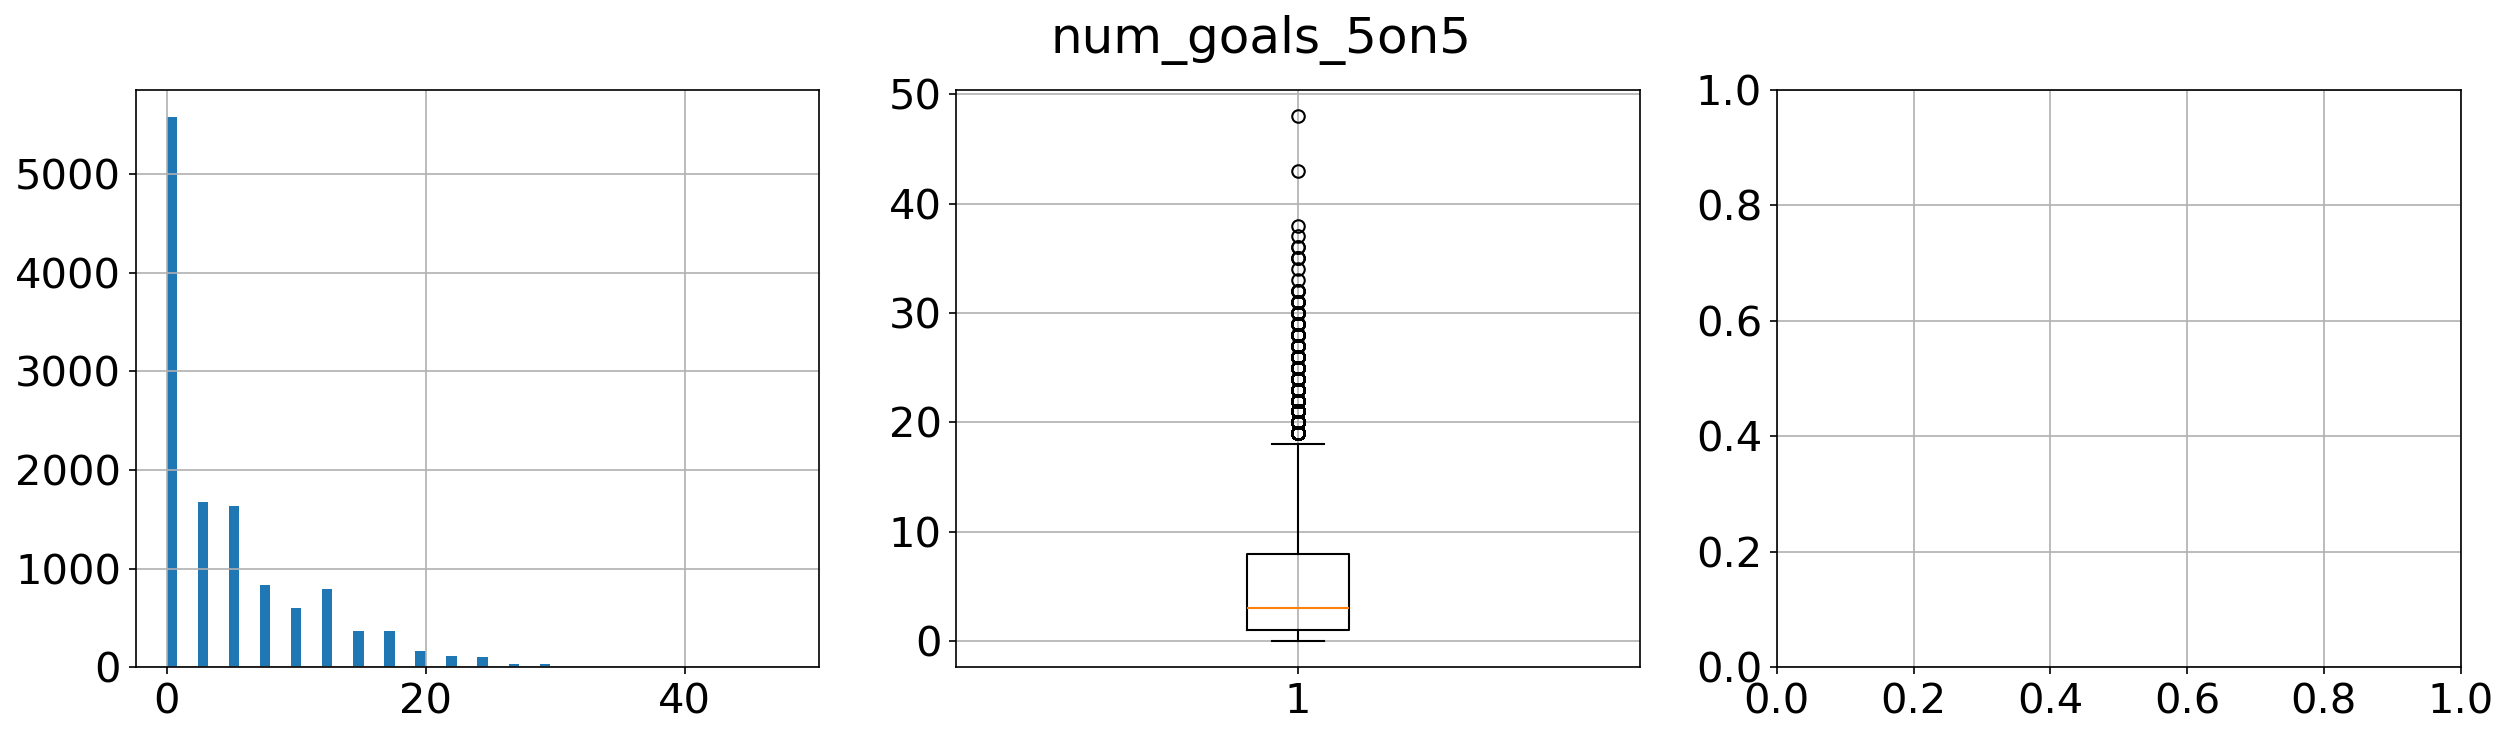

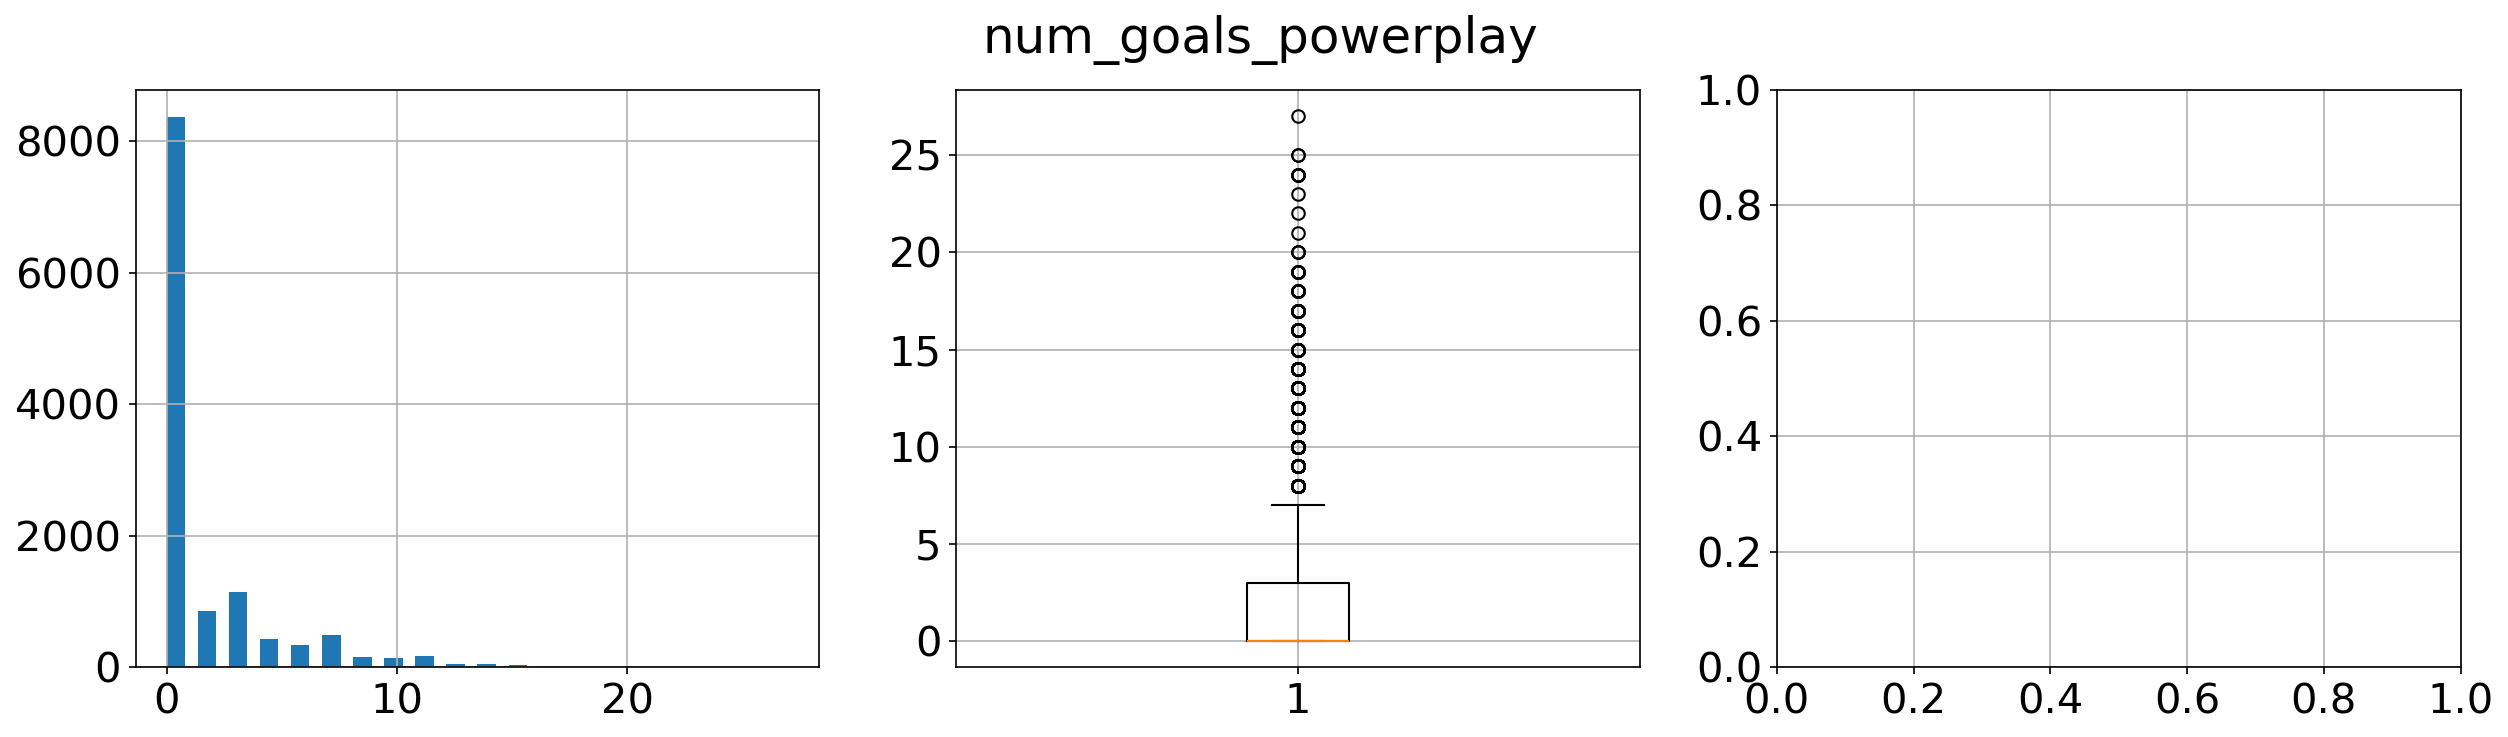

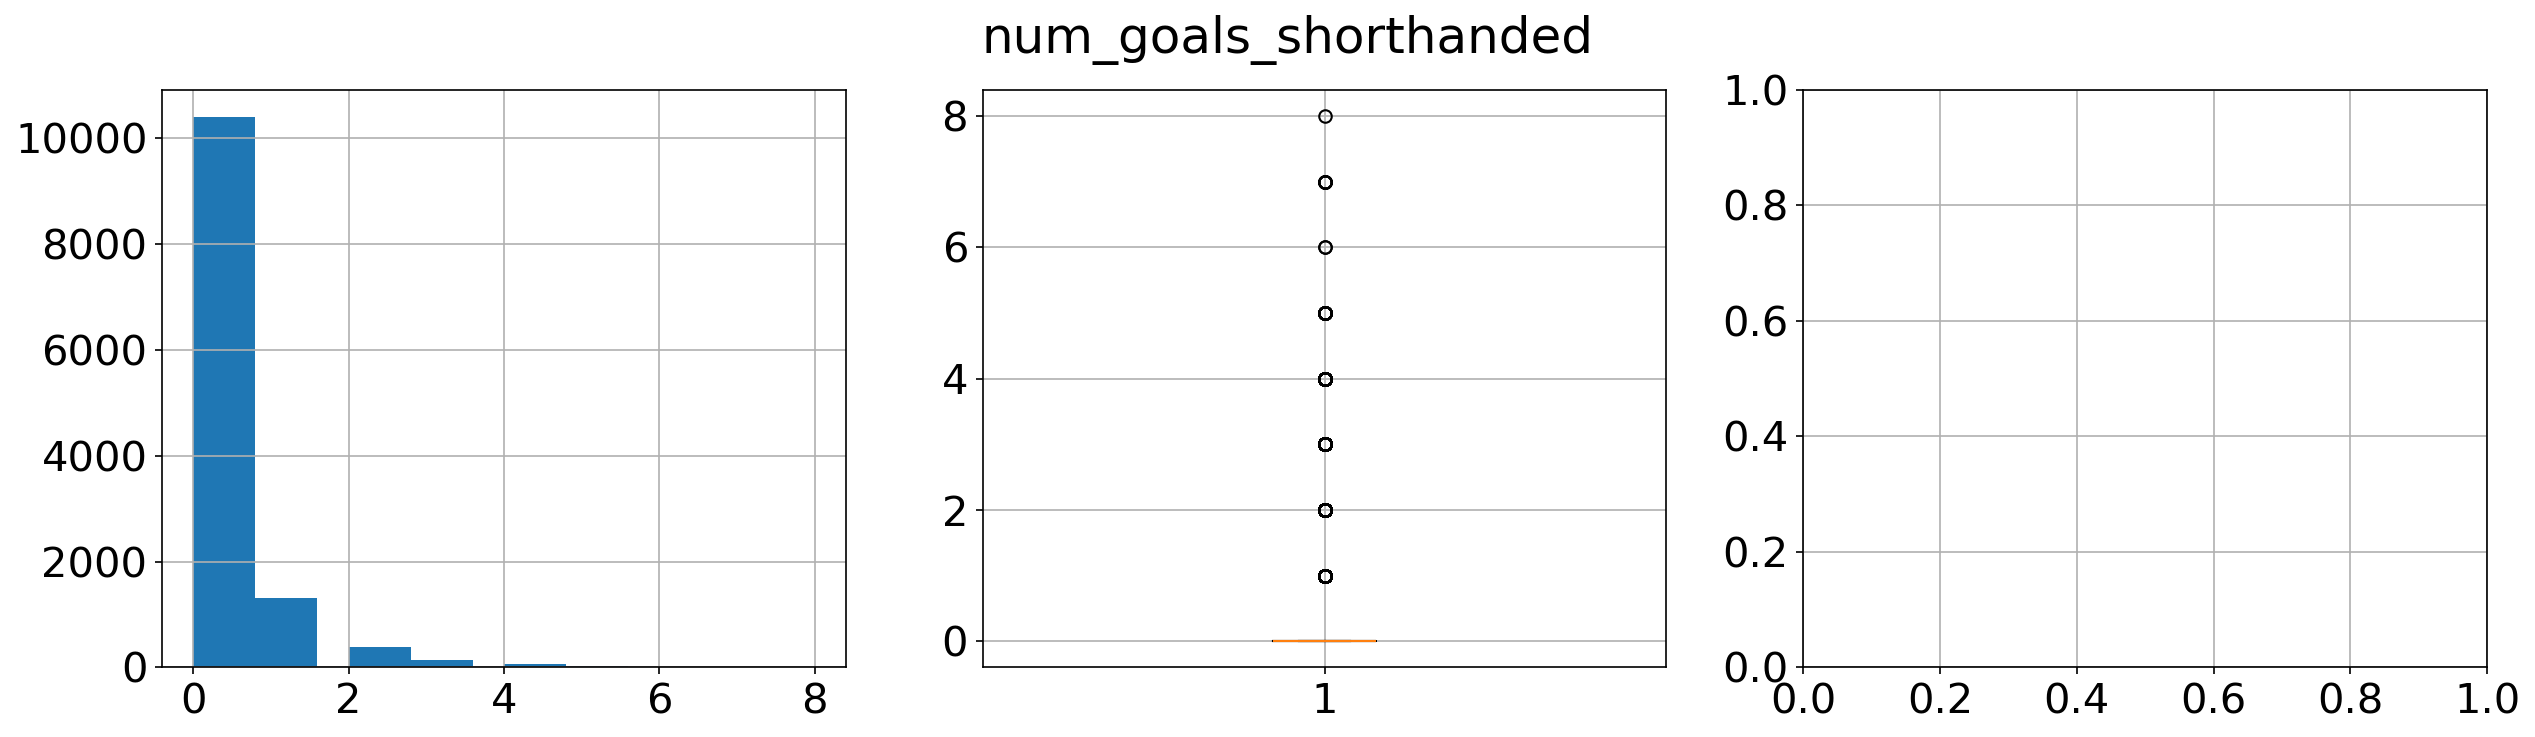

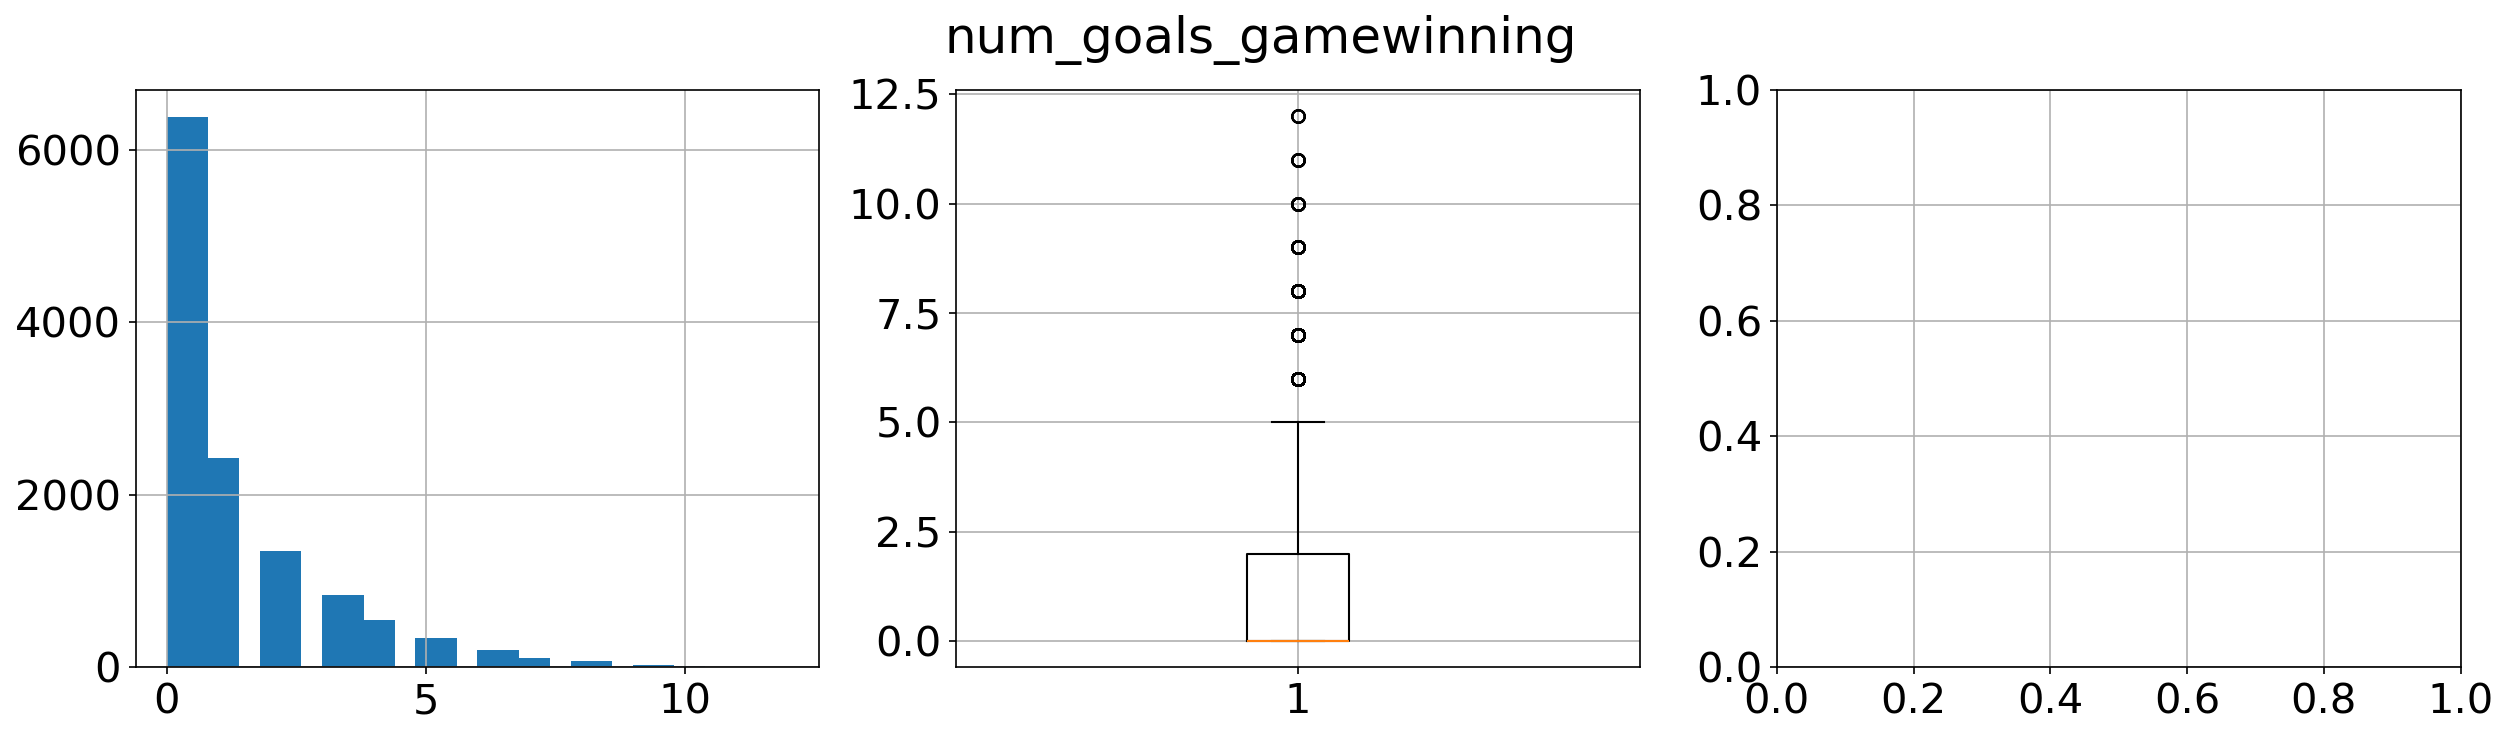

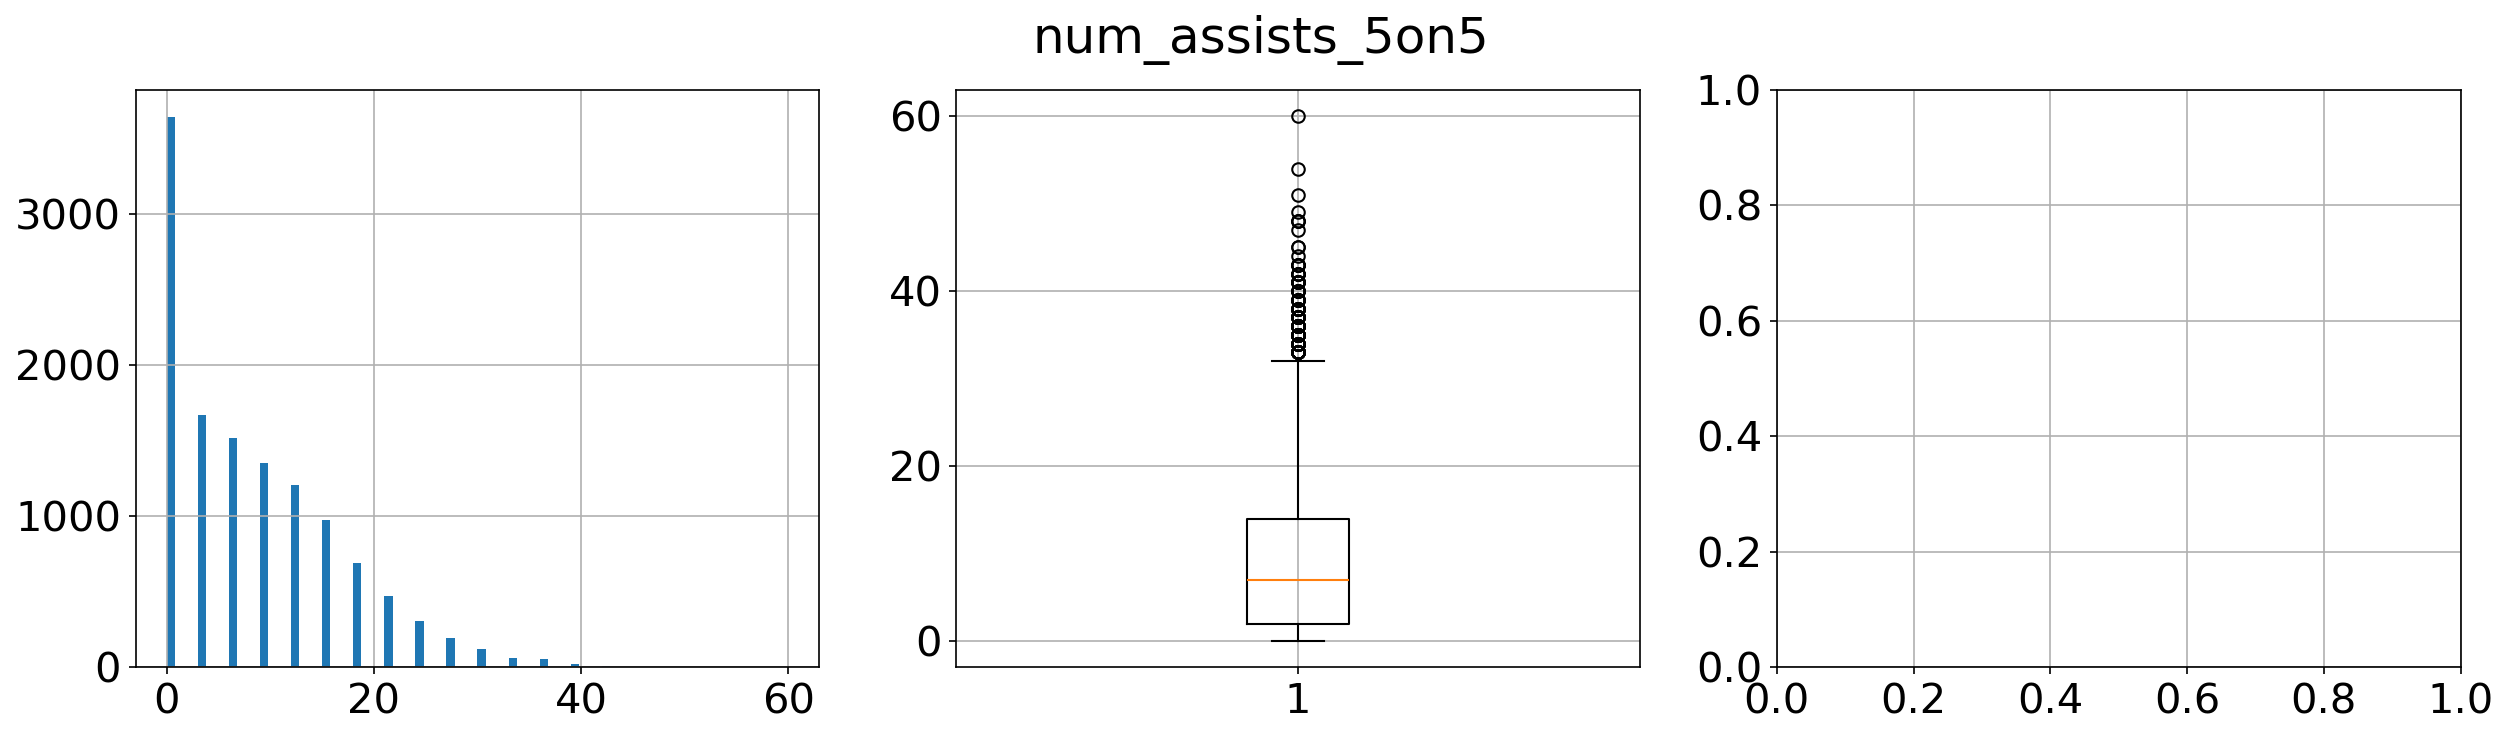

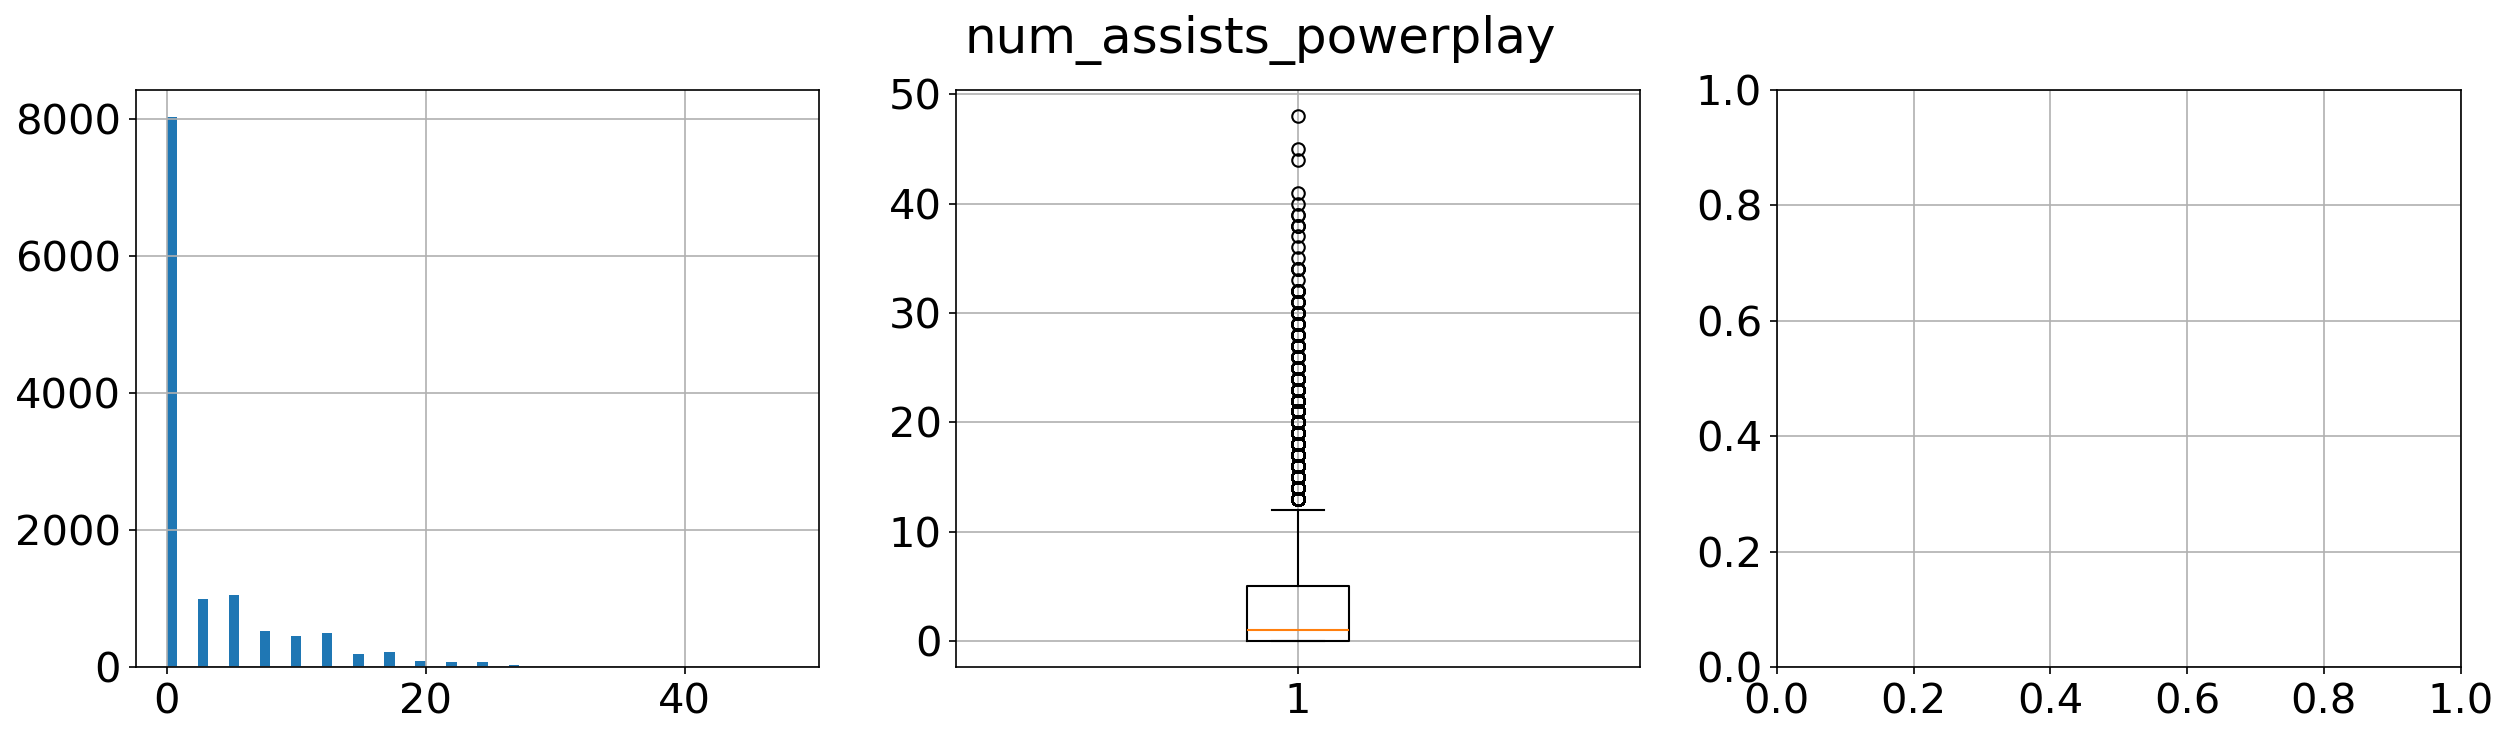

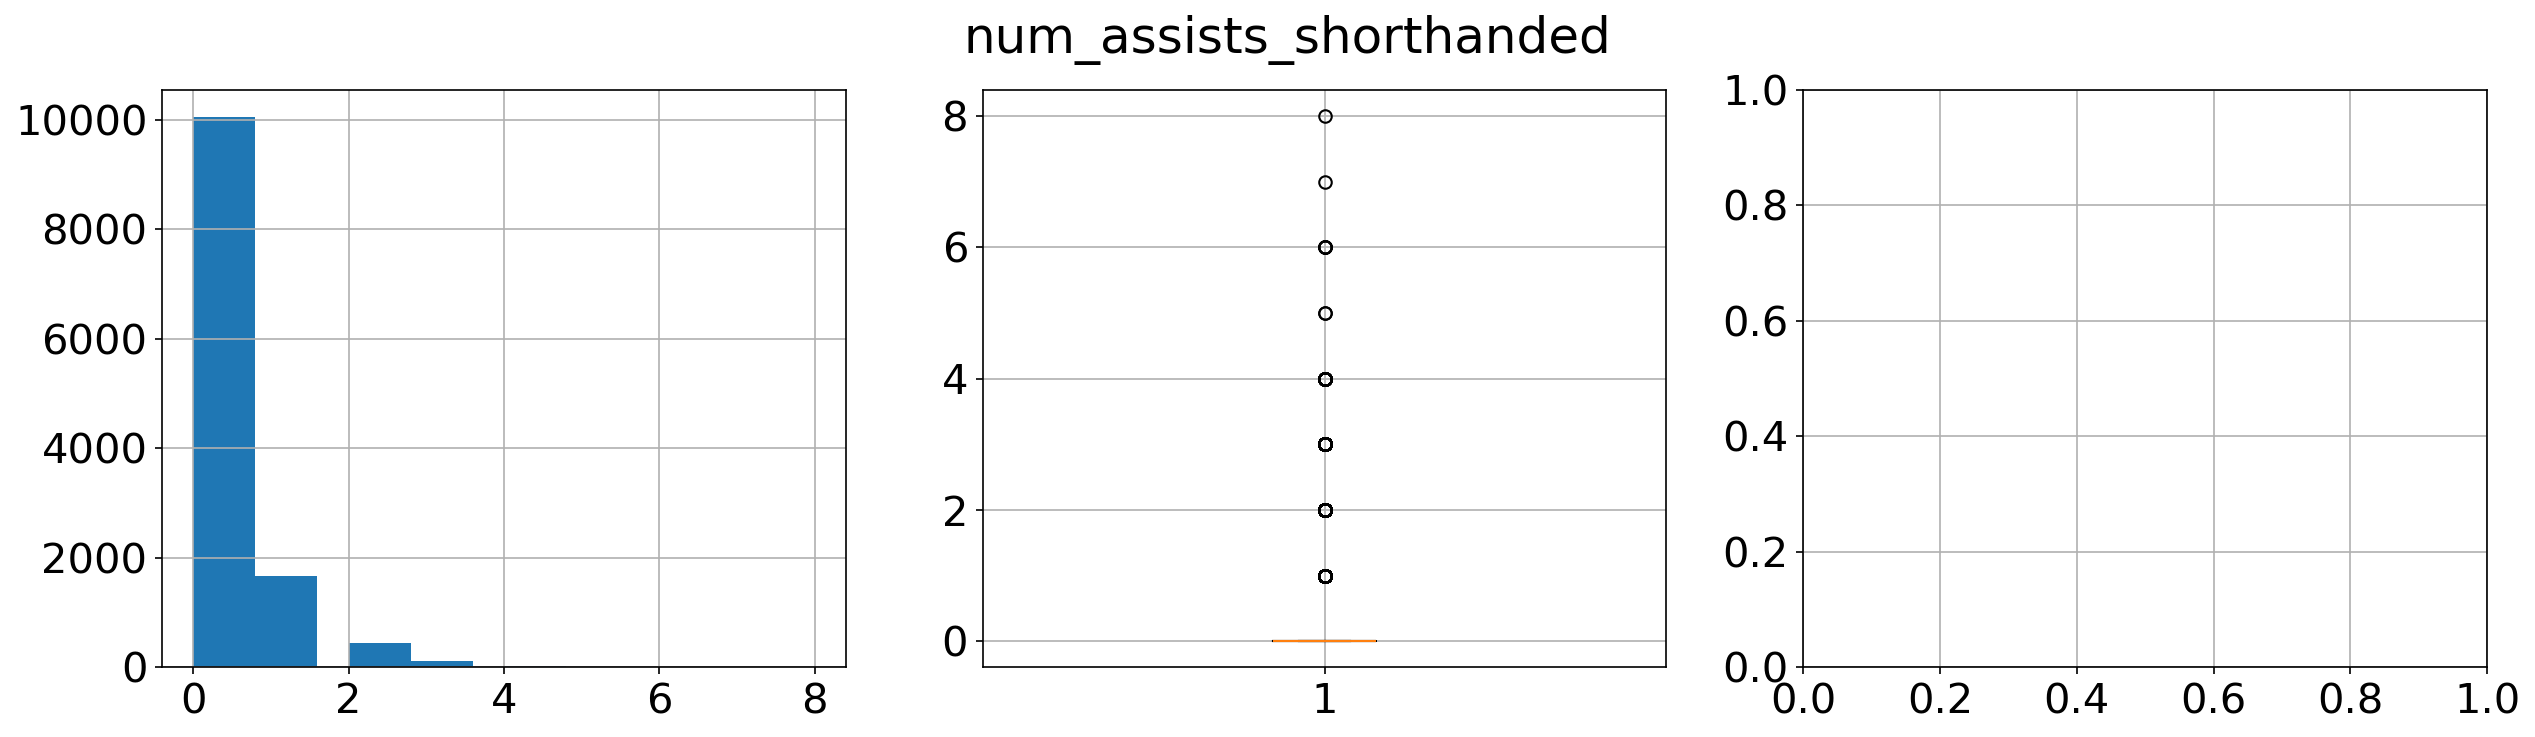

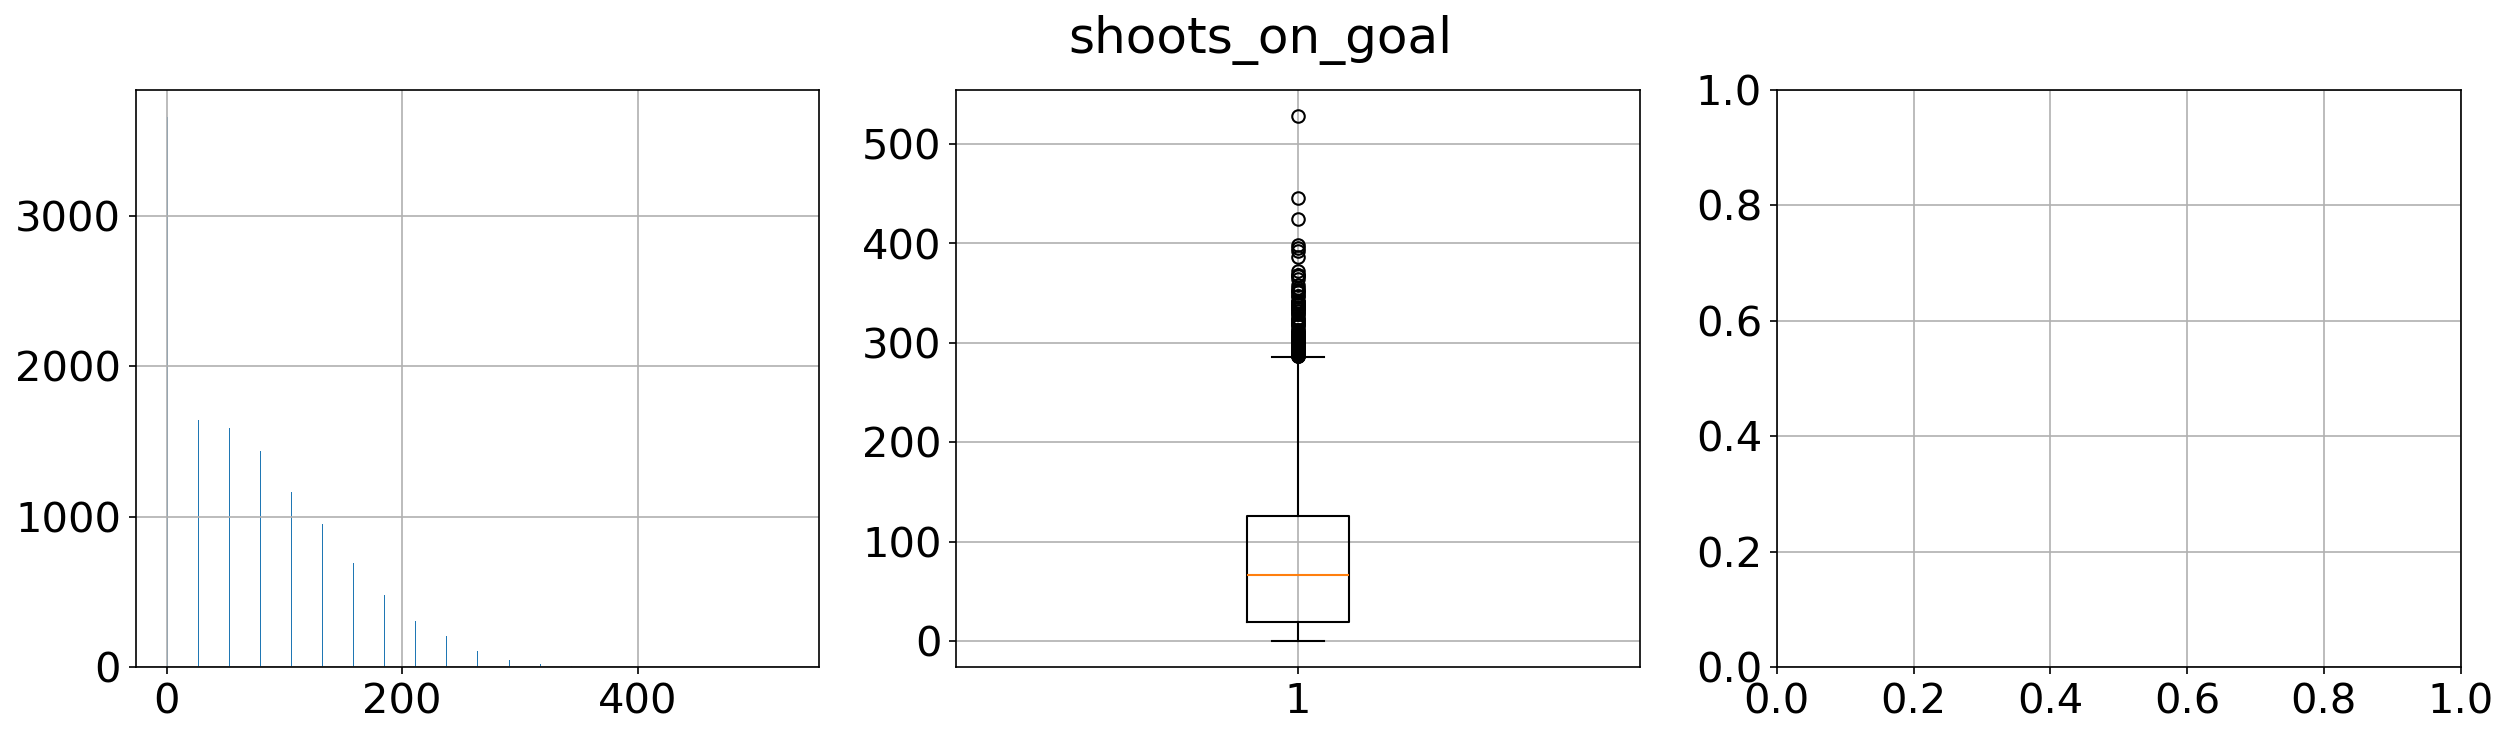

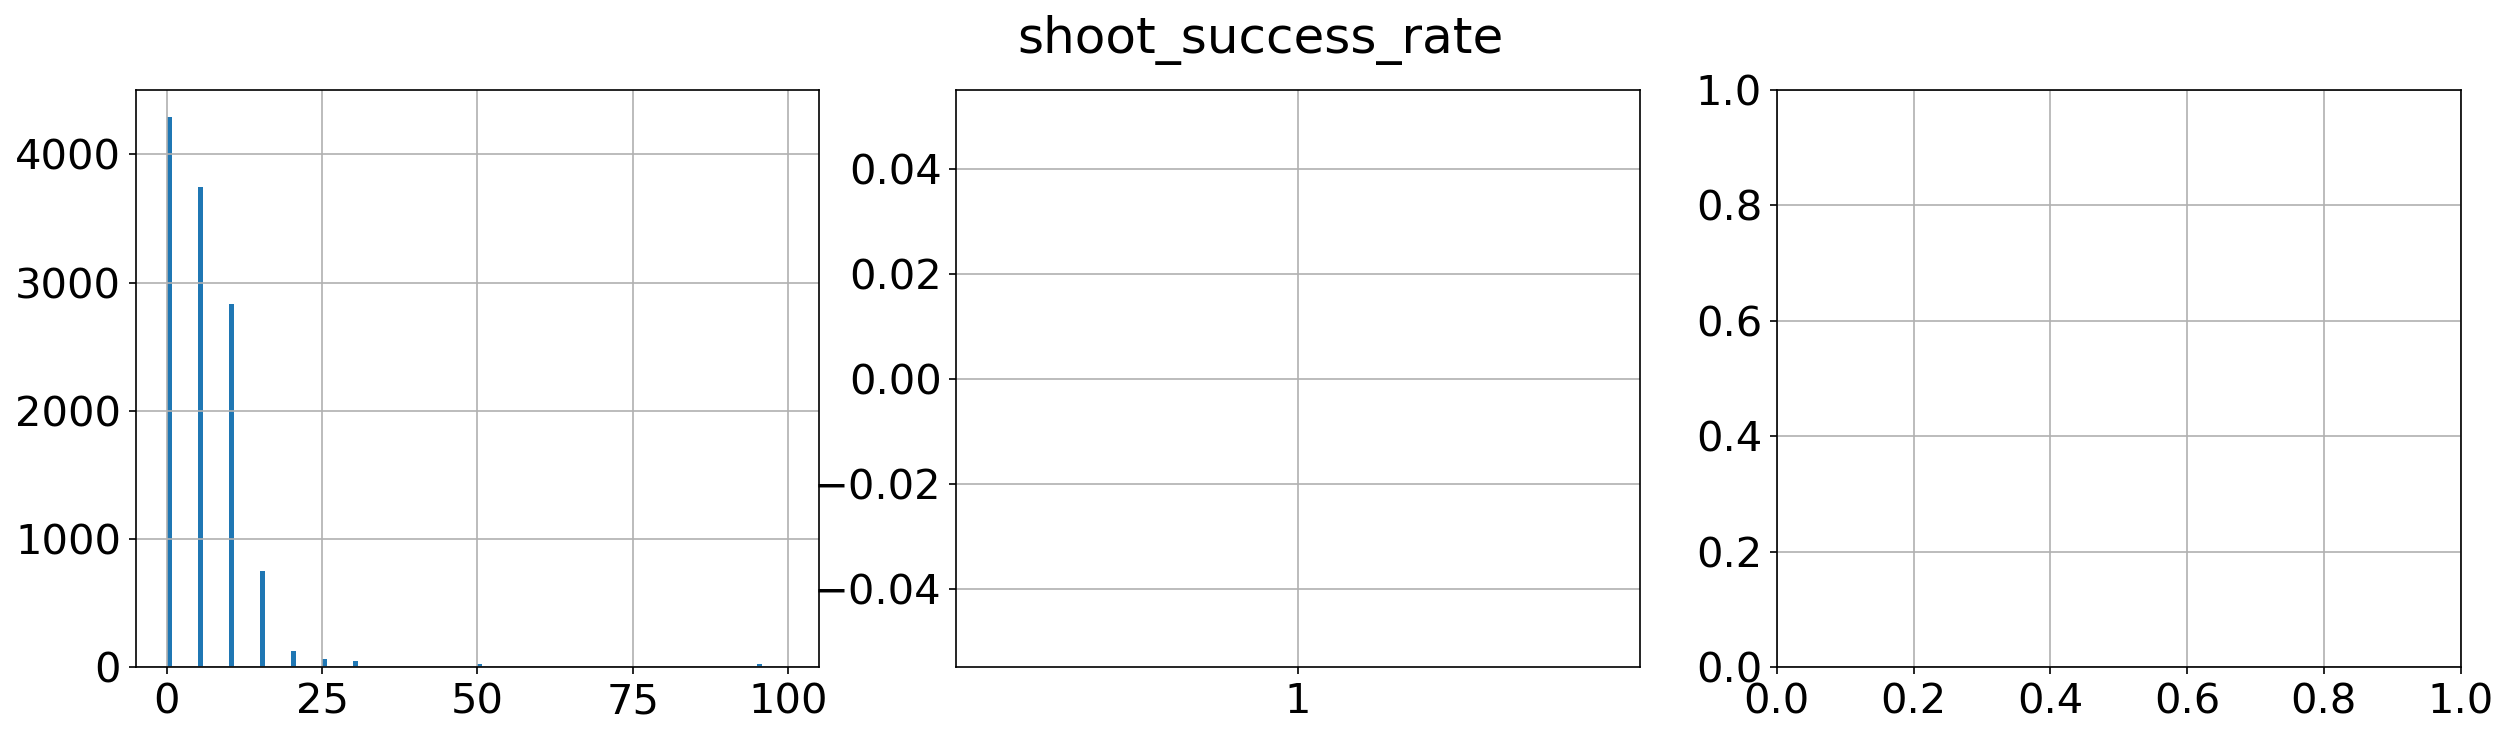

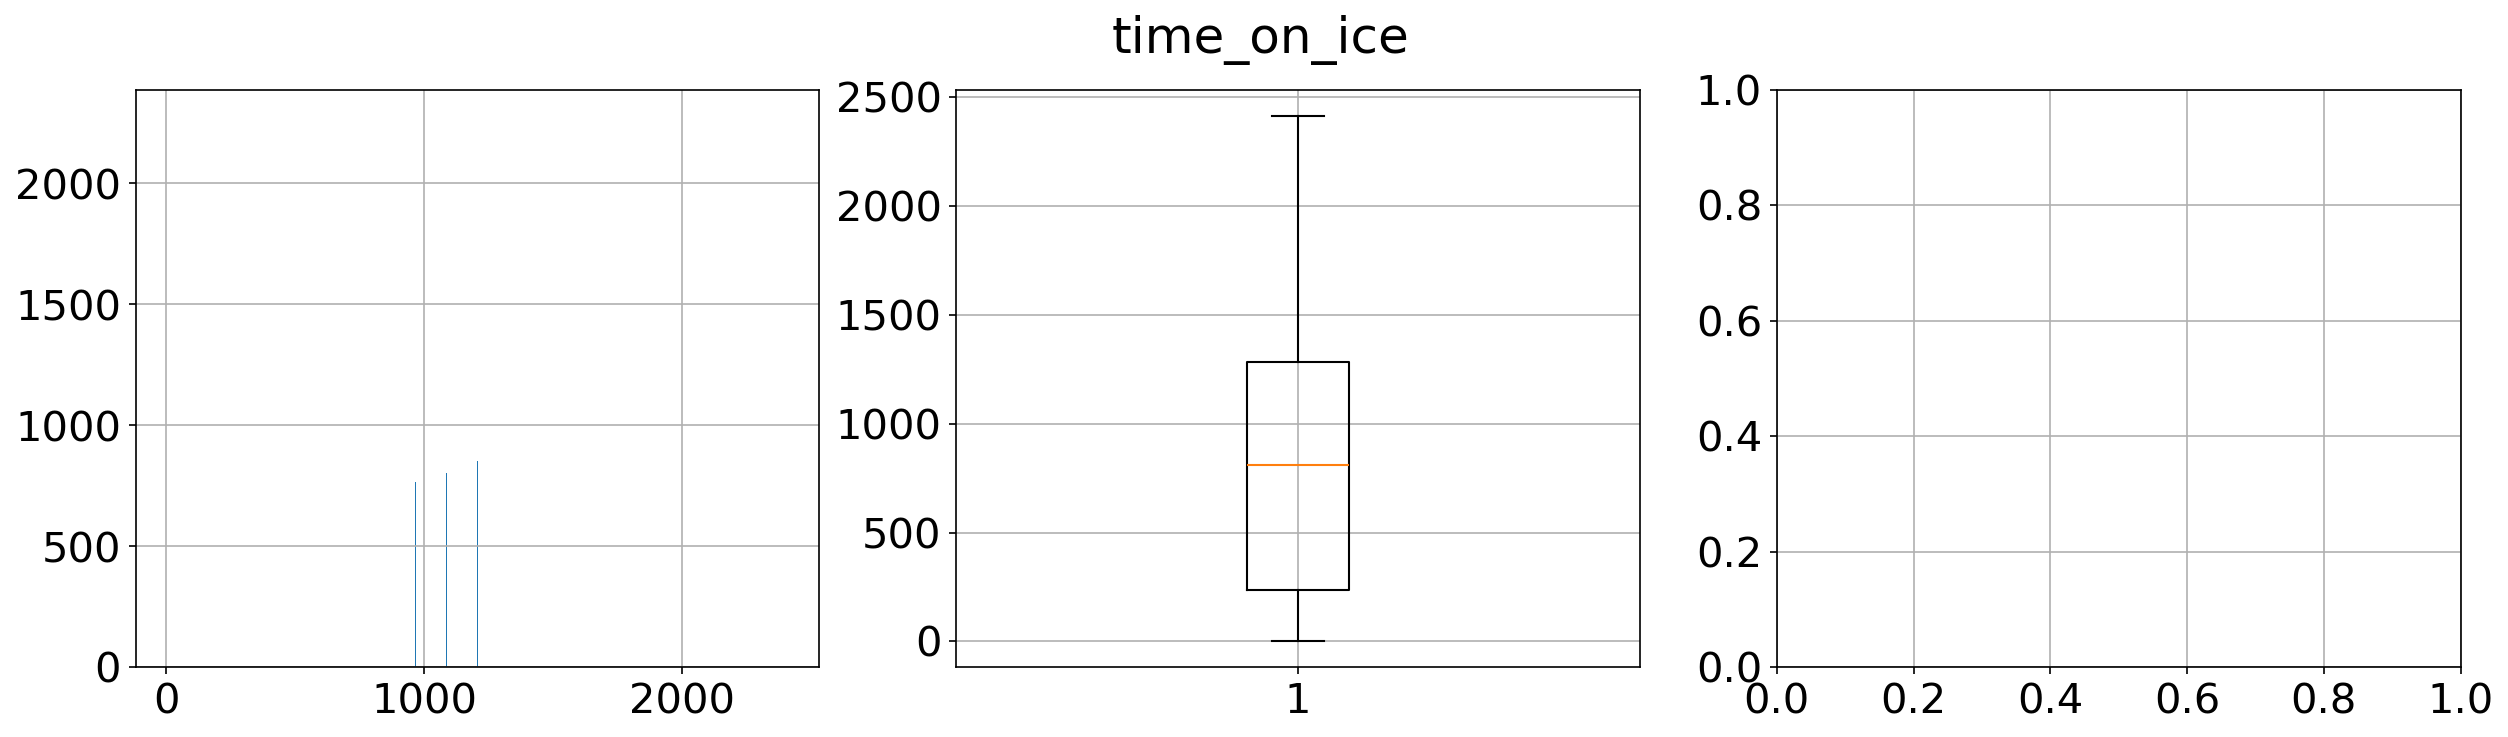

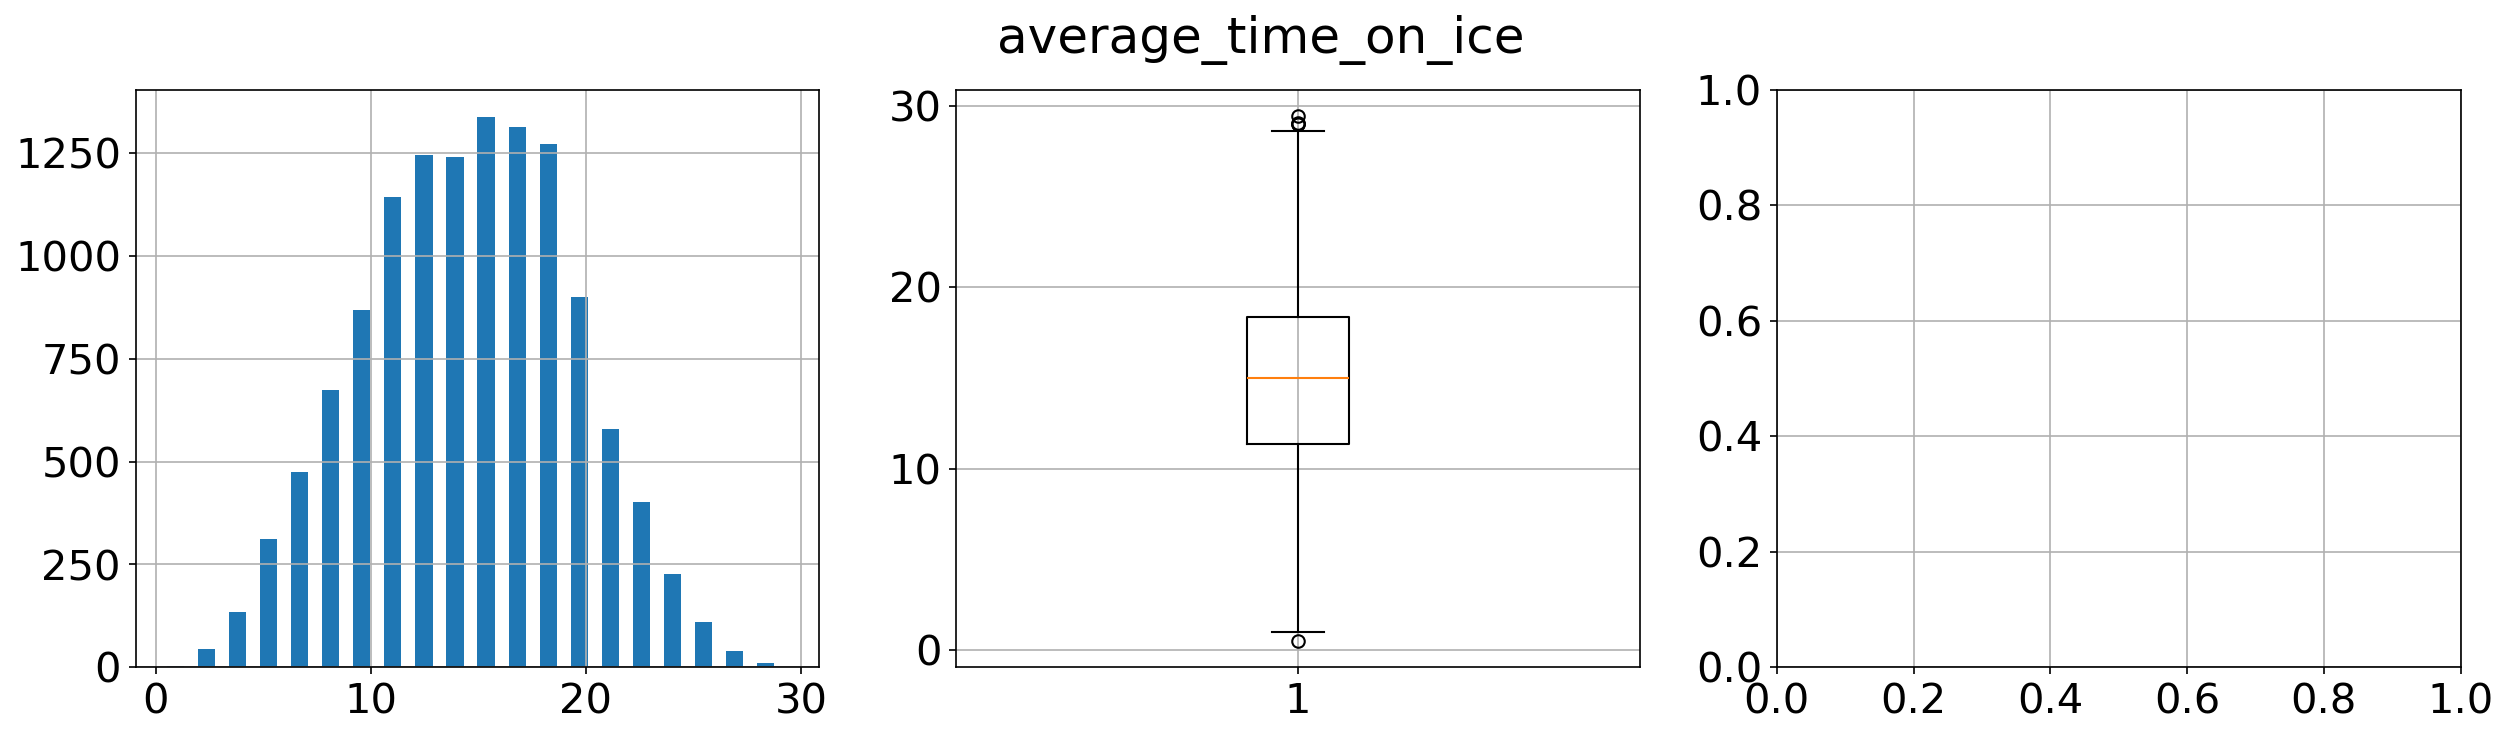

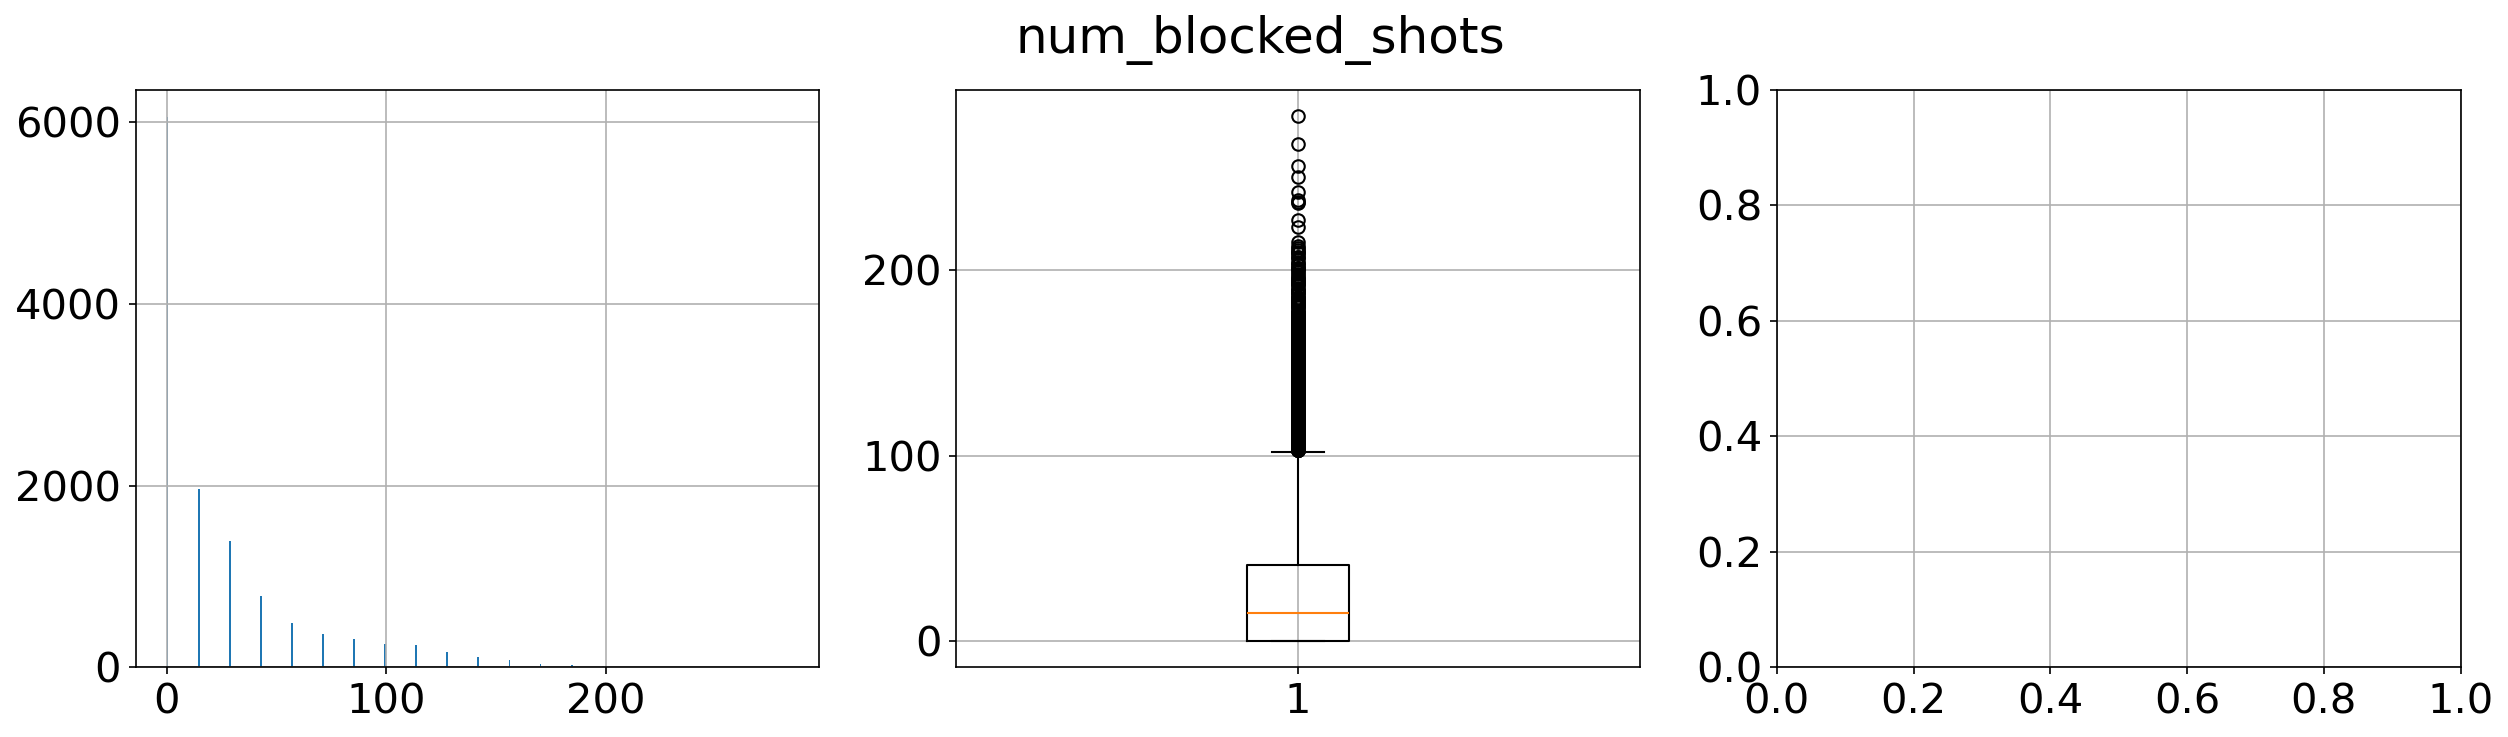

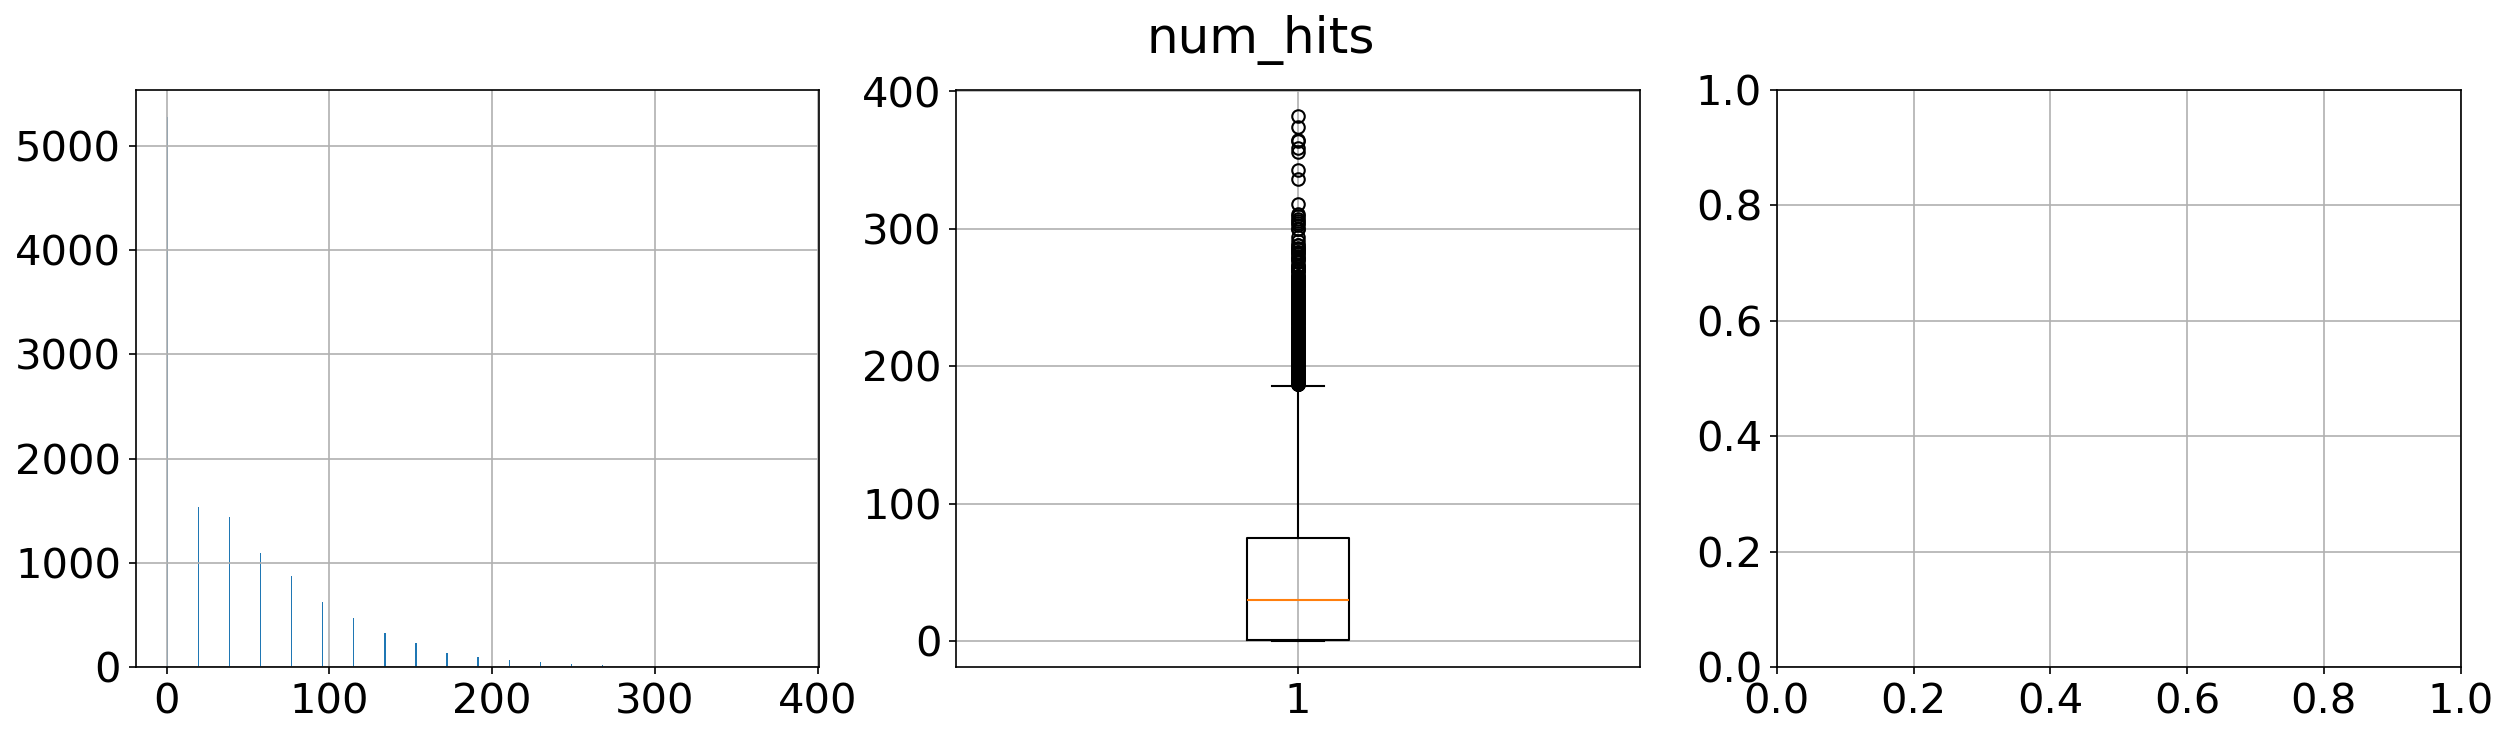

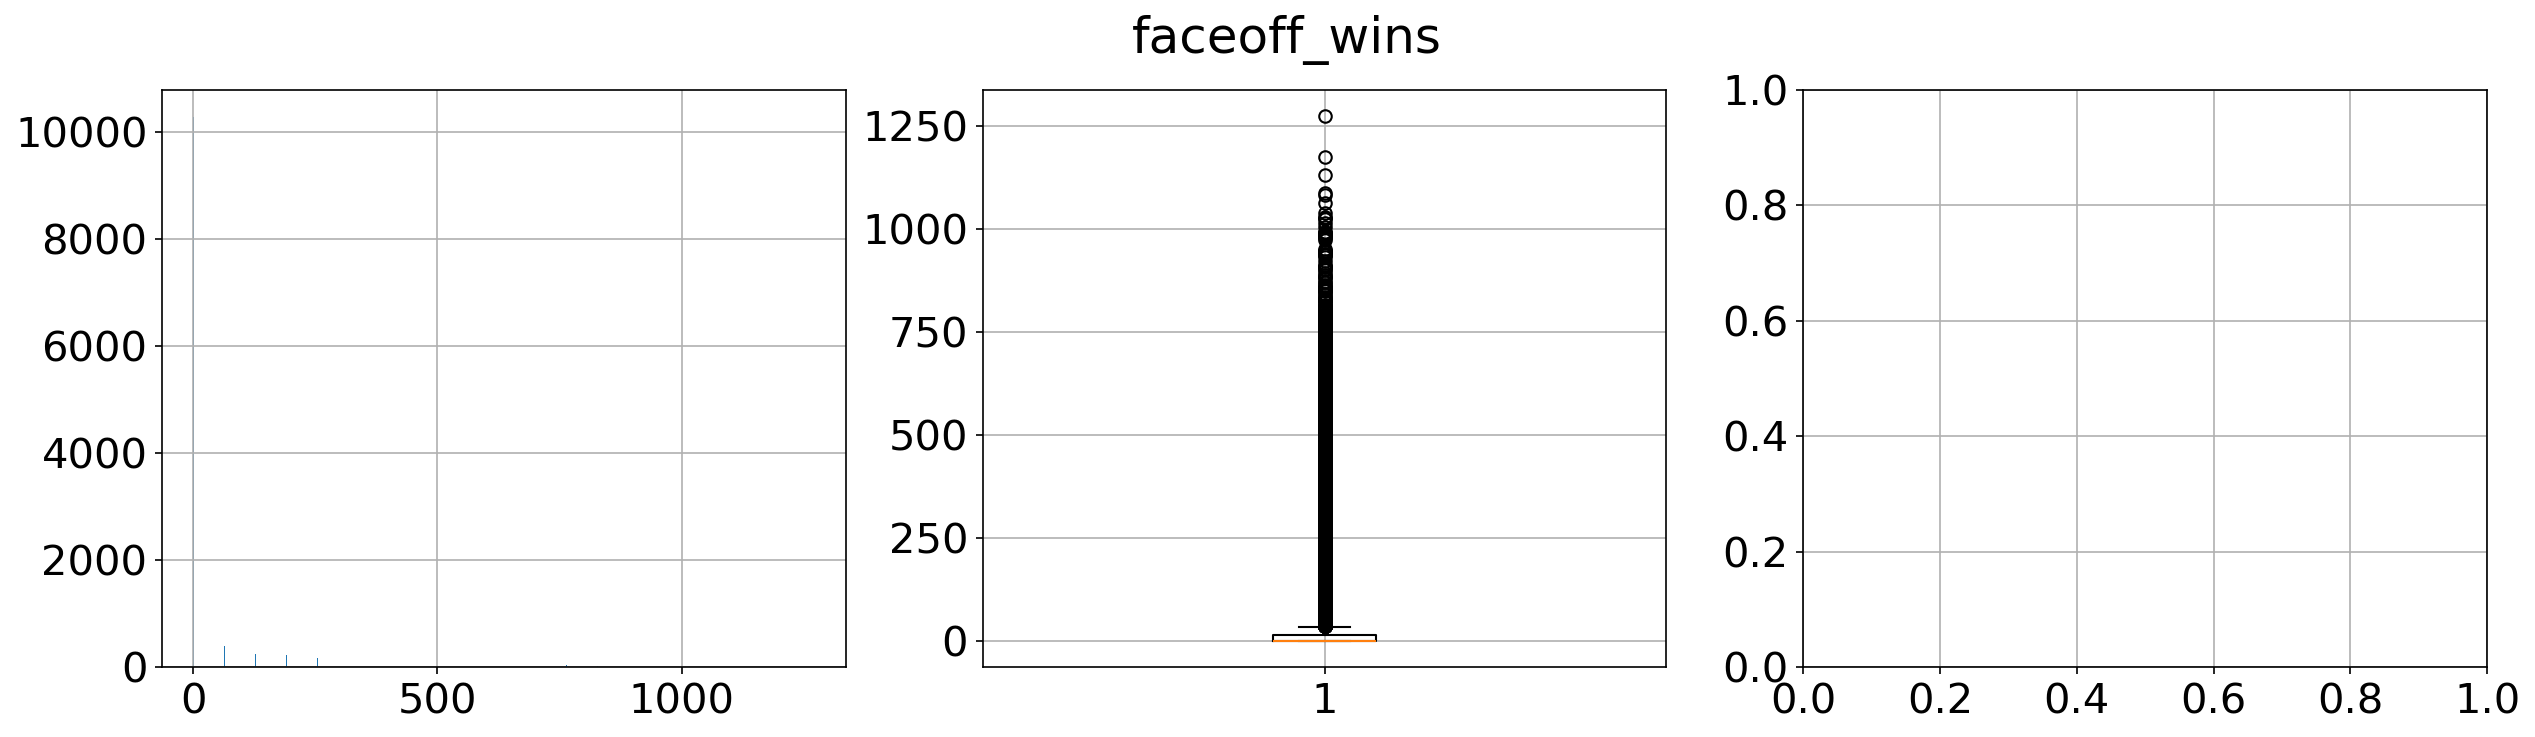

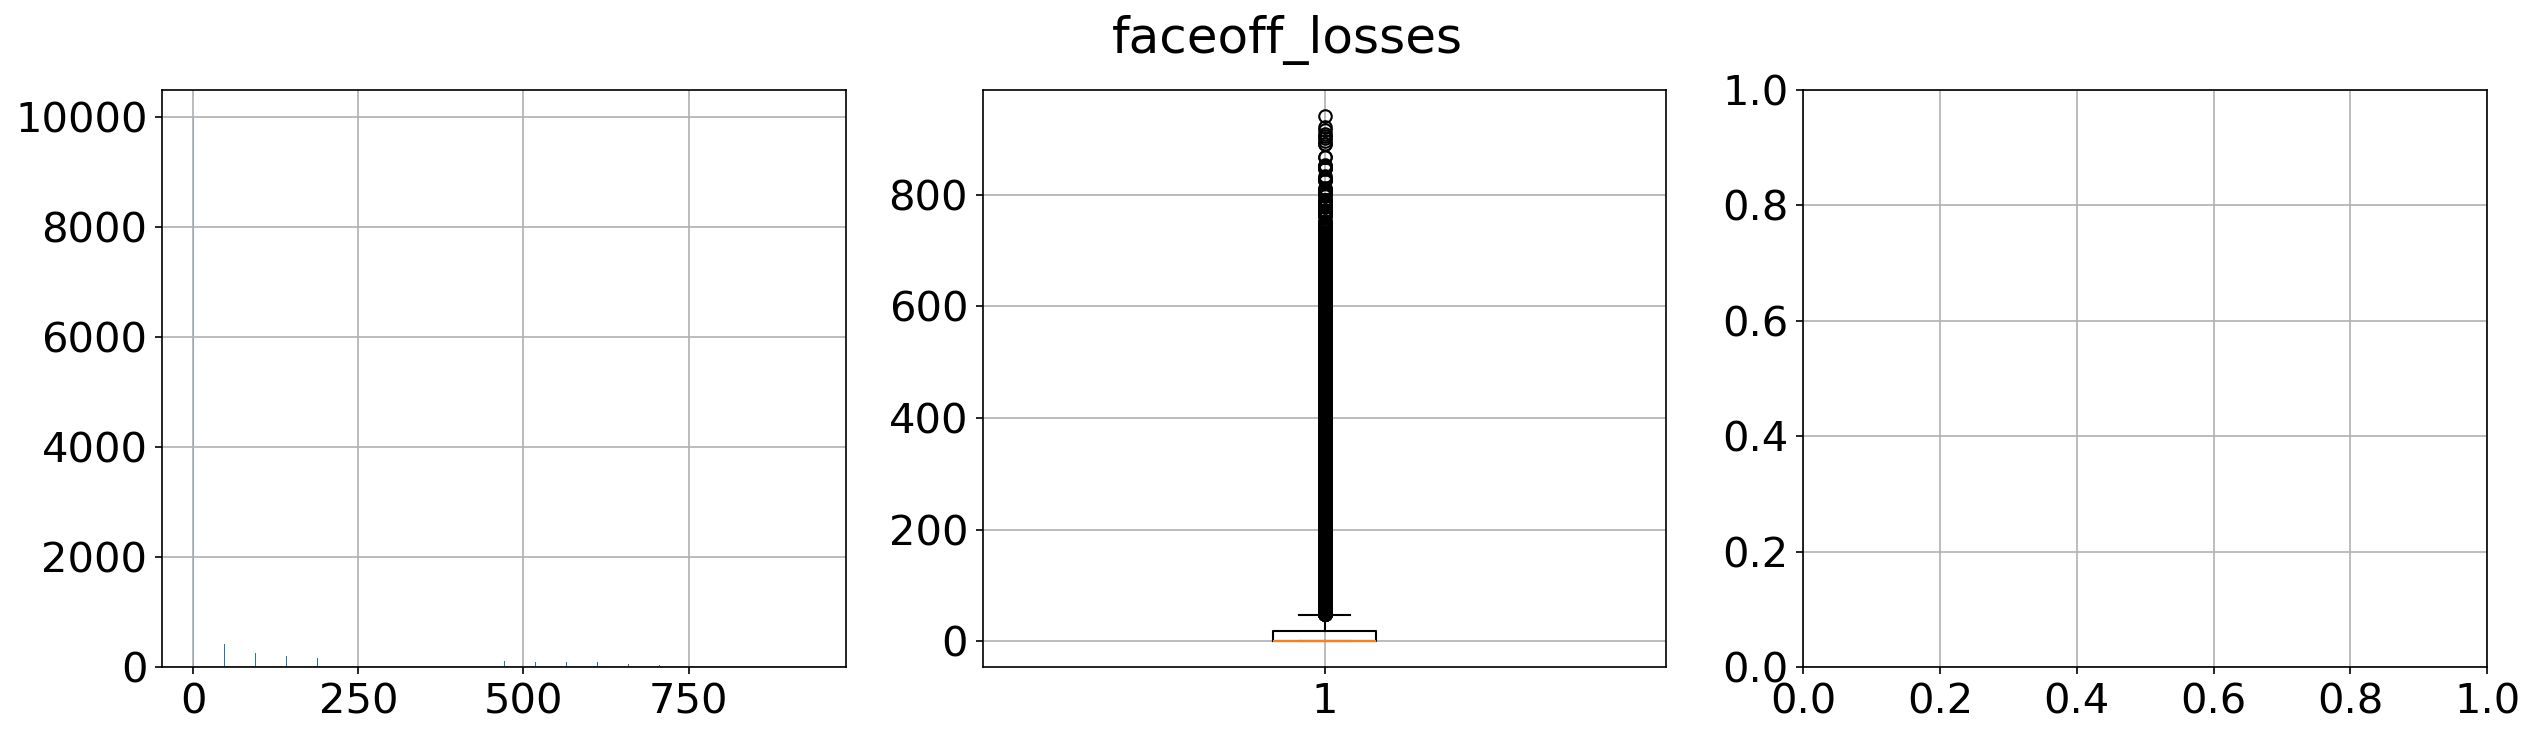

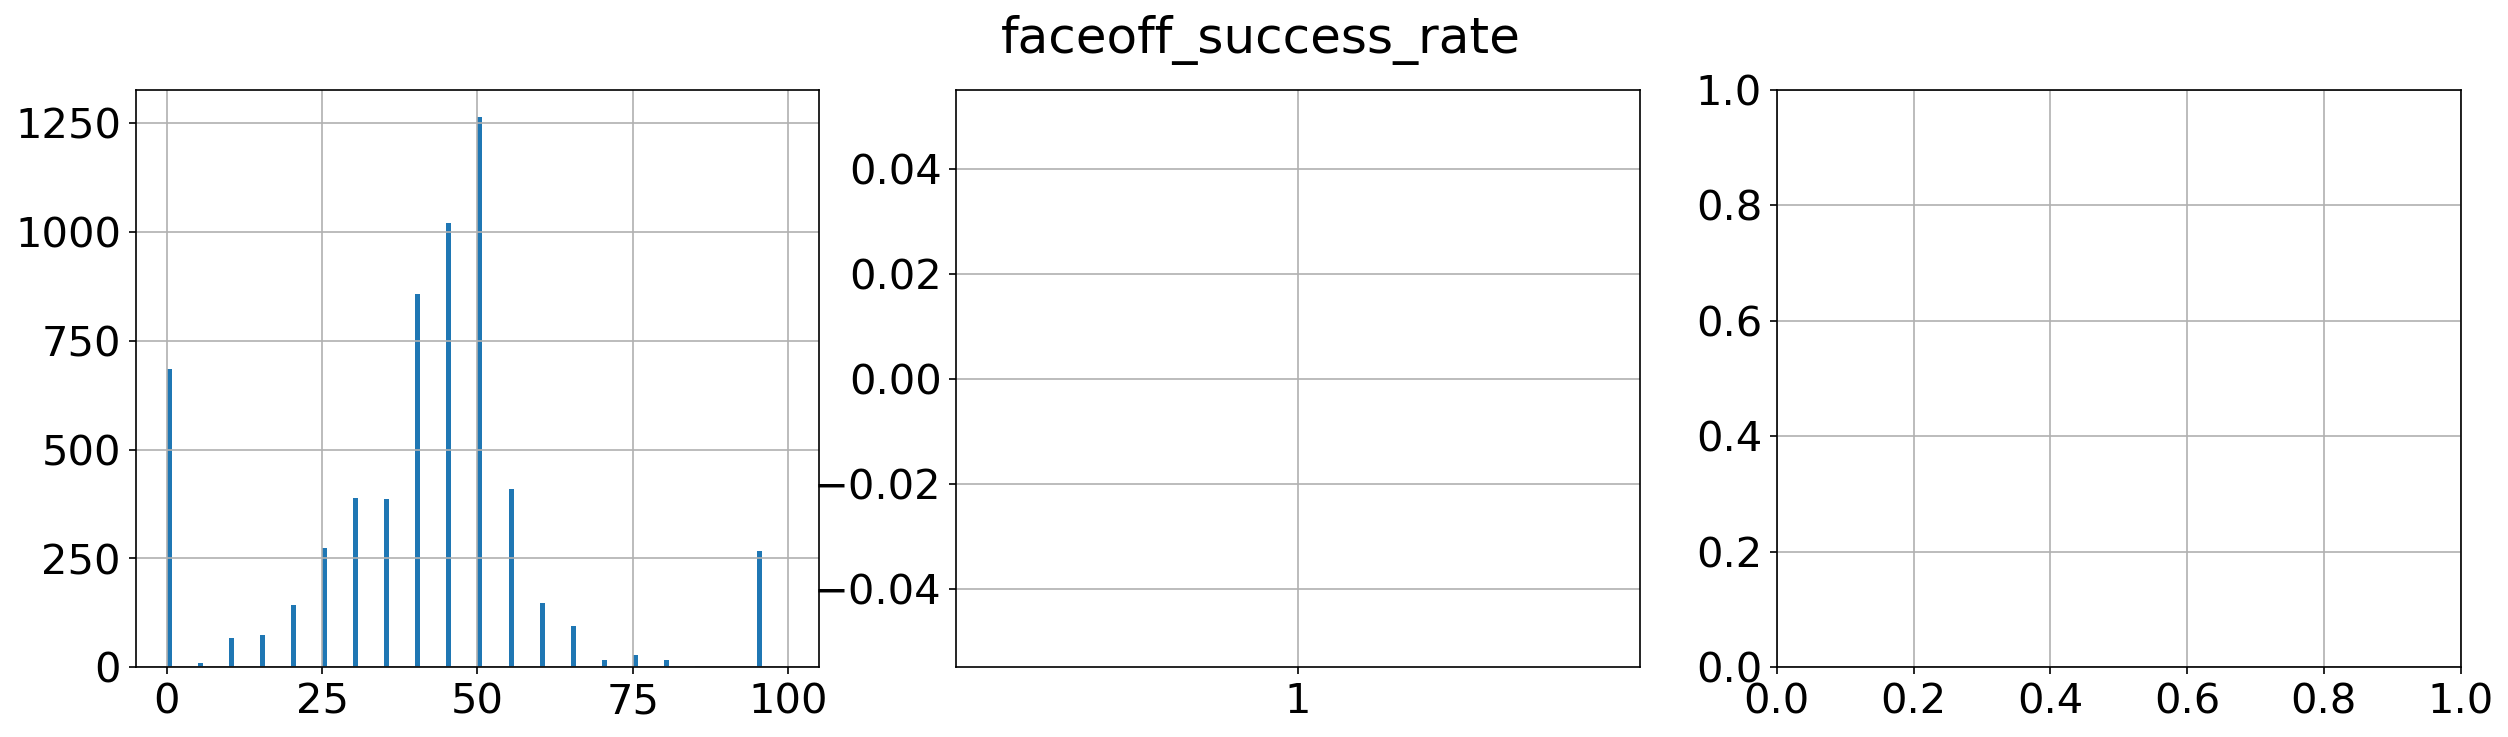

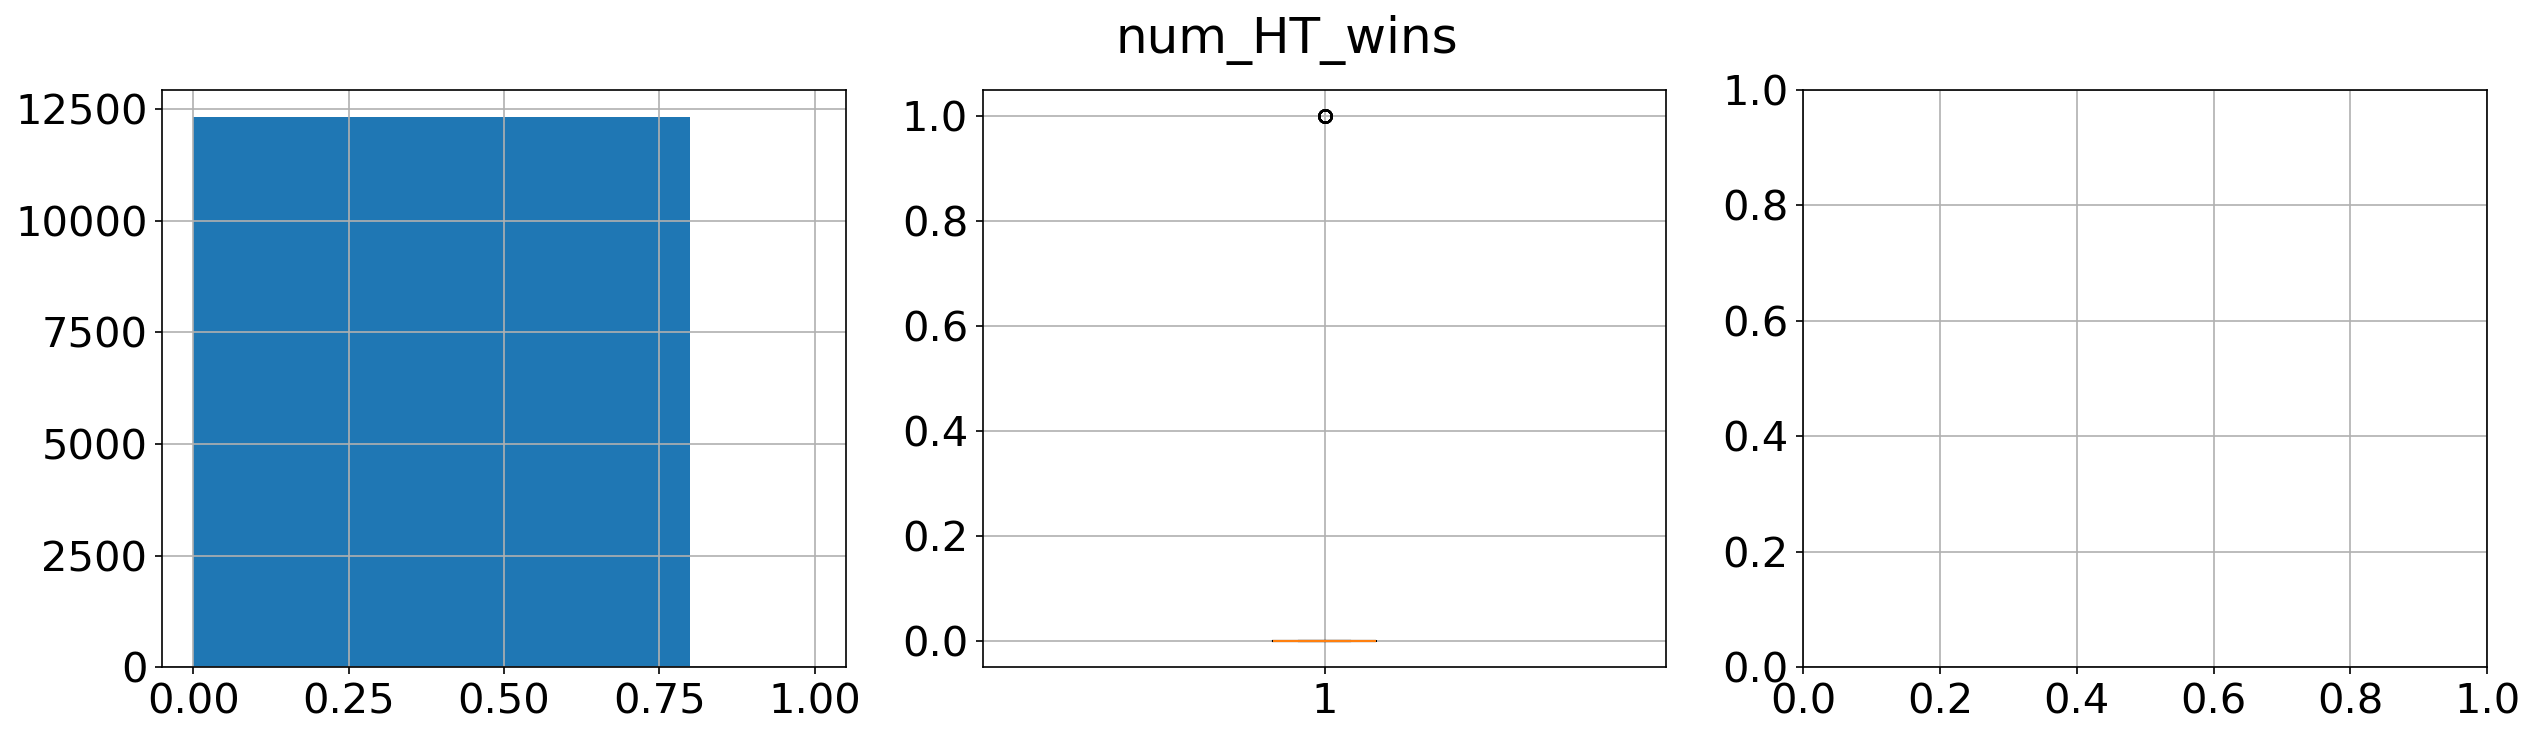

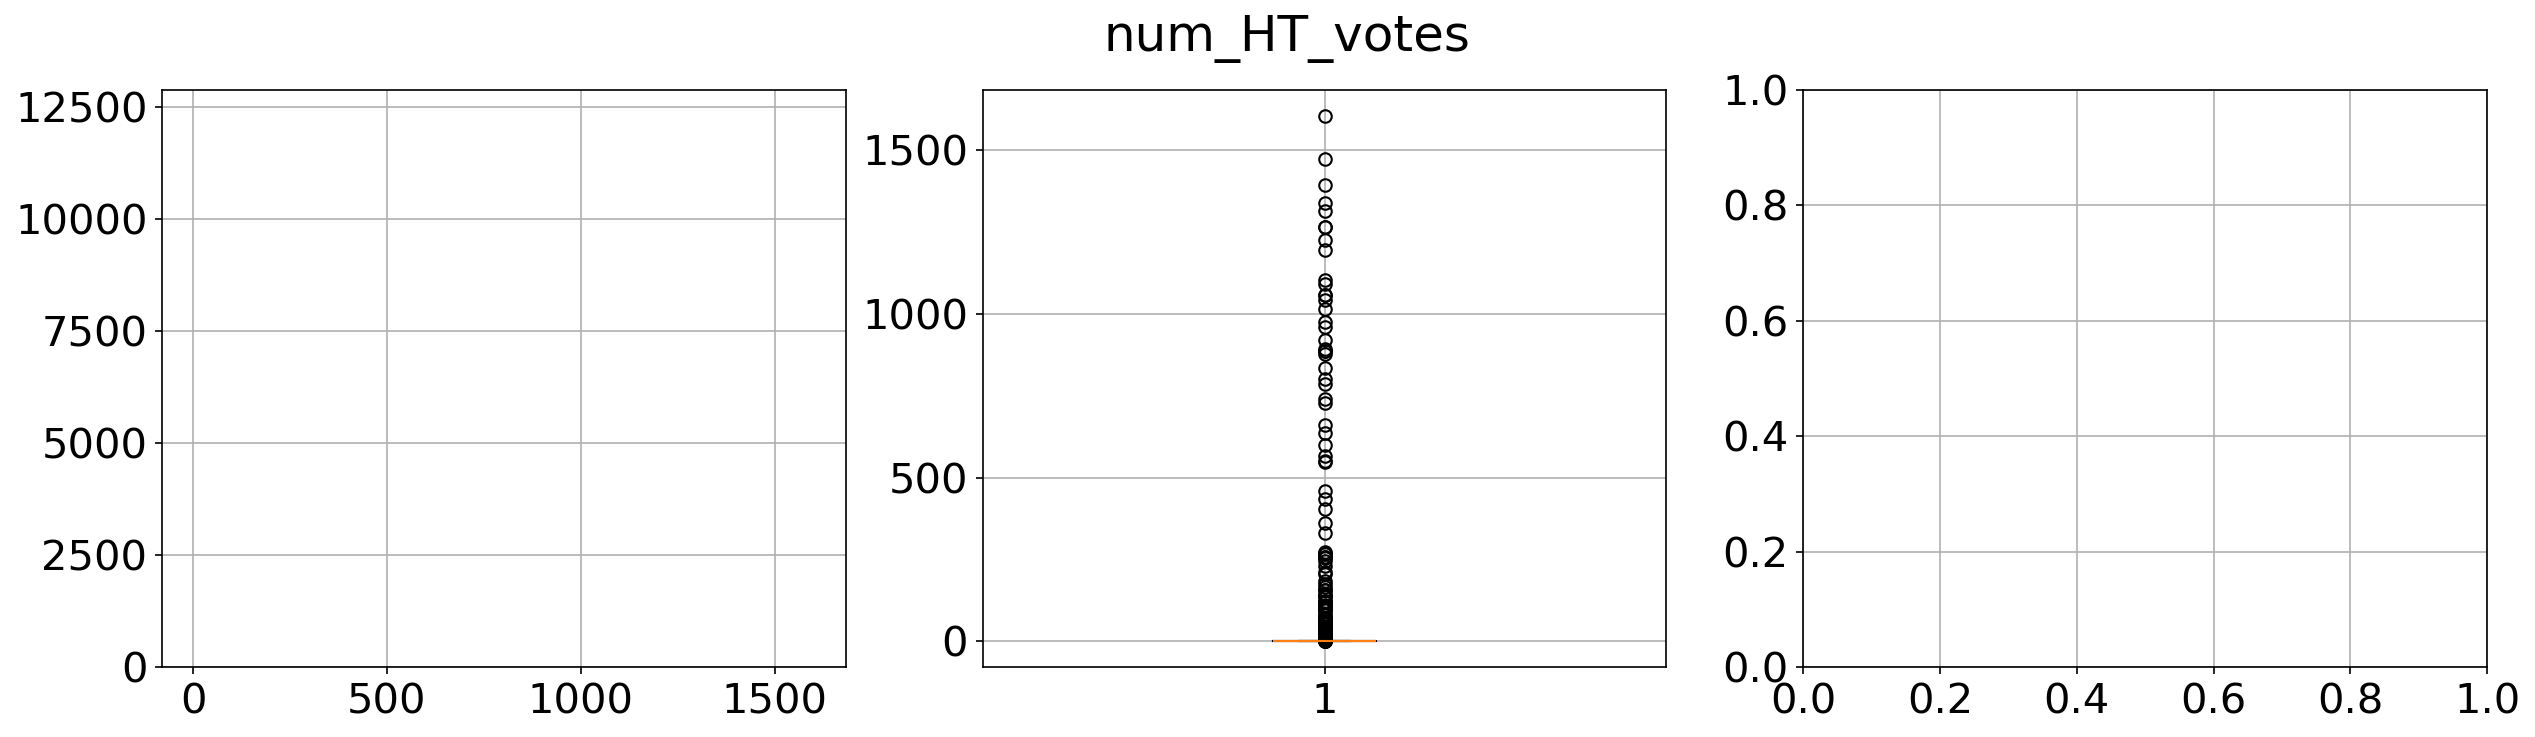

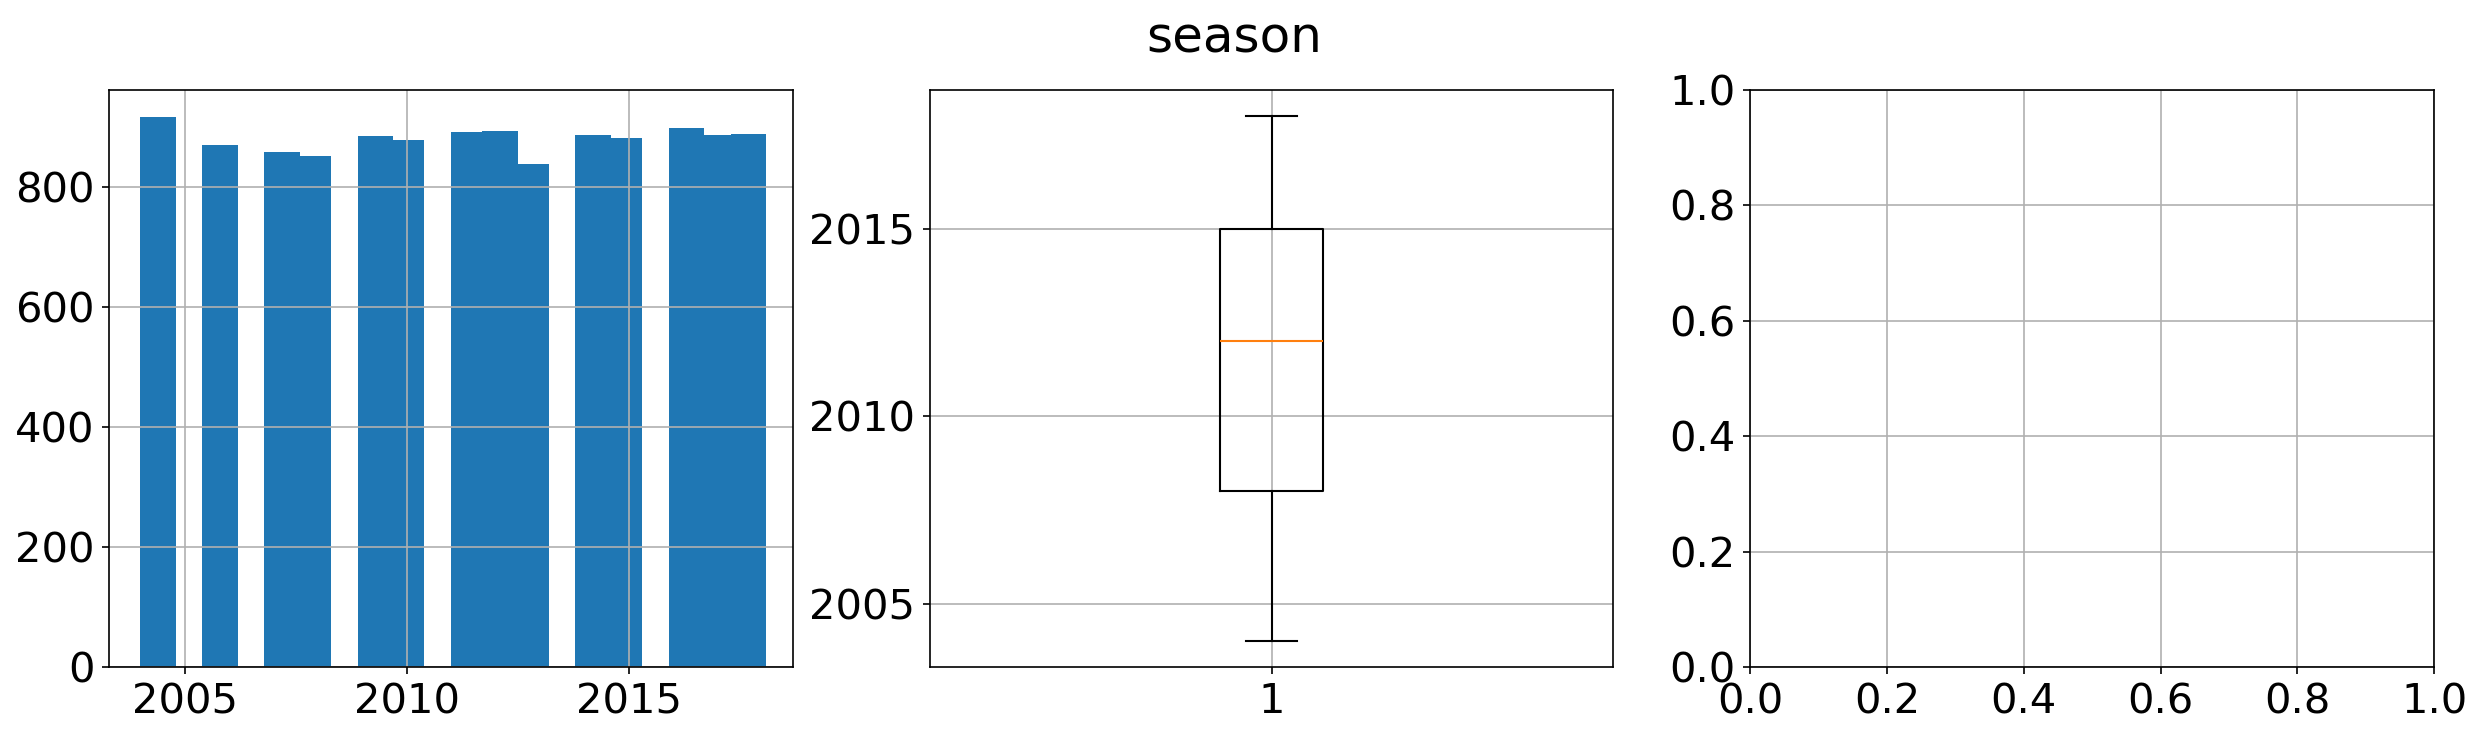

In [26]:
plt.rcParams['font.size'] = 20

# log_scales = [
#     'goals',
#     'assists',
#     'points',
#     'penalty_minutes',
#     'team_points_ratio',
#     'num_goals_5on5',
#     'num_goals_powerplay',
#     'num_goals_shorthanded',
#     'num_goals_gamewinning',
#     'num_assists_5on5',
#     'num_assists_powerplay',
#     'num_assists_shorthanded',
#     'shoots_on_goal',
#     'shoot_success_rate',
#     'num_blocked_shots',
#     'num_hits',
#     'faceoff_wins',
#     'faceoff_losses'
# ]

for col in player_df.select_dtypes([np.float64, np.int64]):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5), dpi=150)

    axes[0].hist(player_df[col], bins=20, width=0.8)
    axes[1].boxplot(player_df[col])

    for ax in axes:
        ax.grid()

    fig.suptitle(col)
    plt.show(fig)
    plt.close(fig)
